### Téléchargement des bibliothèques et des données ###

In [7]:
# Téléchargement des bibliothèques
import pandas as pd # type: ignore
import numpy as np # type: ignore
import datetime as dt # type: ignore
from datetime import timedelta # type: ignore
from dateutil.relativedelta import relativedelta # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
# from pandasgui import show
import plotly.express as px

In [8]:
# max rows 500
pd.set_option('display.max_rows', 500)
# max columns 500
pd.set_option('display.max_columns', 500)

### Téléchargement données ###

In [10]:
# Charger et concaténer tous les fichiers Parquet
old_df = pd.concat([
    pd.read_parquet('data/df_2024.parquet'),
    pd.read_parquet('data/df_2023.parquet'),
    pd.read_parquet('data/df_2022.parquet')
])

In [16]:
def generate_df_raw():
    """ generate the raw dataframe containing all the dataframes merged:
    df_dat_dep: dataframe containing the dates of departure from year_m_2 to year_next
    df_voy: dataframe containing the trips from table voyp with the attributes related to the trips
    df_dema: dataframe containing the trips from table dtvv with the attributes related to  trips/dat_dema (mgvs and mvoy).
        The table is resampled to have one row per dat_dema between dat_demamin and dat_demamax for each trip, and forward fill for all other columns
    df_resa: dataframe containing the trips from table revd with the attributes related to the trips/dat_resa (resa).
 
    Returns:
    pd.DataFrame: the raw dataframe containing all the dataframes merged
   
    """
    df_dat_dep = pd.concat(
        [
            pd.read_csv(f"data/df_dat_dep/df_dat_dep_n_m_2.csv"),
            pd.read_csv(f"data/df_dat_dep/df_dat_dep_n_m_1.csv"),
            pd.read_csv(f"data/df_dat_dep/df_dat_dep_n.csv"),
            # pd.read_csv(f"data/df_dat_dep/df_dat_dep_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_dat_dep["dat_dep"] = pd.to_datetime(df_dat_dep["dat_dep"]).dt.date
 
 
    df_voy = pd.concat(
        [
            pd.read_csv(f"data/df_voy/df_voy_n_m_2.csv"),
            pd.read_csv(f"data/df_voy/df_voy_n_m_1.csv"),
            pd.read_csv(f"data/df_voy/df_voy_n.csv"),
            # pd.read_csv(f"data/df_voy/df_voy_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_voy["dat_dep"] = pd.to_datetime(df_voy["dat_dep"]).dt.date
    # Converting hor_dep to time
    # df_voy["hor_dep"] = pd.to_datetime(df_voy["hor_dep"]).dt.time
 
    df_dema = pd.concat(
        [
            pd.read_csv(f"data/df_dema/df_dema_n_m_2.csv"),
            pd.read_csv(f"data/df_dema/df_dema_n_m_1.csv"),
            pd.read_csv(f"data/df_dema/df_dema_n.csv"),
            # pd.read_csv(f"data/df_dema/df_dema_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Converting dat_dep to date
    df_dema["dat_dep"] = pd.to_datetime(df_dema["dat_dep"]).dt.date
    # Converting dat_dema to date
    df_dema["dat_dema"] = pd.to_datetime(df_dema["dat_dema"]).dt.date
    # Converting hor_dep to time
    # df_dema["hor_dep"] = pd.to_datetime(df_dema["hor_dep"]).dt.time

    # Calculer la colonne 'resa_courte' sur df_dema
    df_dema['resa_courte'] = df_dema.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['dat_dema'].transform(
        lambda x: (x.max() - x.min()).days < 90
    )
 
    df_resa = pd.concat(
        [
            pd.read_csv(f"data/df_resa/df_resa_n_m_2.csv"),
            pd.read_csv(f"data/df_resa/df_resa_n_m_1.csv"),
            pd.read_csv(f"data/df_resa/df_resa_n.csv"),
            # pd.read_csv(f"data/df_resa/df_resa_n_p_1.csv"),
        ],
        ignore_index=True,
    )
    # Grouping df_resa by dat_dep, cod_lign, hor_dep, dat_dema
    df_resa = (
        df_resa.groupby(["dat_dep", "cod_lign", "hor_dep", "dat_resa"])
        .agg(
            qte_pax=("qte_pax", "sum"),
            qte_veh=("qte_veh", "sum"),
            qte_cab=("qte_cab", "sum"),
            mnt_resa=("mnt_resa", "sum"),
            qte_ml=("qte_ml", "sum"),
            mnt_fret=("mnt_fret", "sum"),
        )
        .reset_index()
    )
    df_resa.rename(columns={"dat_resa": "dat_dema"}, inplace=True)
    # Converting dat_dep to date
    df_resa["dat_dep"] = pd.to_datetime(df_resa["dat_dep"]).dt.date
    # Converting dat_dema to date
    df_resa["dat_dema"] = pd.to_datetime(df_resa["dat_dema"]).dt.date
    # Convert hor_dep from timedelta to str then to time # TODO remove with next generation of df_resa if ok
    # df_resa["hor_dep"] = df_resa["hor_dep"].astype('str').apply(lambda x:x[-8:])
    # df_resa["hor_dep"] = pd.to_datetime(df_resa["hor_dep"]).dt.time
 
    # Merge the three dataframes
    df = df_dat_dep.merge(df_voy, on="dat_dep", how="left")
    df = df.merge(df_dema, on=["dat_dep", "cod_lign", "hor_dep"], how="left")
 
    df = df.merge(
        df_resa,
        on=["dat_dep", "cod_lign", "hor_dep", "dat_dema"],
        how="left",
    )
    return df
 
# df = generate_df_raw()

In [17]:
new_df = generate_df_raw()

### Préparation des données ###

In [18]:
# Fonction de préparation des données
def prepare_data(df_voy):
    """
    Préparation du DataFrame : conversion des dates et extraction des informations
    temporelles pour traitements ultérieurs.
    """
    # Assurer que les colonnes nécessaires existent
    required_columns = ['dat_dep', 'dat_dema', 'dat_crea', 'hor_dep', 'qte_veh']
    for col in required_columns:
        if col not in df_voy.columns:
            raise ValueError(f"La colonne '{col}' est manquante dans le DataFrame.")
    
    # Assurer que les colonnes 'dat_dep', 'dat_dema' et 'dat_crea' sont bien au format datetime
    df_voy['dat_dep'] = pd.to_datetime(df_voy['dat_dep'])
    df_voy['dat_dema'] = pd.to_datetime(df_voy['dat_dema'])
    df_voy['dat_crea'] = pd.to_datetime(df_voy['dat_crea'])

    # Conversion de 'hor_dep' en format datetime avec une heure
    df_voy['hor_dep'] = pd.to_datetime(df_voy['hor_dep'], format='%H:%M:%S', errors='coerce')

    # Extraire l'heure sous forme de nombre
    df_voy['heure_dep'] = pd.to_datetime(df_voy['hor_dep'], format='%H:%M:%S').dt.hour

    # Pour la colonne 'dat_dep' (date de départ): 
    # Ajouter une colonne pour le jour de l'année de départ
    df_voy['Num_jour_annee_dep'] = df_voy['dat_dep'].dt.dayofyear
    # Ajouter une colonne pour le jour du mois de départ                                                                                               
    df_voy['Jour_Mois_dep'] = df_voy['dat_dep'].dt.day
    # Ajouter une colonne pour le jour de la semaine de départ
    df_voy['Jour_Semaine_dep'] = df_voy['dat_dep'].dt.dayofweek  # 0 = Lundi, 6 = Dimanche

    # Pour la colonne 'dat_dema' (date de demande): Extraire le jour 
    df_voy['dat_dema_day'] = df_voy['dat_dema'].dt.day

    # Pour la colonne 'dat_crea' (date de création)
    # Extraire le jour, le mois et l'année
    df_voy['dat_crea_day'] = df_voy['dat_crea'].dt.day
    df_voy['dat_crea_month'] = df_voy['dat_crea'].dt.month
    df_voy['dat_crea_year'] = df_voy['dat_crea'].dt.year

    # Trier par 'dat_dep', 'cod_lign', 'hor_dep', 'dat_dema'
    df_voy = df_voy.sort_values(by=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema']).reset_index(drop=True)

    # # Calcul de la qte_veh cumulée par dat_dep, cod_lign, hor_dep
    # df_voy['qte_veh_cum'] = df_voy.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()
    # # Renommer qte_veh en qte_veh_jour
    # df_voy.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)

    # Calculer le nombre de jours entre la date de création et chaque date de réservation
    df_voy['J_av_dema_depuis_crea'] = (df_voy['dat_dema'] - df_voy['dat_crea']).dt.days
    # Calculer le nombre total de jours de disponibilité du voyage
    df_voy['Jours_totaux_dispo'] = (df_voy['dat_dep'] - df_voy['dat_crea']).dt.days
    # Réservations effectuées dans les 30 premiers jours après création
    df_voy['reservation_premiers_30j'] = df_voy['J_av_dema_depuis_crea'].apply(lambda x: 1 if x <= 30 else 0)

    # Appliquer abs() pour toutes les colonnes numériques pertinentes si les valeurs doivent être positives
    numeric_columns = ['nb_month_to_dep', 'nb_week_to_dep', 'nb_day_to_dep', 'J_av_dema_depuis_crea', 'Jours_totaux_dispo']
    df_voy[numeric_columns] = df_voy[numeric_columns].abs()

    return df_voy

In [19]:
# Préparer les données
new_df_prepared = prepare_data(new_df)
old_df_prepared = prepare_data(old_df)

In [20]:
# Trouver les dates maximales dans l'ancien DataFrame
dat_dep_max = old_df_prepared["dat_dep"].max()
dat_dema_max = old_df_prepared["dat_dema"].max()

In [21]:
# Filtrer sur les bornes temporelles
new_df_filtred = new_df_prepared[
    (new_df_prepared["dat_dep"] <= dat_dep_max) & 
    (new_df_prepared["dat_dema"] <= dat_dema_max)
]

### Calcul 'qte_veh' et rajout colonnes manquantes ###

In [22]:
# Calcul de la qte_veh cumulée par dat_dep, cod_lign, hor_dep
# new_df_filtred['qte_veh_cum']= new_df_filtred.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()
new_df_filtred.loc[:, 'qte_veh_cum'] = new_df_filtred.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()

# Renommer qte_veh en qte_veh_jour et qte_veh_cum en qte_veh
new_df_filtred.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)
# new_df_filtred.loc[:, 'qte_veh_jour'] = new_df_filtred['qte_veh']
# new_df_filtred.loc[:, 'qte_veh'] = new_df_filtred['qte_veh_cum']

# # Supprimer la colonne intermédiaire si nécessaire
# new_df_filtred = new_df_filtred.drop(columns=['qte_veh_cum'])

C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_10244\728160646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtred.loc[:, 'qte_veh_cum'] = new_df_filtred.groupby(['dat_dep', 'cod_lign', 'hor_dep'])['qte_veh'].cumsum()
C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_10244\728160646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_filtred.rename(columns={'qte_veh':'qte_veh_jour', 'qte_veh_cum':'qte_veh'}, inplace=True)


In [23]:
# Faire un left join entre le nouveau DataFrame et l'ancien pour enrichir les données
df_prepared = new_df_filtred.merge(
    old_df_prepared[['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema', 'mvoy', 'mgvs', 'veh_att','oveh']],
    on=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema'],
    how='left'
)

In [24]:
df_prepared = df_prepared.sort_values(by=['dat_dep', 'cod_lign', 'hor_dep', 'dat_dema']).reset_index(drop=True)

### Calcul erreur absolue ###

In [25]:
def calculate_errors(df_voy):
    """
    Fonction pour calculer les erreurs sur chaque voyage.
    """
    # Calcul de `abs-err` avec la valeur de la dernière ligne de `qte_veh` comme valeur fixe
    valeur_fixe = df_voy['qte_veh'].iat[-1] 
    df_voy['abs-err'] = abs(valeur_fixe - df_voy['veh_att'])
    return df_voy

In [26]:
# Calculer l'erreur de la VATT
df_with_abs_err = df_prepared.groupby(["dat_dep", "cod_lign", "hor_dep"]).apply(calculate_errors).reset_index(drop=True)

C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_10244\2018050155.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_abs_err = df_prepared.groupby(["dat_dep", "cod_lign", "hor_dep"]).apply(calculate_errors).reset_index(drop=True)


### Calcul horizons ###

In [57]:
# Fonction pour ajouter les colonnes de dates cibles pour chaque horizon de prévision et calculer les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X, mgvs_m_X
def add_and_calculate_horizons_with_join(
    df_voy, horizons, filter_resa_courte=False
):
    """
    Ajoute des colonnes de dates cibles pour chaque horizon de prévision et calcule les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X, 
    mgvs_m_X via une jointure sur les dates cibles, en excluant les lignes selon les conditions données.

    Args:
        df_voy (DataFrame): Le DataFrame d'origine.
        horizons (list): Liste des horizons en mois à calculer et seuil pour exclure les lignes trop proches du départ.
        filter_resa_courte (bool): Filtrer les voyages à réservation courte (facultatif).

    Returns:
        DataFrame: Le DataFrame avec les colonnes de dates cibles et les colonnes qte_veh_m_X, veh_att_m_X, mvoy_m_X, mgvs_m_X ajoutées.
    """
    # Créer une copie pour éviter de modifier l'original
    df_voy = df_voy.copy()

    # Filtrer sur les dates de réservations avant le plus petit horizon
    df_voy = df_voy[df_voy["dat_dema"] <= df_voy["dat_dep"] - pd.DateOffset(months=min(horizons))]

    # Si filter_resa_courte est activé, appliquer un filtre supplémentaire si nécessaire
    if filter_resa_courte:
        df_voy = df_voy[df_voy["resa_courte"] == False]

    # Ajouter les colonnes pour chaque horizon
    for horizon in horizons:
        df_voy[f"dat_dema_h_{horizon}"] = df_voy["dat_dema"] - pd.DateOffset(months=horizon) + pd.DateOffset(months=min(horizons))
        
        # Nom de la colonne cible
        qte_col_name = f"qte_veh_m_{horizon}"
        veh_att_col_name = f"veh_att_m_{horizon}"
        mvoy_col_name = f"mvoy_m_{horizon}"
        mgvs_col_name = f"mgvs_m_{horizon}"
        target_date_col = f"dat_dema_h_{horizon}"

        # Jointure pour trouver les valeurs correspondantes
        df_voy = df_voy.merge(
            df_voy[
                [
                    "dat_dep",
                    "cod_lign",
                    "hor_dep",
                    "dat_dema",
                    "qte_veh",
                    "veh_att",
                    "mvoy",
                    "mgvs",
                ]
            ],
            left_on=["dat_dep", "cod_lign", "hor_dep", target_date_col],
            right_on=["dat_dep", "cod_lign", "hor_dep", "dat_dema"],
            how="left",
            suffixes=("", f"_{horizon}"),
        )

        # Renommer les colonnes jointes
        df_voy = df_voy.rename(
            columns={
                f"qte_veh_{horizon}": qte_col_name,
                f"veh_att_{horizon}": veh_att_col_name,
                f"mvoy_{horizon}": mvoy_col_name,
                f"mgvs_{horizon}": mgvs_col_name,
            }
        )

    # Supprimer les colonnes temporaires de dates cibles
    drop_cols = [f"dat_dema_h_{horizon}" for horizon in horizons]
    df_voy = df_voy.drop(columns=drop_cols)

    # supprimer les colonnes d'indicateurs sans suffixes qui sont en double avec les _m_3
    df_voy = df_voy.drop(columns=['qte_veh', 'veh_att', 'mvoy', 'mgvs'])

    # Retransforme la colonne 'hor_dep' en format time
    df_voy["hor_dep"] = df_voy["hor_dep"].dt.time

    return df_voy

In [58]:
# Ajouter les dates cibles pour les horizons et calculer les colonnes d'horizons
horizons = [3, 4, 5, 6, 7, 8]
df_with_target_and_horizons = add_and_calculate_horizons_with_join(df_with_abs_err, horizons, filter_resa_courte=True)

### Aggrégation ###

In [59]:
# Garder uniquement la dernière ligne pour chaque combinaison
def keep_last_row_per_group(df_voy):
    """
    Trie et garde la dernière ligne pour chaque groupe.
    """
    # # Retransforme la colonne 'hor_dep' en format time
    # df_voy['hor_dep'] = df_voy['hor_dep'].dt.time
    return df_voy.groupby(['dat_dep', 'cod_lign', 'hor_dep'], as_index=False).last()

In [60]:
# Garder la dernière ligne par groupe
df_final = keep_last_row_per_group(df_with_target_and_horizons)

### Left Join ###

In [61]:
# Importer 'all_date_matrix.xslx' qui contient les vacances et les fériés par pays et régions
all_date_matrix = pd.read_excel("data\matrice_vacances_feries_avec_regions_europe_2019_2026.xlsx")
# all_date_matrix.head()

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vp.vincentelli\AppData\Local\Temp\ipykernel_10244\2668681010.py:2: SyntaxWarning: invalid escape sequence '\m'
  all_date_matrix = pd.read_excel("data\matrice_vacances_feries_avec_regions_europe_2019_2026.xlsx")


In [62]:
# Renommer 'Date' en 'dat_dep' pour la jointure
all_date_matrix = all_date_matrix.rename(columns={'Date': 'dat_dep'})

# S'assurer que les dates sont bien en format datetime
all_date_matrix['dat_dep'] = pd.to_datetime(all_date_matrix['dat_dep'])

# Effectuer le left join l'agrégation
df_final = df_final.merge(all_date_matrix, on='dat_dep', how='left')

In [63]:
# Exporter le DataFrame 
# df_final.to_excel("data/df_final.xlsx", index=False, sheet_name='Sheet1')
df_final.hor_dep = df_final.hor_dep.astype(str)
df_final.to_parquet("data/df_final.parquet", index=False)

In [64]:
# df_final = pd.read_excel("data/df_final.xlsx", sheet_name='Sheet1')
df_final = pd.read_parquet("data/df_final.parquet")

### Voyage test ###

In [65]:
# Définir les critères pour le voyage à extraire
voyage_critere = {
    'dat_dep': '2024-07-12',
    'cod_lign': 'TA',
    'hor_dep': '21:00:00'
}

# Filtrer le DataFrame pour extraire uniquement ce voyage
voyage_extrait = df_final.loc[
    (df_final['dat_dep'] == voyage_critere['dat_dep']) &
    (df_final['cod_lign'] == voyage_critere['cod_lign']) &
    (df_final['hor_dep'].astype(str) == voyage_critere['hor_dep'])
]

# Afficher les colonnes principales et les colonnes d'horizons
V = voyage_extrait[['dat_dep', 'cod_lign', 'hor_dep', 'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8', 
                    'veh_att_m_3', 'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8']]
V

KeyError: "['qte_veh'] not in index"

In [ ]:
# Copier le DataFrame filtré dans le presse-papiers
voyage_extrait.to_clipboard(index=False, sep='\t')

## Sélections matrices différentes mailles: ##

### Première maille ###

In [124]:
# Définir les colonnes de regroupement et celles à agréger
colonnes_regroupement = ['Num_jour_annee_dep', 'dat_dep', 'cod_lign', 'jour_nuit']
colonnes_a_agreger_sum = [
    'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 
    'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8',
    'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 
    'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8',
    'mvoy_m_3', 'mvoy_m_4', 'mvoy_m_5', 'mvoy_m_6', 'mvoy_m_7', 'mvoy_m_8',
    'oveh', 'abs-err'
]
# Colonnes à agréger avec une méthode différente (par exemple, max ou mean)
colonnes_a_agreger_max = [
    'mgvs_m_3', 'mgvs_m_4', 'mgvs_m_5', 'mgvs_m_6', 'mgvs_m_7', 'mgvs_m_8'
]
# Construire le dictionnaire d'agrégation
dict_agg = {}
# Ajouter les colonnes à agréger par "sum"
for col in colonnes_a_agreger_sum:
    dict_agg[col] = pd.NamedAgg(column=col, aggfunc="sum")

# Ajouter les colonnes à agréger par "max"
for col in colonnes_a_agreger_max:
    dict_agg[col] = pd.NamedAgg(column=col, aggfunc="max")

# # Création d'un dictionnaire pour l'agrégation avec le nouveau format pour agg ex: df.agg(x=('A', 'max'), y=('B', 'min'), z=('C', 'mean'))
# dict_agg = {col: pd.NamedAgg(column=f"{col}", aggfunc="sum") for col in colonnes_a_agreger} 

# Ajout de la colonne 'nb_voy' pour compter le nombre de voyages
dict_agg['nb_voy'] = pd.NamedAgg(column=f"dat_dep", aggfunc="count")

# Agrégation des données en utilisant la syntaxe avec colonnes nommées
df_maille_aggregee = df_final.groupby(colonnes_regroupement, as_index=False).agg(**dict_agg)

In [ ]:
# Dataframe trié par valeur de 'abs-err' décroissante
df_maille_aggregee = df_maille_aggregee.sort_values(by='abs-err', ascending=False)
df_maille_aggregee

In [46]:
# Exporter le DataFrame agrégé
df_maille_aggregee.to_excel("df_maille_aggregee.xlsx", index=False)

### Preprocessing ###

In [125]:
# Préparer X et y
X = df_maille_aggregee.drop(columns=['qte_veh', 'dat_dep', 'oveh', 'abs-err'])  # Retirer les colonnes inutiles
y = df_maille_aggregee['qte_veh']  # La cible

In [126]:
# Conversion des colonnes de type 'object' en 'dummies': Appliquer l'encodage One-Hot
X = pd.get_dummies(X, columns=['cod_lign', 'jour_nuit'], drop_first=True)

In [127]:
# Conversion des colonnes de type 'bool' en 'int'
X = X.astype({col: int for col in X.select_dtypes('bool').columns})

In [23]:
# Vérifier les valeurs manquantes dans X
print("Nombre de NaN dans X :", X.isnull().sum().sum())

Nombre de NaN dans X : 25493


In [24]:
# Pourcentage de Nan
print("Pourcentage de NaN dans X :", X.isnull().sum().sum() / X.size * 100)

Pourcentage de NaN dans X : 1.6637689558582052


In [128]:
# Remplacer les Nan par zéro
X.fillna(0, inplace=True)

In [26]:
# Vérifier les valeurs manquantes dans y
print("Nombre de NaN dans y :", y.isnull().sum())

Nombre de NaN dans y : 0


### Deuxième maille ###

In [129]:
# Définir les colonnes de regroupement et celles à agréger
colonnes_regroupement2 = ['Num_jour_annee_dep', 'dat_dep', 'lil_comp', 'sens']
colonnes_a_agreger_sum2 = [
    'qte_veh', 'qte_veh_m_3', 'qte_veh_m_4', 'qte_veh_m_5', 
    'qte_veh_m_6', 'qte_veh_m_7', 'qte_veh_m_8',
    'veh_att_m_3', 'veh_att_m_4', 'veh_att_m_5', 
    'veh_att_m_6', 'veh_att_m_7', 'veh_att_m_8',
    'mvoy_m_3', 'mvoy_m_4', 'mvoy_m_5', 'mvoy_m_6', 'mvoy_m_7', 'mvoy_m_8',
    'oveh', 'abs-err'
]
# Colonnes à agréger avec une méthode différente (par exemple, max ou mean)
colonnes_a_agreger_max2 = [
    'mgvs_m_3', 'mgvs_m_4', 'mgvs_m_5', 'mgvs_m_6', 'mgvs_m_7', 'mgvs_m_8'
]
# Construire le dictionnaire d'agrégation
dict_agg2 = {}
# Ajouter les colonnes à agréger par "sum"
for col in colonnes_a_agreger_sum2:
    dict_agg2[col] = pd.NamedAgg(column=col, aggfunc="sum")

# Ajouter les colonnes à agréger par "max"
for col in colonnes_a_agreger_max2:
    dict_agg2[col] = pd.NamedAgg(column=col, aggfunc="max")

# Ajout de la colonne 'nb_voy' pour compter le nombre de voyages
dict_agg2['nb_voy'] = pd.NamedAgg(column=f"dat_dep", aggfunc="count")

# Agrégation des données en utilisant la syntaxe avec colonnes nommées
df_maille_aggregee2 = df_final.groupby(colonnes_regroupement2, as_index=False).agg(**dict_agg2)

In [ ]:
# Dataframe trié par valeur de 'abs-err' décroissante
df_maille_aggregee2 = df_maille_aggregee2.sort_values(by='abs-err', ascending=False)
df_maille_aggregee2

In [47]:
# Exporter le DataFrame agrégé2
df_maille_aggregee2.to_excel("df_maille_aggregee2.xlsx", index=False)

### Preprocessing ###

In [130]:
# Préparer X et y
X2 = df_maille_aggregee2.drop(columns=['qte_veh', 'dat_dep', 'oveh', 'abs-err'])  # Retirer les colonnes inutiles
y2 = df_maille_aggregee2['qte_veh']  # La cible

In [131]:
# Conversion des colonnes de type 'object' en 'dummies': Appliquer l'encodage One-Hot
X2 = pd.get_dummies(X2, columns=['lil_comp', 'sens'], drop_first=True)

In [132]:
# Conversion des colonnes de type 'bool' en 'int'
X2 = X2.astype({col: int for col in X2.select_dtypes('bool').columns})

In [31]:
# Vérifier les valeurs manquantes dans X
print("Nombre de NaN dans X :", X2.isnull().sum().sum())

Nombre de NaN dans X : 11172


In [32]:
# Pourcentage de Nan
print("Pourcentage de NaN dans X :", X2.isnull().sum().sum() / X2.size * 100)

Pourcentage de NaN dans X : 4.275103605827182


In [133]:
# Remplacer les Nan par zéro
X2.fillna(0, inplace=True)

In [34]:
# Vérifier les valeurs manquantes dans y
print("Nombre de NaN dans y :", y2.isnull().sum())

Nombre de NaN dans y : 0


### Exemple Pipeline preprocessing ###

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Séparer les variables explicatives (X) et la cible (y)
X = df_maille_aggregee.drop(columns=['qte_veh', 'dat_dep', 'oveh', 'abs-err'])
y = df_maille_aggregee['qte_veh']

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifier les colonnes numériques et catégoriques
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Transformer les colonnes numériques
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Remplacer les NaN par la moyenne
    ('scaler', StandardScaler())  # Normaliser les données numériques
])

# Transformer les colonnes catégoriques
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Remplacer les NaN par 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encodage OneHot
])

# Combiner les transformations dans un `ColumnTransformer`
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# Ajouter le modèle dans un pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R² : {r2}")

# Validation croisée pour vérifier la robustesse
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Validation croisée - Moyenne R² : {np.mean(cv_scores):.4f}")
print(f"Validation croisée - Écart-type R² : {np.std(cv_scores):.4f}")


### Séparation données entrainement/test, puis entrainement avec un modèle RandomForest ###

#### Maille 1 ####

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Initialiser le modèle Random Forest
rf_model_m1 = RandomForestRegressor(n_estimators=100, 
                                    min_samples_leaf=10, 
                                    min_samples_split=10, 
                                    max_features='sqrt', 
                                    max_depth=10, 
                                    n_jobs=-1, 
                                    random_state=42, 
                                    verbose=0, 
                                    bootstrap=True) 
                                                                           

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',  # MAE
    'MSE': 'neg_mean_squared_error',   # MSE
    'R2': 'r2',                        # R²
}

# Effectuer la validation croisée classique avec plusieurs métriques pour évalutation
cv_results_m1 = cross_validate(rf_model_m1, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats pour chaque métrique
print("Résultats de validation croisée :")
print(f"MAE moyen : {-np.mean(cv_results_m1['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_m1['test_MSE']):.2f}")
Mse_test = -np.mean(cv_results_m1['test_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_test):.2f}")
print(f"R² moyen : {np.mean(cv_results_m1['test_R2']):.3f}")

# Afficher les scores sur l'ensemble d'entraînement 
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_m1['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_m1['train_MSE']):.2f}")
Mse_train = -np.mean(cv_results_m1['train_MSE'])
print(f"RMSE moyen (entraînement) : {np.sqrt(Mse_train):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_m1['train_R2']):.3f}")

### Entrainement avec validation croisée temporelle: ###

# Nombre de splits pour la validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_m1 = []
rmse_scores_m1 = []
r2_scores_m1 = []
mape_scores_m1 = []
mape_filtered_scores_m1 = []

# Ajouter toutes les erreurs absolues à chaque étape de validation croisée
cross_results_m1 = []

for train_index, test_index in tscv.split(X):
    X_train_cross, X_test_cross = X.iloc[train_index], X.iloc[test_index]
    y_train_cross, y_test_cross = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle
    rf_model_m1.fit(X_train_cross, y_train_cross)
    
    # Prédictions
    y_pred_cross_val_m1 = rf_model_m1.predict(X_test_cross)
    
    # Calcul des métriques d'erreur
    mae_cross_val_m1 = mean_absolute_error(y_test_cross, y_pred_cross_val_m1)
    rmse_cross_val_m1 = np.sqrt(mean_squared_error(y_test_cross, y_pred_cross_val_m1))
    r2_cross_val_m1 = r2_score(y_test_cross, y_pred_cross_val_m1)
    mape_cross_val_m1 = np.mean(np.abs((y_test_cross - y_pred_cross_val_m1) / y_test_cross)) * 100
    
    # Enregistrer les scores
    mae_scores_m1.append(mae_cross_val_m1)
    rmse_scores_m1.append(rmse_cross_val_m1)
    r2_scores_m1.append(r2_cross_val_m1)
    mape_scores_m1.append(mape_cross_val_m1)

    # Filtrer les valeurs positives de y_test_cross et recalculer le MAPE
    y_test_filtered_m1 = y_test_cross[y_test_cross > 0]
    y_pred_filtered_m1 = y_pred_cross_val_m1[y_test_cross > 0]
    mape_filtered_m1 = np.mean(np.abs((y_test_filtered_m1 - y_pred_filtered_m1) / y_test_filtered_m1)) * 100
    mape_filtered_scores_m1.append(mape_filtered_m1)

    # Calculer l'erreur absolue pour ce split
    df_split_results_m1 = X_test_cross.copy()
    df_split_results_m1['y_test'] = y_test_cross
    df_split_results_m1['y_pred'] = y_pred_cross_val_m1
    df_split_results_m1['err_abs'] = abs(y_test_cross - y_pred_cross_val_m1)
    cross_results_m1.append(df_split_results_m1)

# Afficher les résultats moyens
print(f"MAE moyen sur les {n_splits} splits: {np.mean(mae_scores_m1):.2f}")
print(f"RMSE moyen sur les {n_splits} splits: {np.mean(rmse_scores_m1):.2f}")
print(f"R² moyen sur les {n_splits} splits: {np.mean(r2_scores_m1):.4f}")
# print(f"MAPE moyen sur les {n_splits} splits: {np.mean(mape_scores_m1):.2f}%")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_m1):.2f}%")

# Entraînement final sur tout l'ensemble d'entrainement 
rf_model_m1.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf_m1 = rf_model_m1.predict(X_test)

# # Version 1:
# # Collecter les résultats des prédictions
# results_rf_m1 = []
# for y_test_val, y_pred_val in zip(y_test, y_pred_rf_m1):
#     results_rf_m1.append({
#         'y_test': y_test_val,
#         'y_pred': y_pred_val,
#         'err_abs': abs(y_test_val - y_pred_val)
#     })

# # Créer un DataFrame à partir des résultats
# results_rf_m1 = pd.DataFrame(results_list_rf_m1)

# # Version 2:
# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
results_rf_m1 = X_test.copy()  
# Ajouter les valeurs réelles
results_rf_m1['y_test'] = y_test  
# Ajouter les prédictions
results_rf_m1['y_pred'] = y_pred_rf_m1  
# Calculer l'erreur absolue
results_rf_m1['err_abs'] = abs(results_rf_m1['y_test'] - results_rf_m1['y_pred'])  

# Ajouter des colonnes supplémentaires: 'oveh', abs-err' et 'nb_voy'
results_rf_m1['oveh'] = df_maille_aggregee['oveh']  
results_rf_m1['abs-err'] = df_maille_aggregee['abs-err']  
results_rf_m1['nb_voy'] = df_maille_aggregee['nb_voy']  

# Évaluer la performance
mae_rf_m1 = mean_absolute_error(y_test, y_pred_rf_m1)
rmse_rf_m1 = np.sqrt(mean_squared_error(y_test, y_pred_rf_m1))
r2_rf_m1 = r2_score(y_test, y_pred_rf_m1)
mape_rf_m1 = np.mean(np.abs((y_test - y_pred_rf_m1) / y_test)) * 100

print("Résultats entrainement final :")
print(f"Mean Absolute Error (MAE) : {mae_rf_m1}")
print(f"Root Mean Squared Error (RMSE) : {rmse_rf_m1}")
print(f"Coefficient de détermination (R²) : {r2_rf_m1}")
# print(f"Mean Absolute Percentage Error (MAPE)  : {mape_rf_m1:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_rf_m1 = y_test[y_test > 0]
y_pred_filtered_rf_m1 = y_pred_rf_m1[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_rf_m1 = np.mean(np.abs((y_test_filtered_rf_m1 - y_pred_filtered_rf_m1) / y_test_filtered_rf_m1)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_rf_m1:.2f}%")

Résultats de validation croisée :
MAE moyen : 19.95
RMSE moyen : 29.89
R² moyen : 0.890
MAE moyen (entraînement) : 18.24
RMSE moyen (entraînement) : 27.21
R² moyen (entraînement) : 0.909
MAE moyen sur les 5 splits: 32.96
RMSE moyen sur les 5 splits: 45.20
R² moyen sur les 5 splits: 0.5691
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 102.67%
Résultats entrainement final :
Mean Absolute Error (MAE) : 19.731525939094023
Root Mean Squared Error (RMSE) : 29.719011803509442
Coefficient de détermination (R²) : 0.8959644437292645
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 85.81%


In [30]:
# Évaluer la performance sur l'ensemble d'entraînement
y_train_rf_m1 = rf_model_m1.predict(X_train)

mae_train_rf_m1 = mean_absolute_error(y_train, y_train_rf_m1)
rmse_train_rf_m1 = np.sqrt(mean_squared_error(y_train, y_train_rf_m1))
r2_train_rf_m1 = r2_score(y_train, y_train_rf_m1)

print(f"Random Forest (Entraînement) - MAE : {mae_train_rf_m1}")
print(f"Random Forest (Entraînement) - RMSE : {rmse_train_rf_m1}")
print(f"Random Forest (Entraînement) - R² : {r2_train_rf_m1}")

Random Forest (Entraînement) - MAE : 18.131691873185645
Random Forest (Entraînement) - RMSE : 27.024081626356423
Random Forest (Entraînement) - R² : 0.9101452687951956


In [31]:
# Trier les résultats par erreur absolue décroissante
results_rf_m1 = results_rf_m1.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
results_rf_m1.head()

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
10596,237,305.0,174.0,46.0,16.0,0.0,0.0,929.000000,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,353.893173,273.106827,1069.0,247.714286
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,365.227264,240.772736,880.0,426.000000
9024,217,231.0,82.0,32.0,7.0,0.0,0.0,910.714286,82.000000,32.0,7.0,0.0,0.0,130.0,31.0,10.0,0.0,0.0,0.0,1693.0,999.0,227.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,566.0,336.818973,229.181027,945.0,81.142857
10310,234,212.0,88.0,29.0,15.0,1.0,0.0,183.000000,76.000000,27.0,15.0,10.0,10.0,31.0,26.0,12.0,13.0,14.0,0.0,278.0,151.0,46.0,72.0,40.0,20.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,510.0,321.475238,188.524762,1002.0,527.000000
10163,232,82.0,35.0,9.0,3.0,2.0,0.0,61.000000,22.000000,7.0,3.0,3.0,3.0,60.0,51.0,5.0,4.0,14.0,0.0,595.0,349.0,60.0,71.0,90.0,18.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,457.0,274.706866,182.293134,672.0,392.000000


In [32]:
# Trier chaque colonne individuellement par ordre décroissant
results_rf_m1['err_abs'] = results_rf_m1['err_abs'].sort_values(ascending=False).values
results_rf_m1['abs-err'] = results_rf_m1['abs-err'].sort_values(ascending=False).values

In [33]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF m1")
results_rf_m1[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF m1


,y_test,y_pred,err_abs,abs-err,oveh
10596,627.0,353.893173,273.106827,731.0,1069.0
9669,606.0,365.227264,240.772736,609.0,880.0
9024,566.0,336.818973,229.181027,568.0,945.0
10310,510.0,321.475238,188.524762,551.0,1002.0
10163,457.0,274.706866,182.293134,533.0,672.0


#### Maille 2 ####

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


# Séparer les données
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42) 

# Initialiser le modèle Random Forest
rf_model_m2 = RandomForestRegressor(n_estimators=80, 
                                    min_samples_leaf=15, 
                                    min_samples_split=10, 
                                    max_features='sqrt', 
                                    max_depth=5, 
                                    n_jobs=-1, 
                                    random_state=42, 
                                    verbose=0, 
                                    bootstrap=True) 
                                                                           

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',  # MAE
    'MSE': 'neg_mean_squared_error',   # MSE
    'R2': 'r2',                        # R²
}

# Effectuer la validation croisée classique avec plusieurs métriques pour évalutation
cv_results_m2 = cross_validate(rf_model_m2, X_train2, y_train2, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats pour chaque métrique
print("Résultats de validation croisée :")
print(f"MAE moyen : {-np.mean(cv_results_m2['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_m2['test_MSE']):.2f}")
Mse_test2 = -np.mean(cv_results_m2['test_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_test2):.2f}")
print(f"R² moyen : {np.mean(cv_results_m2['test_R2']):.3f}")

# Afficher les scores sur l'ensemble d'entraînement 
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_m2['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_m1['train_MSE']):.2f}")
Mse_train2 = -np.mean(cv_results_m2['train_MSE'])
print(f"RMSE moyen (entraînement) : {np.sqrt(Mse_train2):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_m2['train_R2']):.3f}")

### Entrainement avec validation croisée temporelle: ###

# Nombre de splits pour la validation croisée
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_m2 = []
rmse_scores_m2 = []
r2_scores_m2 = []
mape_scores_m2 = []
mape_filtered_scores_m2 = []

# Ajouter toutes les erreurs absolues à chaque étape de validation croisée
cross_results_m2 = []

for train_index2, test_index2 in tscv.split(X):
    X_train_cross2, X_test_cross2 = X.iloc[train_index2], X.iloc[test_index2]
    y_train_cross2, y_test_cross2 = y.iloc[train_index2], y.iloc[test_index2]
    
    # Entraîner le modèle
    rf_model_m2.fit(X_train_cross2, y_train_cross2)
    
    # Prédictions
    y_pred_cross_val_m2 = rf_model_m2.predict(X_test_cross2)
    
    # Calcul des métriques d'erreur
    mae_cross_val_m2 = mean_absolute_error(y_test_cross2, y_pred_cross_val_m2)
    rmse_cross_val_m2 = np.sqrt(mean_squared_error(y_test_cross2, y_pred_cross_val_m2))
    r2_cross_val_m2 = r2_score(y_test_cross2, y_pred_cross_val_m2)
    mape_cross_val_m2 = np.mean(np.abs((y_test_cross2 - y_pred_cross_val_m2) / y_test_cross2)) * 100
    
    # Enregistrer les scores
    mae_scores_m2.append(mae_cross_val_m2)
    rmse_scores_m2.append(rmse_cross_val_m2)
    r2_scores_m2.append(r2_cross_val_m2)
    mape_scores_m2.append(mape_cross_val_m2)

    # Filtrer les valeurs positives de y_test_cross2 et recalculer le MAPE
    y_test_filtered_m2 = y_test_cross2[y_test_cross2 > 0]
    y_pred_filtered_m2 = y_pred_cross_val_m2[y_test_cross2 > 0]
    mape_filtered_m2 = np.mean(np.abs((y_test_filtered_m2 - y_pred_filtered_m2) / y_test_filtered_m2)) * 100
    mape_filtered_scores_m2.append(mape_filtered_m2)

    # Calculer l'erreur absolue pour ce split
    df_split_results_m2 = X_test_cross2.copy()
    df_split_results_m2['y_test'] = y_test_cross2
    df_split_results_m2['y_pred'] = y_pred_cross_val_m2
    df_split_results_m2['err_abs'] = abs(y_test_cross2 - y_pred_cross_val_m2)
    cross_results_m2.append(df_split_results_m2)

# Afficher les résultats moyens
print(f"MAE moyen sur les {n_splits} splits: {np.mean(mae_scores_m2):.2f}")
print(f"RMSE moyen sur les {n_splits} splits: {np.mean(rmse_scores_m2):.2f}")
print(f"R² moyen sur les {n_splits} splits: {np.mean(r2_scores_m2):.4f}")
# print(f"MAPE moyen sur les {n_splits} splits: {np.mean(mape_scores_m2):.2f}%")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_m2):.2f}%")

# Entraînement final sur tout l'ensemble d'entrainement 
rf_model_m2.fit(X_train2, y_train2)

# Faire des prédictions sur l'ensemble de test
y_pred_rf_m2 = rf_model_m2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2 pour conserver les colonnes originales
results_rf_m2 = X_test2.copy()  
# Ajouter les valeurs réelles
results_rf_m2['y_test'] = y_test2  
# Ajouter les prédictions
results_rf_m2['y_pred'] = y_pred_rf_m2  
# Calculer l'erreur absolue
results_rf_m2['err_abs'] = abs(results_rf_m2['y_test'] - results_rf_m2['y_pred'])  

# Ajouter des colonnes supplémentaires: 'oveh', abs-err' et 'nb_voy'
results_rf_m2['oveh'] = df_maille_aggregee2['oveh']  
results_rf_m2['abs-err'] = df_maille_aggregee2['abs-err']  
results_rf_m2['nb_voy'] = df_maille_aggregee2['nb_voy'] 

# Évaluer la performance
mae_rf_m2 = mean_absolute_error(y_test2, y_pred_rf_m2)
rmse_rf_m2 = np.sqrt(mean_squared_error(y_test2, y_pred_rf_m2))
r2_rf_m2 = r2_score(y_test2, y_pred_rf_m2)
mape_rf_m2 = np.mean(np.abs((y_test2 - y_pred_rf_m2) / y_test2)) * 100

print(f"Mean Absolute Error (MAE) : {mae_rf_m2}")
print(f"Root Mean Squared Error (RMSE) : {rmse_rf_m2}")
print(f"Coefficient de détermination (R²) : {r2_rf_m2}")
# print(f"Mean Absolute Percentage Error (MAPE)  : {mape_rf_m2:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
y_test_filtered_rf_m2 = y_test2[y_test2 > 0]
y_pred_filtered_rf_m2 = y_pred_rf_m2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_rf_m2 = np.mean(np.abs((y_test_filtered_rf_m2 - y_pred_filtered_rf_m2) / y_test_filtered_rf_m2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_rf_m2:.2f}%")

Résultats de validation croisée :
MAE moyen : 39.65
RMSE moyen : 73.71
R² moyen : 0.933
MAE moyen (entraînement) : 37.24
RMSE moyen (entraînement) : 67.90
R² moyen (entraînement) : 0.944
MAE moyen sur les 5 splits: 36.13
RMSE moyen sur les 5 splits: 49.21
R² moyen sur les 5 splits: 0.4802
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 125.52%
Mean Absolute Error (MAE) : 37.84768618847013
Root Mean Squared Error (RMSE) : 66.23585142336003
Coefficient de détermination (R²) : 0.9389276648659065
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 162.57%


In [35]:
# Évaluer la performance sur l'ensemble d'entraînement
y_train_rf_m2 = rf_model_m2.predict(X_train2)

mae_train_rf_m2 = mean_absolute_error(y_train2, y_train_rf_m2)
rmse_train_rf_m2 = np.sqrt(mean_squared_error(y_train2, y_train_rf_m2))
r2_train_rf_m2 = r2_score(y_train2, y_train_rf_m2)

print(f"Random Forest (Entraînement) - MAE : {mae_train_rf_m2}")
print(f"Random Forest (Entraînement) - RMSE : {rmse_train_rf_m2}")
print(f"Random Forest (Entraînement) - R² : {r2_train_rf_m2}")

Random Forest (Entraînement) - MAE : 37.2191778872058
Random Forest (Entraînement) - RMSE : 67.24187303071076
Random Forest (Entraînement) - R² : 0.9446204886987698


In [36]:
# Trier les résultats par erreur absolue décroissante
results_rf_m2 = results_rf_m2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
results_rf_m2.head()

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,465.591634,533.408366,0.0,2034.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.0,51.0,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,572.523609,434.476391,1750.0,823.000000
3658,182,114.0,50.0,13.0,2.0,0.0,0.0,103.0,50.0,13.0,2.0,0.0,0.0,32.0,5.0,0.0,10.0,0.0,0.0,195.0,90.0,0.0,68.0,0.0,0.0,6,0,0,0,0,0,0,0,780.0,371.448089,408.551911,2282.0,378.428571
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.0,269.0,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1679.658647,378.341353,3307.0,1027.000000
3011,161,208.0,118.0,50.0,16.0,0.0,0.0,204.0,120.0,120.0,120.0,120.0,120.0,15.0,16.0,26.0,7.0,0.0,0.0,50.0,68.0,96.0,49.0,26.0,14.0,8,0,0,0,0,0,0,0,1080.0,703.209337,376.790663,0.0,1334.000000


In [37]:
# Trier chaque colonne individuellement par ordre décroissant
results_rf_m2['err_abs'] = results_rf_m2['err_abs'].sort_values(ascending=False).values
results_rf_m2['abs-err'] = results_rf_m2['abs-err'].sort_values(ascending=False).values

In [38]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF m2")
results_rf_m2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF m2


,y_test,y_pred,err_abs,abs-err,oveh
2684,999.0,465.591634,533.408366,2034.0,0.0
4710,1007.0,572.523609,434.476391,1470.0,1750.0
3658,780.0,371.448089,408.551911,1457.0,2282.0
5481,2058.0,1679.658647,378.341353,1444.0,3307.0
3011,1080.0,703.209337,376.790663,1441.0,0.0


### RandomizedSearch + GridSearch ###

#### Maille 1 ####

In [39]:
#RandomizedSearch + GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 

# Étape 1 : RandomizedSearch pour une exploration rapide
param_distributions_m1 = {
    'n_estimators': randint(30, 100),
    'max_depth': [None, 6, 8, 10],
    'min_samples_split': [10, 12, 15],
    'min_samples_leaf': [9, 10, 11],
    'max_features': ['sqrt', 'log2']
}

random_search_m1 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_m1,
    n_iter=20,  # Limiter à 20 combinaisons aléatoires
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_m1.fit(X_train, y_train)
print("Résultats de RandomizedSearchCV :", random_search_m1.best_params_)

# Étape 2 : GridSearch pour affiner autour des meilleurs paramètres trouvés
param_grid_m1 = {
    'n_estimators': [
        random_search_m1.best_params_['n_estimators'] - 10,
        random_search_m1.best_params_['n_estimators'],
        random_search_m1.best_params_['n_estimators'] + 10
    ],
    'max_depth': [
        max(random_search_m1.best_params_['max_depth'] - 5, 1) 
        if random_search_m1.best_params_['max_depth'] is not None else None,
        random_search_m1.best_params_['max_depth'], 
        random_search_m1.best_params_['max_depth'] + 5 
        if random_search_m1.best_params_['max_depth'] is not None else None
    ],
    'min_samples_split': [
        max(random_search_m1.best_params_['min_samples_split'] - 1, 2),  # min=2
        random_search_m1.best_params_['min_samples_split'],
        random_search_m1.best_params_['min_samples_split'] + 1
    ],
    'min_samples_leaf': [
        max(random_search_m1.best_params_['min_samples_leaf'] - 1, 1),  # min=1
        random_search_m1.best_params_['min_samples_leaf'],
        random_search_m1.best_params_['min_samples_leaf'] + 1
    ],
}

grid_search_m1 = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_m1,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_m1.fit(X_train, y_train)
print("Résultats de GridSearchCV :", grid_search_m1.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Résultats de RandomizedSearchCV : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 15, 'n_estimators': 88}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Résultats de GridSearchCV : {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 14, 'n_estimators': 98}


In [40]:
# Reprendre les meilleurs paramètres
best_rf_model_m1 = grid_search_m1.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m1.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_m1 = best_rf_model_m1.predict(X_test)

# # Initialiser une liste pour stocker les résultats
# results_list_m1 = []
# # Sauvegarder les résultats ligne par ligne
# for y_test_val, y_pred_val in zip(y_test, best_y_pred_m1):
#     results_list_m1.append({
#         'y_test': y_test_val,
#         'y_pred': y_pred_val,
#         'err_abs': abs(y_test_val - y_pred_val)
#     })
# # Créer un DataFrame à partir des résultats
# results_m1_df = pd.DataFrame(results_list_m1)

# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
rand_grid_results = X_test.copy()
# Ajouter les valeurs réelles
rand_grid_results['y_test'] = y_test 
# Ajouter les prédictions
rand_grid_results['y_pred'] = best_y_pred_m1
# Calculer l'erreur absolue 
rand_grid_results['err_abs'] = abs(rand_grid_results['y_test'] - rand_grid_results['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
rand_grid_results['oveh'] = df_maille_aggregee['oveh']
rand_grid_results['abs-err'] = df_maille_aggregee['abs-err']
rand_grid_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_test_m1 = mean_absolute_error(y_test, best_y_pred_m1)
best_rmse_test_m1 = np.sqrt(mean_squared_error(y_test, best_y_pred_m1))
best_r2_test_m1 = r2_score(y_test, best_y_pred_m1)

print(f"MAE sur l'ensemble de test : {best_mae_test_m1}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m1}")
print(f"R² sur l'ensemble de test : {best_r2_test_m1}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m1 = np.mean(np.abs((y_test - best_y_pred_m1) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_m1 = y_test[y_test > 0]
best_y_pred_filtered_m1 = best_y_pred_m1[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_m1 = np.mean(np.abs((best_y_test_filtered_m1 - best_y_pred_filtered_m1) / best_y_test_filtered_m1)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_m1:.2f}%")

MAE sur l'ensemble de test : 15.459482593418075
Root Mean Squared Error (RMSE) : 23.414153715283717
R² sur l'ensemble de test : 0.9354241702662422
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 44.50%


In [41]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m1 = best_rf_model_m1.predict(X_train)

best_mae_train_m1 = mean_absolute_error(y_train, best_y_pred_train_m1)
best_rmse_train_m1 = np.sqrt(mean_squared_error(y_train, best_y_pred_train_m1))
best_r2_train_m1 = r2_score(y_train, best_y_pred_train_m1)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m1}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m1}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m1}")

Random Forest (Entraînement) - MAE : 11.938564749824629
Random Forest (Entraînement) - RMSE : 18.85124803523022
Random Forest (Entraînement) - R² : 0.9562760613052873


In [42]:
# Trier les résultats par erreur absolue décroissante
rand_grid_results =rand_grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle1 RF Rand + Grid")
rand_grid_results.head()

Top erreurs absolues - Modèle1 RF Rand + Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
10596,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,489.733098,137.266902,1069.0,247.714286
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,469.828700,136.171300,880.0,426.000000
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.000000,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,81.765785,131.234215,353.0,67.285714
7532,198,10.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,546.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,257.0,137.528830,119.471170,1327.0,383.000000
7012,191,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.000000,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,533.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,260.0,141.913082,118.086918,0.0,244.000000


In [43]:
# Trier chaque colonne individuellement par ordre décroissant
rand_grid_results['err_abs'] = rand_grid_results['err_abs'].sort_values(ascending=False).values
rand_grid_results['abs-err'] = rand_grid_results['abs-err'].sort_values(ascending=False).values

In [44]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF Rand + Grid")
rand_grid_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF Rand + Grid


,y_test,y_pred,err_abs,abs-err,oveh
10596,627.0,489.733098,137.266902,731.0,1069.0
9669,606.0,469.828700,136.171300,609.0,880.0
6334,213.0,81.765785,131.234215,568.0,353.0
7532,257.0,137.528830,119.471170,551.0,1327.0
7012,260.0,141.913082,118.086918,533.0,0.0


#### Maille 2 ####

In [45]:
#RandomizedSearch + GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 

# Étape 1 : RandomizedSearch pour une exploration rapide
param_distributions_m2 = {
    'n_estimators': randint(30, 80),
    'max_depth': [None, 3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'min_samples_leaf': [14, 15, 16],
    'max_features': ['sqrt', 'log2'] 
}

random_search_m2 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_distributions_m2,
    n_iter=20,  # Limiter à 20 combinaisons aléatoires
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_m2.fit(X_train2, y_train2)
print("Résultats de RandomizedSearchCV :", random_search_m2.best_params_)

# Étape 2 : GridSearch pour affiner autour des meilleurs paramètres trouvés
param_grid_m2 = {
    'n_estimators': [
        random_search_m2.best_params_['n_estimators'] - 10,
        random_search_m2.best_params_['n_estimators'],
        random_search_m2.best_params_['n_estimators'] + 10
    ],
    'max_depth': [
        max(random_search_m2.best_params_['max_depth'] - 5, 1) 
        if random_search_m2.best_params_['max_depth'] is not None else None,
        random_search_m2.best_params_['max_depth'], 
        random_search_m2.best_params_['max_depth'] + 5 
        if random_search_m2.best_params_['max_depth'] is not None else None
    ],
    'min_samples_split': [
        max(random_search_m2.best_params_['min_samples_split'] - 1, 2),  # min=2
        random_search_m2.best_params_['min_samples_split'],
        random_search_m2.best_params_['min_samples_split'] + 1
    ],
    'min_samples_leaf': [
        max(random_search_m2.best_params_['min_samples_leaf'] - 1, 1),  # min=1
        random_search_m2.best_params_['min_samples_leaf'],
        random_search_m2.best_params_['min_samples_leaf'] + 1
    ],
}

grid_search_m2 = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_m2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_m2.fit(X_train2, y_train2)
print("Résultats de GridSearchCV :", grid_search_m2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Résultats de RandomizedSearchCV : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 15, 'n_estimators': 66}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Résultats de GridSearchCV : {'max_depth': None, 'min_samples_leaf': 13, 'min_samples_split': 14, 'n_estimators': 76}


In [46]:
# Reprendre les meilleurs paramètres
best_rf_model_m2 = grid_search_m2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m2.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_m2 = best_rf_model_m2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2 pour conserver les colonnes originales
rand_grid_results2 = X_test2.copy()
# Ajouter les valeurs réelles
rand_grid_results2['y_test'] = y_test2 
# Ajouter les prédictions
rand_grid_results2['y_pred'] = best_y_pred_m2
# Calculer l'erreur absolue 
rand_grid_results2['err_abs'] = abs(rand_grid_results2['y_test'] - rand_grid_results2['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
rand_grid_results2['oveh'] = df_maille_aggregee2['oveh']
rand_grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
rand_grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_test_m2 = mean_absolute_error(y_test2, best_y_pred_m2)
best_rmse_test_m2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_m2))
best_r2_test_m2 = r2_score(y_test2, best_y_pred_m2)

print(f"MAE sur l'ensemble de test : {best_mae_test_m2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m2}")
print(f"R² sur l'ensemble de test : {best_r2_test_m2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m2 = np.mean(np.abs((y_test2 - best_y_pred_m2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
best_y_test_filtered_m2 = y_test2[y_test2 > 0]
best_y_pred_filtered_m2 = best_y_pred_m2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_m2 = np.mean(np.abs((best_y_test_filtered_m2 - best_y_pred_filtered_m2) / best_y_test_filtered_m2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_m2:.2f}%")

MAE sur l'ensemble de test : 26.251561956283023
Root Mean Squared Error (RMSE) : 53.9561219992261
R² sur l'ensemble de test : 0.9594734405679965
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 54.88%


In [47]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m2 = best_rf_model_m2.predict(X_train2)

best_mae_train_m2 = mean_absolute_error(y_train2, best_y_pred_train_m2)
best_rmse_train_m2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_train_m2))
best_r2_train_m2 = r2_score(y_train2, best_y_pred_train_m2)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m2}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m2}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m2}")

Random Forest (Entraînement) - MAE : 21.440063556653513
Random Forest (Entraînement) - RMSE : 44.373842097553165
Random Forest (Entraînement) - R² : 0.9758829834345144


In [48]:
# Trier les résultats par erreur absolue décroissante
rand_grid_results2 =rand_grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 RF Rand + Grid")
rand_grid_results2.head()

Top erreurs absolues - Modèle2 RF Rand + Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
2851,155,164.0,107.0,57.0,11.0,0.0,0.0,95.000000,79.000000,78.0,79.0,79.0,79.0,7.0,5.0,0.0,0.0,0.0,0.0,29.0,30.0,27.0,12.0,12.0,6.0,2,0,0,0,0,0,1,0,293.0,786.248774,493.248774,435.0,246.000000
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.000000,94.000000,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,624.534535,374.465465,0.0,2034.000000
5428,239,429.0,202.0,83.0,50.0,10.0,1.0,429.000000,132.000000,52.0,35.0,21.0,21.0,79.0,32.0,20.0,9.0,4.0,0.0,379.0,217.0,149.0,61.0,35.0,82.0,8,0,0,0,0,0,0,0,1070.0,1432.336797,362.336797,2084.0,1305.000000
4920,222,917.0,588.0,260.0,100.0,28.0,0.0,2747.000000,588.000000,260.0,100.0,28.0,0.0,112.0,232.0,71.0,0.0,47.0,0.0,913.0,1070.0,309.0,0.0,153.0,0.0,6,0,0,0,0,0,0,0,1674.0,2032.375681,358.375681,2609.0,485.571429
5566,243,650.0,417.0,167.0,83.0,23.0,1.0,1904.857143,1395.285714,167.0,83.0,23.0,1.0,116.0,139.0,76.0,22.0,0.0,5.0,608.0,610.0,287.0,123.0,0.0,50.0,4,0,0,0,0,0,0,1,1145.0,1488.830481,343.830481,1755.0,538.142857


In [49]:
# Trier chaque colonne individuellement par ordre décroissant
rand_grid_results2['err_abs'] = rand_grid_results2['err_abs'].sort_values(ascending=False).values
rand_grid_results2['abs-err'] = rand_grid_results2['abs-err'].sort_values(ascending=False).values

In [50]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF Rand + Grid")
rand_grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF Rand + Grid


,y_test,y_pred,err_abs,abs-err,oveh
2851,293.0,786.248774,493.248774,2034.0,435.0
2684,999.0,624.534535,374.465465,1470.0,0.0
5428,1070.0,1432.336797,362.336797,1457.0,2084.0
4920,1674.0,2032.375681,358.375681,1444.0,2609.0
5566,1145.0,1488.830481,343.830481,1441.0,1755.0


### RandomSearch ###

#### Maille 1 ####

In [51]:
# RandomizedSearch 

# Définir la grille de paramètres pour RandomizedSearchCV
param_random_m1 = {
    'n_estimators': randint(30, 70), # Limiter le nombre d'arbres
    'max_depth': [None, 3, 4, 5], # Limiter la profondeur
    'min_samples_split': [10, 12, 15],
    'min_samples_leaf': [15, 16, 17],
    'max_features': ['sqrt', 'log2'] # Contrôler le nombre de variables
}

# Effectuer une recherche avec RandomizedSearch
random_search_m1_2 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_random_m1,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error'
)

# Entrainement
random_search_m1_2.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", random_search_m1_2.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres trouvés : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 65}


In [52]:
# Reprendre les meilleurs paramètres
best_rf_model_m1_2 = random_search_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m1_2.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_m1_2 = best_rf_model_m1_2.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
rand_results = X_test.copy()
# Ajouter les valeurs réelles
rand_results['y_test'] = y_test 
# Ajouter les prédictions
rand_results['y_pred'] = best_y_pred_m1_2
# Calculer l'erreur absolue 
rand_results['err_abs'] = abs(rand_results['y_test'] - rand_results['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
rand_results['oveh'] = df_maille_aggregee['oveh']
rand_results['abs-err'] = df_maille_aggregee['abs-err']
rand_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_test_m1_2 = mean_absolute_error(y_test, best_y_pred_m1_2)
best_rmse_test_m1_2 = np.sqrt(mean_squared_error(y_test, best_y_pred_m1_2))
best_r2_test_m1_2 = r2_score(y_test, best_y_pred_m1_2)

print(f"MAE sur l'ensemble de test : {best_mae_test_m1_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m1_2}")
print(f"R² sur l'ensemble de test : {best_r2_test_m1_2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m1_2 = np.mean(np.abs((y_test - best_y_pred_m1_2) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_m1_2 = y_test[y_test > 0]
best_y_pred_filtered_m1_2 = best_y_pred_m1_2[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_m1_2 = np.mean(np.abs((best_y_test_filtered_m1_2 - best_y_pred_filtered_m1_2) / best_y_test_filtered_m1_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_m1_2:.2f}%")

MAE sur l'ensemble de test : 19.728772381926735
Root Mean Squared Error (RMSE) : 30.327400465777437
R² sur l'ensemble de test : 0.8916613456935961
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 69.60%


In [53]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m1_2 = best_rf_model_m1_2.predict(X_train)

best_mae_train_m1_2 = mean_absolute_error(y_train, best_y_pred_train_m1_2)
best_rmse_train_m1_2 = np.sqrt(mean_squared_error(y_train, best_y_pred_train_m1_2))
best_r2_train_m1_2 = r2_score(y_train, best_y_pred_train_m1_2)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m1_2}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m1_2}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m1_2}")

Random Forest (Entraînement) - MAE : 18.097764815102018
Random Forest (Entraînement) - RMSE : 27.500361458250815
Random Forest (Entraînement) - R² : 0.9069501096728735


In [54]:
# Trier les résultats par erreur absolue décroissante
rand_results =rand_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle RF RandomizedSearch")
rand_results.head()

Top erreurs absolues - Modèle RF RandomizedSearch


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
10596,237,305.0,174.0,46.0,16.0,0.0,0.0,929.000000,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,341.778303,285.221697,1069.0,247.714286
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,354.208663,251.791337,880.0,426.000000
9024,217,231.0,82.0,32.0,7.0,0.0,0.0,910.714286,82.000000,32.0,7.0,0.0,0.0,130.0,31.0,10.0,0.0,0.0,0.0,1693.0,999.0,227.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,566.0,329.361316,236.638684,945.0,81.142857
10163,232,82.0,35.0,9.0,3.0,2.0,0.0,61.000000,22.000000,7.0,3.0,3.0,3.0,60.0,51.0,5.0,4.0,14.0,0.0,595.0,349.0,60.0,71.0,90.0,18.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,457.0,264.964519,192.035481,672.0,392.000000
10310,234,212.0,88.0,29.0,15.0,1.0,0.0,183.000000,76.000000,27.0,15.0,10.0,10.0,31.0,26.0,12.0,13.0,14.0,0.0,278.0,151.0,46.0,72.0,40.0,20.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,510.0,318.923421,191.076579,1002.0,527.000000


In [55]:
# Trier chaque colonne individuellement par ordre décroissant
rand_results['err_abs'] = rand_results['err_abs'].sort_values(ascending=False).values
rand_results['abs-err'] = rand_results['abs-err'].sort_values(ascending=False).values

In [56]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF Rand")
rand_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF Rand


,y_test,y_pred,err_abs,abs-err,oveh
10596,627.0,341.778303,285.221697,731.0,1069.0
9669,606.0,354.208663,251.791337,609.0,880.0
9024,566.0,329.361316,236.638684,568.0,945.0
10163,457.0,264.964519,192.035481,551.0,672.0
10310,510.0,318.923421,191.076579,533.0,1002.0


#### Maille 2 ####

In [57]:
# RandomizedSearch

# Définir la grille de paramètres pour RandomizedSearchCV
param_random_m2 = {
    'n_estimators': randint(30, 70), # Limiter le nombre d'arbres
    'max_depth': [None, 3, 4, 5], # Limiter la profondeur
    'min_samples_split': [13, 12, 15],
    'min_samples_leaf': [15, 16, 17],
    'max_features': ['sqrt', 'log2'] # Contrôler le nombre de variables
}

# Effectuer une recherche avec RandomizedSearch
random_search_m2_2 = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_random_m2,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error'
)

# Entrainement
random_search_m2_2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", random_search_m2_2.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres trouvés : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 58}


In [58]:
# Reprendre les meilleurs paramètres
best_rf_model_m2_2 = random_search_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m2_2.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_m2_2 = best_rf_model_m2_2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2 pour conserver les colonnes originales
rand_results2 = X_test2.copy()
# Ajouter les valeurs réelles
rand_results2['y_test'] = y_test2 
# Ajouter les prédictions
rand_results2['y_pred'] = best_y_pred_m2_2
# Calculer l'erreur absolue 
rand_results2['err_abs'] = abs(rand_results2['y_test'] - rand_results2['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
rand_results2['oveh'] = df_maille_aggregee2['oveh']
rand_results2['abs-err'] = df_maille_aggregee2['abs-err']
rand_results2['nb_voy'] = df_maille_aggregee2['nb_voy']
    
best_mae_test_m2_2 = mean_absolute_error(y_test2, best_y_pred_m2_2)
best_rmse_test_m2_2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_m2_2))
best_r2_test_m2_2  = r2_score(y_test2, best_y_pred_m2_2)

print(f"MAE sur l'ensemble de test : {best_mae_test_m2_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m2_2}")
print(f"R² sur l'ensemble de test : {best_r2_test_m2_2 }")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m2_2 = np.mean(np.abs((y_test2 - best_y_pred_m2_2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
best_y_test_filtered_m2_2 = y_test2[y_test2 > 0]
best_y_pred_filtered_m2_2 = best_y_pred_m2_2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_m2_2  = np.mean(np.abs((best_y_test_filtered_m2_2 - best_y_pred_filtered_m2_2) / best_y_test_filtered_m2_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_m2_2 :.2f}%")

MAE sur l'ensemble de test : 30.419921387097077
Root Mean Squared Error (RMSE) : 58.51654679006516
R² sur l'ensemble de test : 0.9523332372679336
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 74.34%


In [59]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m2_2 = best_rf_model_m2_2.predict(X_train2)

best_mae_train_m2_2 = mean_absolute_error(y_train2, best_y_pred_train_m2_2)
best_rmse_train_m2_2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_train_m2_2))
best_r2_train_m2_2 = r2_score(y_train2, best_y_pred_train_m2_2)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m2_2}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m2_2}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m2_2}")

Random Forest (Entraînement) - MAE : 27.822779400864025
Random Forest (Entraînement) - RMSE : 56.506023866805485
Random Forest (Entraînement) - R² : 0.9608925938639965


In [60]:
# Trier les résultats par erreur absolue décroissante
rand_results2 =rand_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 RF RandomizedSearch")
rand_results2.head()

Top erreurs absolues - Modèle2 RF RandomizedSearch


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.0,269.0,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1611.699033,446.300967,3307.0,1027.000000
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,567.234448,431.765552,0.0,2034.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.0,51.0,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,582.682854,424.317146,1750.0,823.000000
3011,161,208.0,118.0,50.0,16.0,0.0,0.0,204.0,120.0,120.0,120.0,120.0,120.0,15.0,16.0,26.0,7.0,0.0,0.0,50.0,68.0,96.0,49.0,26.0,14.0,8,0,0,0,0,0,0,0,1080.0,754.394881,325.605119,0.0,1334.000000
3658,182,114.0,50.0,13.0,2.0,0.0,0.0,103.0,50.0,13.0,2.0,0.0,0.0,32.0,5.0,0.0,10.0,0.0,0.0,195.0,90.0,0.0,68.0,0.0,0.0,6,0,0,0,0,0,0,0,780.0,456.014168,323.985832,2282.0,378.428571


In [61]:
# Trier chaque colonne individuellement par ordre décroissant
rand_results2['err_abs'] = rand_results2['err_abs'].sort_values(ascending=False).values
rand_results2['abs-err'] = rand_results2['abs-err'].sort_values(ascending=False).values

In [62]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF Rand")
rand_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF Rand


,y_test,y_pred,err_abs,abs-err,oveh
5481,2058.0,1611.699033,446.300967,2034.0,3307.0
2684,999.0,567.234448,431.765552,1470.0,0.0
4710,1007.0,582.682854,424.317146,1457.0,1750.0
3011,1080.0,754.394881,325.605119,1444.0,0.0
3658,780.0,456.014168,323.985832,1441.0,2282.0


### GridSearch ###

#### Maille 1 ####

In [63]:
# Grid Search

# Définir les hyperparamètres à tester
param_grid_m1 = {
    'n_estimators': [30, 50, 80],  # Nombre d'arbres
    'max_depth': [None, 5, 10],    # Profondeur maximale
    'min_samples_split': [10, 12, 15],  # Nombre minimal d'échantillons pour diviser un nœud
    'min_samples_leaf': [9, 10, 11],    # Nombre minimal d'échantillons dans une feuille
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer pour chaque split
}

# Effectuer une recherche avec GridSearchCV
grid_search_m1_2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_m1,
    cv=5,  # Validation croisée à 5 folds
    scoring='neg_mean_absolute_error',  # Scorer principal
    n_jobs=-1,  # Utiliser tous les cœurs disponibles
    verbose=2
)

# Effectuer l'ajustement des paramètres
grid_search_m1_2.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search_m1_2.best_params_)
print("Meilleur score (MAE) :", -grid_search_m1_2.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 80}
Meilleur score (MAE) : 18.945520799531366


In [64]:
# Reprendre les meilleurs paramètres
best_rf_model_m1_3 = grid_search_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m1_3.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_m1_3 = best_rf_model_m1_3.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
grid_results = X_test.copy()
# Ajouter les valeurs réelles
grid_results['y_test'] = y_test 
# Ajouter les prédictions
grid_results['y_pred'] = best_y_pred_m1_3
# Calculer l'erreur absolue 
grid_results['err_abs'] = abs(grid_results['y_test'] - grid_results['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
grid_results['oveh'] = df_maille_aggregee['oveh']
grid_results['abs-err'] = df_maille_aggregee['abs-err']
grid_results['nb_voy'] = df_maille_aggregee['nb_voy']
    
best_mae_test_m1_3 = mean_absolute_error(y_test, best_y_pred_m1_3)
best_rmse_test_m1_3 = np.sqrt(mean_squared_error(y_test, best_y_pred_m1_3))
best_r2_test_m1_3 = r2_score(y_test, best_y_pred_m1_3)

print(f"MAE sur l'ensemble de test : {best_mae_test_m1_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m1_3}")
print(f"R² sur l'ensemble de test : {best_r2_test_m1_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m1_3 = np.mean(np.abs((y_test - best_y_pred_m1_3) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_m1_3 = y_test[y_test > 0]
best_y_pred_filtered_m1_3 = best_y_pred_m1_3[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_m1_3 = np.mean(np.abs((best_y_test_filtered_m1_3 - best_y_pred_filtered_m1_3) / best_y_test_filtered_m1_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_m1_3:.2f}%")

MAE sur l'ensemble de test : 18.7550526525944
Root Mean Squared Error (RMSE) : 28.872386021947143
R² sur l'ensemble de test : 0.9018074777293362
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 63.21%


In [65]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m1_3 = best_rf_model_m1_3.predict(X_train)

best_mae_train_m1_3 = mean_absolute_error(y_train, best_y_pred_train_m1_3)
best_rmse_train_m1_3 = np.sqrt(mean_squared_error(y_train, best_y_pred_train_m1_3))
best_r2_train_m1_3 = r2_score(y_train, best_y_pred_train_m1_3)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m1_3}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m1_3}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m1_3}")

Random Forest (Entraînement) - MAE : 16.53280077693884
Random Forest (Entraînement) - RMSE : 25.292379538276503
Random Forest (Entraînement) - R² : 0.9212920788668055


In [66]:
# Trier les résultats par erreur absolue décroissante
grid_results =grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle1 RF GridSearch")
grid_results.head()

Top erreurs absolues - Modèle1 RF GridSearch


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
10596,237,305.0,174.0,46.0,16.0,0.0,0.0,929.000000,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,369.456967,257.543033,1069.0,247.714286
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,356.916147,249.083853,880.0,426.000000
9024,217,231.0,82.0,32.0,7.0,0.0,0.0,910.714286,82.000000,32.0,7.0,0.0,0.0,130.0,31.0,10.0,0.0,0.0,0.0,1693.0,999.0,227.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,566.0,362.722423,203.277577,945.0,81.142857
10163,232,82.0,35.0,9.0,3.0,2.0,0.0,61.000000,22.000000,7.0,3.0,3.0,3.0,60.0,51.0,5.0,4.0,14.0,0.0,595.0,349.0,60.0,71.0,90.0,18.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,457.0,274.809104,182.190896,672.0,392.000000
10310,234,212.0,88.0,29.0,15.0,1.0,0.0,183.000000,76.000000,27.0,15.0,10.0,10.0,31.0,26.0,12.0,13.0,14.0,0.0,278.0,151.0,46.0,72.0,40.0,20.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,510.0,336.302206,173.697794,1002.0,527.000000


In [67]:
# Trier chaque colonne individuellement par ordre décroissant
grid_results['err_abs'] = grid_results['err_abs'].sort_values(ascending=False).values
grid_results['abs-err'] = grid_results['abs-err'].sort_values(ascending=False).values

In [68]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF GridSearch")
rand_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF GridSearch


,y_test,y_pred,err_abs,abs-err,oveh
10596,627.0,341.778303,285.221697,731.0,1069.0
9669,606.0,354.208663,251.791337,609.0,880.0
9024,566.0,329.361316,236.638684,568.0,945.0
10163,457.0,264.964519,192.035481,551.0,672.0
10310,510.0,318.923421,191.076579,533.0,1002.0


#### Maille 2 ####

In [69]:
# Grid Search

# Définir les hyperparamètres à tester
param_grid_m2 = {
    'n_estimators': [30, 50, 70],  # Nombre d'arbres
    'max_depth': [None, 3, 5],    # Profondeur maximale
    'min_samples_split': [11, 12, 15],  # Nombre minimal d'échantillons pour diviser un nœud
    'min_samples_leaf': [14, 15, 16],    # Nombre minimal d'échantillons dans une feuille
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer pour chaque split
}

# Effectuer une recherche avec GridSearchCV
grid_search_m2_2 = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_m2,
    cv=5,  # Validation croisée à 5 folds
    scoring='neg_mean_absolute_error',  # Scorer principal
    n_jobs=-1,  # Utiliser tous les cœurs disponibles
    verbose=2
)

# Effectuer l'ajustement des paramètres
grid_search_m2_2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search_m2_2.best_params_)
print("Meilleur score (MAE) :", -grid_search_m2_2.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs paramètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 11, 'n_estimators': 70}
Meilleur score (MAE) : 32.3200094518815


In [70]:
# Reprendre les meilleurs paramètres
best_rf_model_m2_3 = grid_search_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
best_rf_model_m2_3.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_m2_3 = best_rf_model_m2_3.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2 pour conserver les colonnes originales
grid_results2 = X_test2.copy()
# Ajouter les valeurs réelles
grid_results2['y_test'] = y_test2 
# Ajouter les prédictions
grid_results2['y_pred'] = best_y_pred_m2_3
# Calculer l'erreur absolue 
grid_results2['err_abs'] = abs(grid_results2['y_test'] - grid_results2['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
grid_results2['oveh'] = df_maille_aggregee2['oveh']
grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']
    
best_mae_test_m2_3 = mean_absolute_error(y_test2, best_y_pred_m2_3)
best_rmse_test_m2_3 = np.sqrt(mean_squared_error(y_test2, best_y_pred_m2_3))
best_r2_test_m2_3 = r2_score(y_test2, best_y_pred_m2_3)

print(f"MAE sur l'ensemble de test : {best_mae_test_m2_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_test_m2_3}")
print(f"R² sur l'ensemble de test : {best_r2_test_m2_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_m2_3 = np.mean(np.abs((y_test2 - best_y_pred_m2_2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_m2_3 = y_test2[y_test2 > 0]
best_y_pred_filtered_m2_3 = best_y_pred_m2_2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_m2_3 = np.mean(np.abs((best_y_test_filtered_m2_3 - best_y_pred_filtered_m2_3) / best_y_test_filtered_m2_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_m2_3:.2f}%")

MAE sur l'ensemble de test : 30.571146580710177
Root Mean Squared Error (RMSE) : 59.38802905762999
R² sur l'ensemble de test : 0.950902870227411
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 74.34%


In [71]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_train_m2_3 = best_rf_model_m2_3.predict(X_train2)

best_mae_train_m2_3 = mean_absolute_error(y_train2, best_y_pred_train_m2_3)
best_rmse_train_m2_3 = np.sqrt(mean_squared_error(y_train2, best_y_pred_train_m2_3))
best_r2_train_m2_3 = r2_score(y_train2, best_y_pred_train_m2_3)

print(f"Random Forest (Entraînement) - MAE : {best_mae_train_m2_3}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_train_m2_3}")
print(f"Random Forest (Entraînement) - R² : {best_r2_train_m2_3}")

Random Forest (Entraînement) - MAE : 27.59268724932916
Random Forest (Entraînement) - RMSE : 56.134432953628405
Random Forest (Entraînement) - R² : 0.9614052533560062


In [72]:
# Trier les résultats par erreur absolue décroissante
grid_results2 =grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 RF GridSearch")
grid_results2.head()

Top erreurs absolues - Modèle2 RF GridSearch


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,517.138411,481.861589,0.0,2034.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.0,51.0,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,593.039476,413.960524,1750.0,823.000000
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.0,269.0,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1651.521971,406.478029,3307.0,1027.000000
3658,182,114.0,50.0,13.0,2.0,0.0,0.0,103.0,50.0,13.0,2.0,0.0,0.0,32.0,5.0,0.0,10.0,0.0,0.0,195.0,90.0,0.0,68.0,0.0,0.0,6,0,0,0,0,0,0,0,780.0,430.364832,349.635168,2282.0,378.428571
3011,161,208.0,118.0,50.0,16.0,0.0,0.0,204.0,120.0,120.0,120.0,120.0,120.0,15.0,16.0,26.0,7.0,0.0,0.0,50.0,68.0,96.0,49.0,26.0,14.0,8,0,0,0,0,0,0,0,1080.0,732.833823,347.166177,0.0,1334.000000


In [73]:
# Trier chaque colonne individuellement par ordre décroissant
grid_results2['err_abs'] = grid_results2['err_abs'].sort_values(ascending=False).values
grid_results2['abs-err'] = grid_results2['abs-err'].sort_values(ascending=False).values

In [74]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle RF GridSearch")
grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle RF GridSearch


,y_test,y_pred,err_abs,abs-err,oveh
2684,999.0,517.138411,481.861589,2034.0,0.0
4710,1007.0,593.039476,413.960524,1470.0,1750.0
5481,2058.0,1651.521971,406.478029,1457.0,3307.0
3658,780.0,430.364832,349.635168,1444.0,2282.0
3011,1080.0,732.833823,347.166177,1441.0,0.0


### Meilleurs résultats trouvés ###

In [75]:
# Modèle m1_rf
results_rf_m1['model'] = 'm1_rf'

# Modèle m1_rand_grid
rand_grid_results['model'] = 'm1_rand_grid'

# Modèle m1_rand
rand_results['model'] = 'm1_rand'

# Modèle m1_grid
grid_results['model'] = 'm1_grid'

# Modèle m2_rf
results_rf_m2['model'] = 'm2_rf'

# Modèle m2_rand_grid
rand_grid_results2['model'] = 'm2_rand_grid'

# Modèle m2_rand
rand_results2['model'] = 'm2_rand'

# Modèle m2_grid
grid_results2['model'] = 'm2_grid'

# Regrouper tous les résultats dans un seul DataFrame
all_best_rf_results = pd.concat([
    results_rf_m1,
    rand_grid_results,
    rand_results,
    grid_results,
], ignore_index=True)

# Regrouper tous les résultats dans un seul DataFrame
all_best_rf_results2 = pd.concat([
    results_rf_m2,
    rand_grid_results2,
    rand_results2,
    grid_results2
], ignore_index=True)

# Trier par erreur absolue décroissante
all_best_rf_results = all_best_rf_results.sort_values(by='err_abs', ascending=False)
all_best_rf_results2 = all_best_rf_results2.sort_values(by='err_abs', ascending=False)

In [ ]:
# # Trier chaque colonne individuellement par ordre décroissant
# all_best_rf_results['err_abs'] = all_best_rf_results['err_abs'].sort_values(ascending=False).values
# all_best_rf_results['abs-err'] = all_best_rf_results['abs-err'].sort_values(ascending=False).values
# all_best_rf_results2['err_abs'] = all_best_rf_results2['err_abs'].sort_values(ascending=False).values
# all_best_rf_results2['abs-err'] = all_best_rf_results2['abs-err'].sort_values(ascending=False).values

In [76]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M1")
all_best_rf_results.head()

Top erreurs absolues parmi tous les modèles M1


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err,model
6010,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,341.778303,285.221697,1069.0,731.0,m1_rand
0,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,353.893173,273.106827,1069.0,731.0,m1_rf
9015,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,369.456967,257.543033,1069.0,731.0,m1_grid
6011,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,354.208663,251.791337,880.0,609.0,m1_rand
9016,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,356.916147,249.083853,880.0,609.0,m1_grid


In [77]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M2")
all_best_rf_results2.head()

Top erreurs absolues parmi tous les modèles M2


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err,model
0,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,465.591634,533.408366,0.0,2034.0,m2_rf
1584,155,164.0,107.0,57.0,11.0,0.0,0.0,95.0,79.0,78.0,79.0,79.0,79.0,7.0,5.0,0.0,0.0,0.0,0.0,29.0,30.0,27.0,12.0,12.0,6.0,2,0,0,0,0,0,1,0,293.0,786.248774,493.248774,435.0,2034.0,m2_rand_grid
4752,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,517.138411,481.861589,0.0,2034.0,m2_grid
3168,241,753.0,376.0,146.0,93.0,32.0,2.0,753.0,269.0,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1611.699033,446.300967,3307.0,2034.0,m2_rand
1,216,238.0,82.0,44.0,15.0,5.0,0.0,159.0,51.0,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,572.523609,434.476391,1750.0,1470.0,m2_rf


In [78]:
# Regrouper les résultats de tous les modèles
final_results = pd.DataFrame({
    # Maille 1 
    'y_test': y_test,  # La cible réelle 
    'm1_rf': results_rf_m1['err_abs'],
    'm1_rand_grid': rand_grid_results['err_abs'],
    'm1_rand': rand_results['err_abs'],
    'm1_grid': grid_results['err_abs'],
    'abs-err': df_maille_aggregee['abs-err'],
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results['m1_rf'] = final_results['m1_rf'].sort_values(ascending=False).values
final_results['m1_rand_grid'] = final_results['m1_rand_grid'].sort_values(ascending=False).values
final_results['m1_rand'] = final_results['m1_rand'].sort_values(ascending=False).values
final_results['m1_grid'] = final_results['m1_grid'].sort_values(ascending=False).values
final_results['abs-err'] = final_results['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results.head()

Comparaison finale erreur absolue des modèles


,y_test,m1_rf,m1_rand_grid,m1_rand,m1_grid,abs-err
0,NaN,273.106827,137.266902,285.221697,257.543033,731.0
1,NaN,240.772736,136.171300,251.791337,249.083853,731.0
2,NaN,229.181027,131.234215,236.638684,203.277577,707.0
3,41.0,188.524762,119.471170,192.035481,182.190896,705.0
4,NaN,182.293134,118.086918,191.076579,173.697794,700.0


In [79]:
# Regrouper les résultats de tous les modèles
final_results2 = pd.DataFrame({
    # Maille 2 
    'y_test': y_test2,  # La cible réelle
    'm2_rf': results_rf_m2['err_abs'],
    'm2_rand_grid': rand_grid_results2['err_abs'],
    'm2_rand': rand_results2['err_abs'],
    'm2_grid': grid_results2['err_abs'],
    'abs-err': df_maille_aggregee2['abs-err'],
   
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results2['m2_rf'] = final_results2['m2_rf'].sort_values(ascending=False).values
final_results2['m2_rand_grid'] = final_results2['m2_rand_grid'].sort_values(ascending=False).values
final_results2['m2_rand'] = final_results2['m2_rand'].sort_values(ascending=False).values
final_results2['m2_grid'] = final_results2['m2_grid'].sort_values(ascending=False).values
final_results2['abs-err'] = final_results2['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results2.head()

Comparaison finale erreur absolue des modèles


,y_test,m2_rf,m2_rand_grid,m2_rand,m2_grid,abs-err
0,33.0,533.408366,493.248774,446.300967,481.861589,2087.0
1,NaN,434.476391,374.465465,431.765552,413.960524,2034.0
2,NaN,408.551911,362.336797,424.317146,406.478029,1998.0
3,NaN,378.341353,358.375681,325.605119,349.635168,1916.0
4,NaN,376.790663,343.830481,323.985832,347.166177,1745.0


In [ ]:
# Exporter le DataFrame avec les résultats finaux pour la maille 1
final_results.to_excel("final_results.xlsx", index=False)

# Exporter le DataFrame avec les résultats finaux pour la maille 2
final_results2.to_excel("final_results2.xlsx", index=False)

In [80]:
# Noms des modèles à comparer
models = ['m1_rf', 'm1_rand_grid', 'm1_rand', 'm1_grid', 'm2_rf', 'm2_rand_grid', 'm2_rand', 'm2_grid']

# Scores des modèles pour MAE, RMSE et R² 
mae_scores = [mae_rf_m1, best_mae_test_m1, best_mae_test_m1_2, best_mae_test_m1_3, 
              mae_rf_m2, best_mae_test_m2, best_mae_test_m2_2, best_mae_test_m2_3]
rmse_scores = [rmse_rf_m1, best_rmse_test_m1, best_rmse_test_m1_2, best_rmse_test_m1_3,
                rmse_rf_m2, best_rmse_test_m2, best_rmse_test_m2_2, best_rmse_test_m2_3]
r2_scores = [r2_rf_m1, best_r2_test_m1, best_r2_test_m1_2, best_r2_test_m1_3,
             r2_rf_m2, best_r2_test_m2, best_r2_test_m2_2, best_r2_test_m2_3]

# Créer un DataFrame pour comparer les scores
df_scores = pd.DataFrame({
    'Modèle': models,
    'MAE': mae_scores,
    'RMSE': rmse_scores,
    'R²': r2_scores
})

# Afficher les scores
print("Comparaison des métriques des modèles")
df_scores

Comparaison des métriques des modèles


,Modèle,MAE,RMSE,R²
0,m1_rf,19.731526,29.719012,0.895964
1,m1_rand_grid,15.459483,23.414154,0.935424
2,m1_rand,19.728772,30.327400,0.891661
3,m1_grid,18.755053,28.872386,0.901807
4,m2_rf,37.847686,66.235851,0.938928
5,m2_rand_grid,26.251562,53.956122,0.959473
6,m2_rand,30.419921,58.516547,0.952333
7,m2_grid,30.571147,59.388029,0.950903


In [81]:
# Trier par MAE pour voir les meilleurs modèles en premier
df_scores_sorted = df_scores.sort_values(by='MAE', ascending=True)
print("Scores triés par MAE")
df_scores_sorted

Scores triés par MAE


,Modèle,MAE,RMSE,R²
1,m1_rand_grid,15.459483,23.414154,0.935424
3,m1_grid,18.755053,28.872386,0.901807
2,m1_rand,19.728772,30.327400,0.891661
0,m1_rf,19.731526,29.719012,0.895964
5,m2_rand_grid,26.251562,53.956122,0.959473
6,m2_rand,30.419921,58.516547,0.952333
7,m2_grid,30.571147,59.388029,0.950903
4,m2_rf,37.847686,66.235851,0.938928


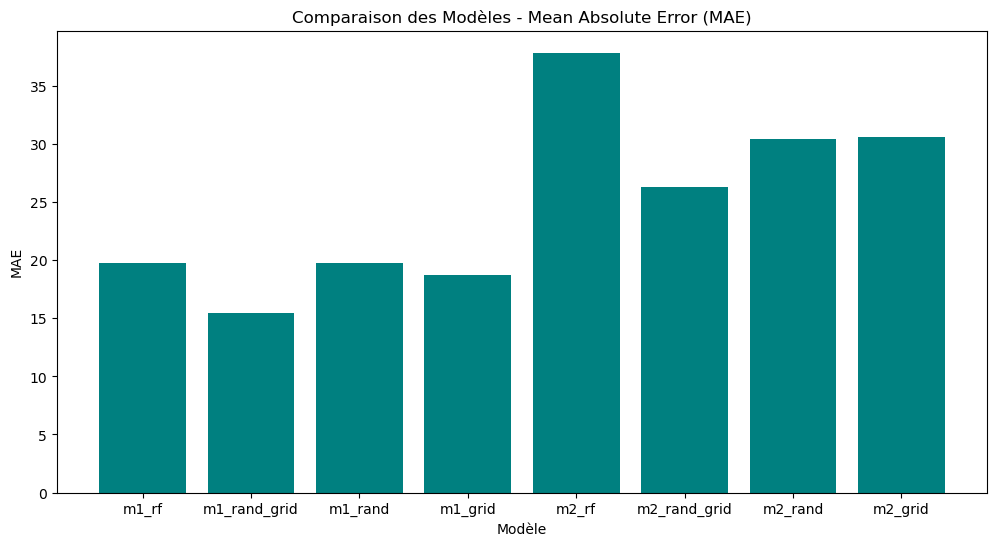

In [82]:
# Comparaison des scores MAE
plt.figure(figsize=(12, 6))
plt.bar(models, mae_scores, color='teal')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.title('Comparaison des Modèles - Mean Absolute Error (MAE)')
plt.show()

C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\2481819343.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\2481819343.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\2481819343.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Modèle', data=df_scores_sorted, palette='viridis')
C:\Users\a.v

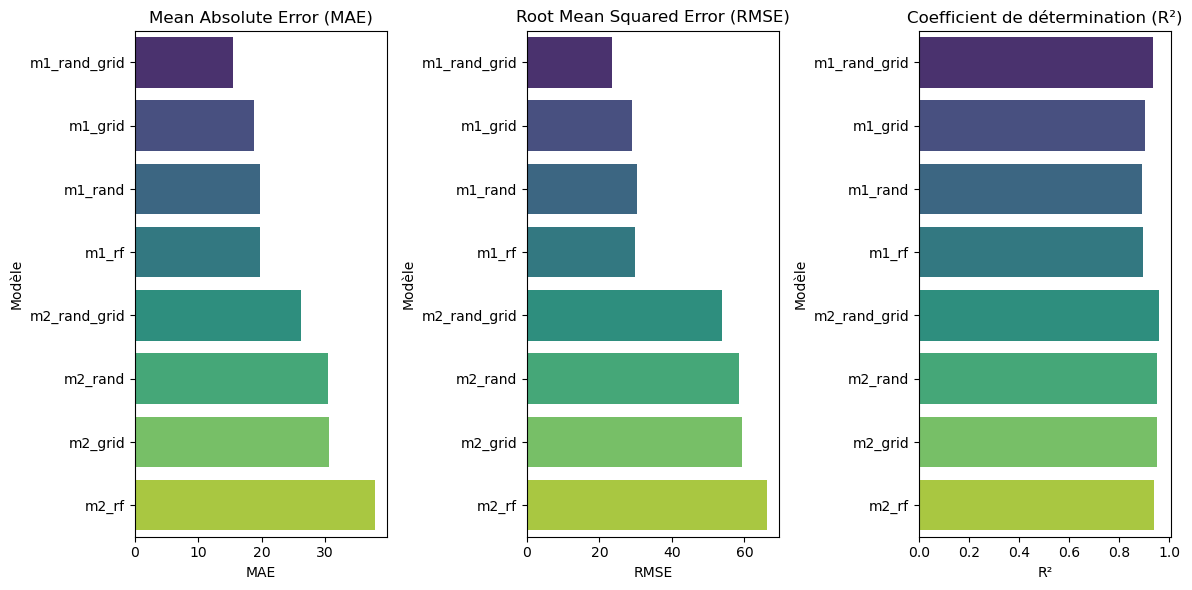

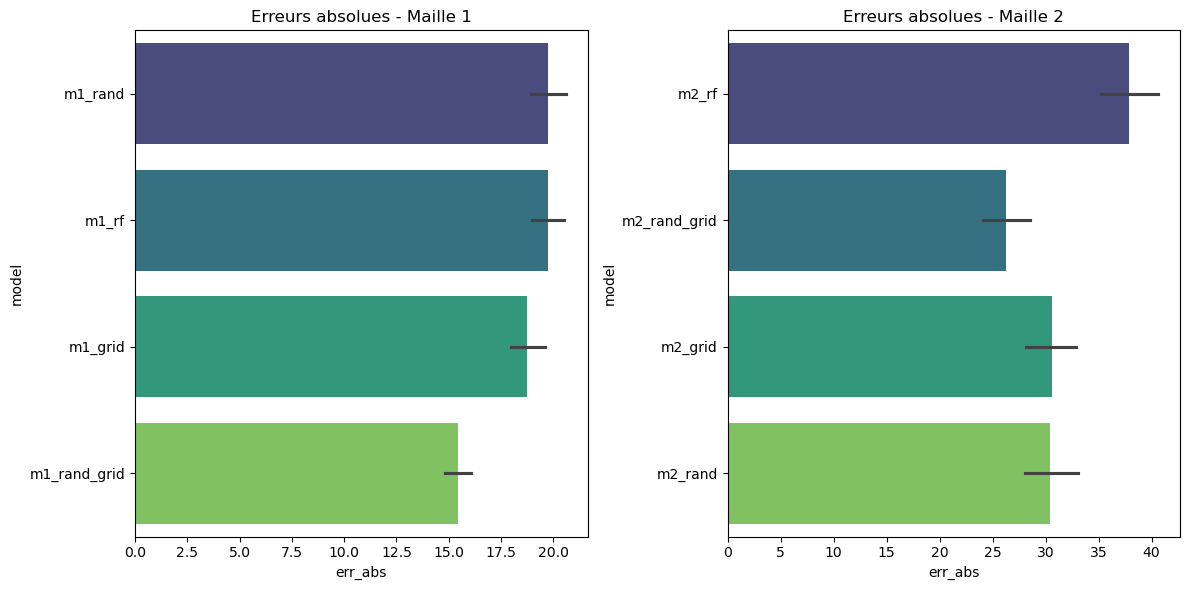

In [83]:
# Visualisation des scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted, palette='viridis')
plt.title("Mean Absolute Error (MAE)")

plt.subplot(1, 3, 2)
sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted, palette='viridis')
plt.title("Root Mean Squared Error (RMSE)")

plt.subplot(1, 3, 3)
sns.barplot(x='R²', y='Modèle', data=df_scores_sorted, palette='viridis')
plt.title("Coefficient de détermination (R²)")

plt.tight_layout()

# Comparaison des erreurs absolues
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='err_abs', y='model', data=all_best_rf_results, palette='viridis')
plt.title("Erreurs absolues - Maille 1")

plt.subplot(1, 2, 2)
sns.barplot(x='err_abs', y='model', data=all_best_rf_results2, palette='viridis')
plt.title("Erreurs absolues - Maille 2")

plt.tight_layout()

### Recherche erreurs ###

In [84]:
# Filtrer les observations avec des erreurs absolues élevées
high_error_threshold = 100
df_high_errors = all_best_rf_results[all_best_rf_results['err_abs'] > high_error_threshold]

# Résumé statistique des observations à haute erreur
summary_high_errors = df_high_errors.describe()

# Nombre total de voyages avec des erreurs absolues élevées
num_high_errors = len(df_high_errors)

print(f"Nombre de voyages avec une erreur absolue > {high_error_threshold} : {num_high_errors}")
print("Résumé statistique des observations avec des erreurs élevées :")
summary_high_errors

Nombre de voyages avec une erreur absolue > 100 : 121
Résumé statistique des observations avec des erreurs élevées :


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.000000,121.0,121.0,121.000000,121.0,121.0,121.0,121.000000,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.000000,121.0,121.0,121.0,121.0,121.0,121.000000,121.0,121.0,121.0,121.000000,121.0,121.000000,121.0,121.000000,121.0,121.0,121.000000,121.0,121.0,121.000000,121.0,121.0,121.000000,121.0,121.0,121.0,121.0,121.000000,121.0,121.0,121.0,121.0,121.0,121.000000,121.0,121.000000,121.0,121.0,121.0,121.0,121.0,121.0,121.0,121.000000,121.000000,121.0,121.0,121.000000,121.0,121.0,121.0,121.0,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,204.388430,92.057851,42.925620,17.388430,7.652893,1.438017,0.066116,184.740260,108.292798,17.495868,8.933884,5.801653,5.685950,27.570248,14.942149,5.760331,6.190083,2.644628,0.123967,487.892562,255.909091,93.355372,89.694215,55.495868,30.355372,1.702479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049587,0.0,0.0,0.173554,0.0,0.0,0.0,0.033058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016529,0.0,0.0,0.0,0.0,0.0,0.016529,0.0,0.0,0.0,0.057851,0.0,0.024793,0.0,0.115702,0.0,0.0,0.008264,0.0,0.0,0.033058,0.0,0.0,0.082645,0.0,0.0,0.0,0.0,0.024793,0.0,0.0,0.0,0.0,0.0,0.198347,0.0,0.024793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.016529,0.0,0.0,0.024793,0.0,0.0,0.0,0.0,0.041322,330.710744,209.784814,133.504868,567.008264,480.341204
std,35.389822,88.332355,49.061384,21.085292,9.701126,3.530563,0.335051,277.391042,240.382347,22.577690,15.486411,14.375685,14.695256,26.840214,17.545321,9.485976,13.561166,5.284978,0.713796,491.134194,278.356306,99.735639,114.020747,82.916637,44.486863,0.781501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217992,0.0,0.0,0.380300,0.0,0.0,0.0,0.179531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128028,0.0,0.0,0.0,0.0,0.0,0.128028,0.0,0.0,0.0,0.234433,0.0,0.156141,0.0,0.321198,0.0,0.0,0.090909,0.0,0.0,0.179531,0.0,0.0,0.276489,0.0,0.0,0.0,0.0,0.156141,0.0,0.0,0.0,0.0,0.0,0.400413,0.0,0.156141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.128028,0.0,0.0,0.156141,0.0,0.0,0.0,0.0,0.199862,158.896373,117.788837,39.343975,305.776157,75.645032
min,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0

In [85]:
df_high_errors = df_high_errors.sort_values(by='err_abs', ascending=False)
df_high_errors.head()

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err,model
6010,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,341.778303,285.221697,1069.0,731.0,m1_rand
0,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,353.893173,273.106827,1069.0,731.0,m1_rf
9015,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,369.456967,257.543033,1069.0,731.0,m1_grid
6011,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,354.208663,251.791337,880.0,609.0,m1_rand
9016,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,356.916147,249.083853,880.0,609.0,m1_grid


In [86]:
# Filtrer les observations avec des erreurs absolues élevées
high_error_threshold2 = 100
df_high_errors2 = all_best_rf_results2[all_best_rf_results2['err_abs'] > high_error_threshold2]

# Résumé statistique des observations à haute erreur
summary_high_errors2 = df_high_errors2.describe()

# Nombre total de voyages avec des erreurs absolues élevées
num_high_errors2 = len(df_high_errors2)

print(f"Nombre de voyages avec une erreur absolue > {high_error_threshold2} : {num_high_errors2}")
print("Résumé statistique des observations avec des erreurs élevées :")
summary_high_errors2

Nombre de voyages avec une erreur absolue > 100 : 438
Résumé statistique des observations avec des erreurs élevées :


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
count,438.00000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.0,438.000000,438.0,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,204.86758,222.100457,120.892694,57.310502,26.301370,7.769406,0.719178,382.410307,229.445532,69.933790,35.050228,23.614155,19.570776,44.979452,36.036530,19.824201,12.769406,8.079909,2.497717,317.013699,234.372146,129.410959,89.742009,80.127854,35.068493,4.269406,0.189498,0.0,0.025114,0.0,0.031963,0.162100,0.486301,718.550228,681.003485,181.488231,1100.244292,981.952055
std,38.57657,188.878792,111.412093,56.591753,29.259129,11.298904,2.362202,468.162357,345.714203,123.038822,41.703346,40.781434,41.903816,39.451294,36.638047,21.769831,17.768130,13.856093,6.825966,271.067277,205.885687,111.899412,87.415652,102.086929,54.817065,1.632206,0.392352,0.0,0.156651,0.0,0.176104,0.368964,0.500384,417.128822,397.031711,80.839937,798.092977,226.861151
min,111.00000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,66.000000,61.450644,100.012829,0.000000,660.000000
25%,176.00000,89.000000,42.000000,15.250000,6.000000,0.000000,0.000000,82.000000,42.500000,16.000000,8.000000,2.000000,0.000000,14.000000,11.000000,5.000000,4.000000,0.000000,0.000000,104.250000,83.250000,38.250000,31.250000,21.000000,0.000000,3.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,397.000000,385.281436,119.849175,497.000000,810.250000
50%,212.00000,178.000000,94.000000,44.000000,17.000000,3.000000,0.000000,210.857143,103.000000,49.000000,22.000000,8.000000,1.000000,35.000000,22.000000,12.000000,8.000000,4.000000,0.000000,230.500000,160.000000,106.000000,63.500000,55.000000,12.000000,4.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,612.000000,595.876697,152.460478,1018.500000,929.000000
75%,237.00000,257.000000,148.000000,71.000000,33.750000,10.000000,0.000000,471.714286,233.000000,86.000000,41.750000,26.000000,24.000000,63.750000,57.000000,24.750000,16.000000,9.000000,1.000000,454.000000,349.000000,192.750000,123.000000,103.000000,51.000000,5.750000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,993.000000,890.165724,225.948147,1615.000000,1122.000000
max,279.00000,991.000000,588.000000,339.000000,167.000000,58.000000,18.000000,2795.571429,2761.000000,1346.000000,280.000000,289.000000,289.000000,200.000000,232.000000,124.000000,153.000000,83.000000,39.000000,1667.000000,1301.000000,604.000000,580.000000,771.000000,424.000000,8.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,2058.000000,2039.851236,533.408366,3307.000000,2034.000000


In [87]:
df_high_errors2 = df_high_errors2.sort_values(by='err_abs', ascending=False)
df_high_errors2.head()

,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err,model
0,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,465.591634,533.408366,0.0,2034.0,m2_rf
1584,155,164.0,107.0,57.0,11.0,0.0,0.0,95.0,79.0,78.0,79.0,79.0,79.0,7.0,5.0,0.0,0.0,0.0,0.0,29.0,30.0,27.0,12.0,12.0,6.0,2,0,0,0,0,0,1,0,293.0,786.248774,493.248774,435.0,2034.0,m2_rand_grid
4752,149,135.0,60.0,22.0,4.0,0.0,0.0,122.0,94.0,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,517.138411,481.861589,0.0,2034.0,m2_grid
3168,241,753.0,376.0,146.0,93.0,32.0,2.0,753.0,269.0,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1611.699033,446.300967,3307.0,2034.0,m2_rand
1,216,238.0,82.0,44.0,15.0,5.0,0.0,159.0,51.0,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,572.523609,434.476391,1750.0,1470.0,m2_rf


### Visualisation ###

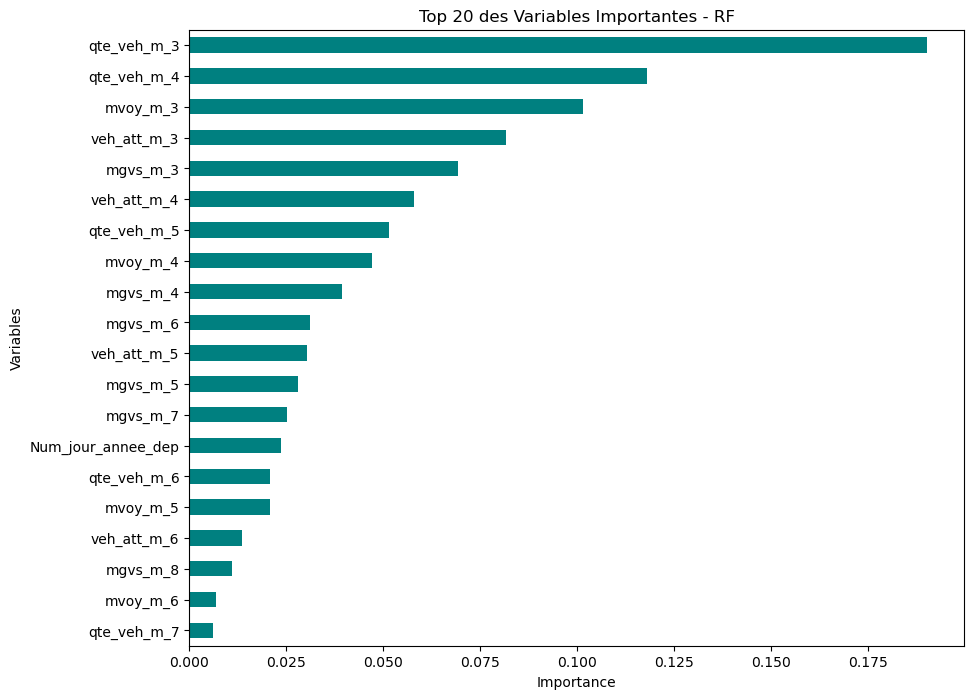

In [88]:
# Extraire et trier les importances
importances = rf_model_m1.feature_importances_
features = X_train.columns
feature_importances = pd.Series(importances, index=features)
feature_importances = feature_importances.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

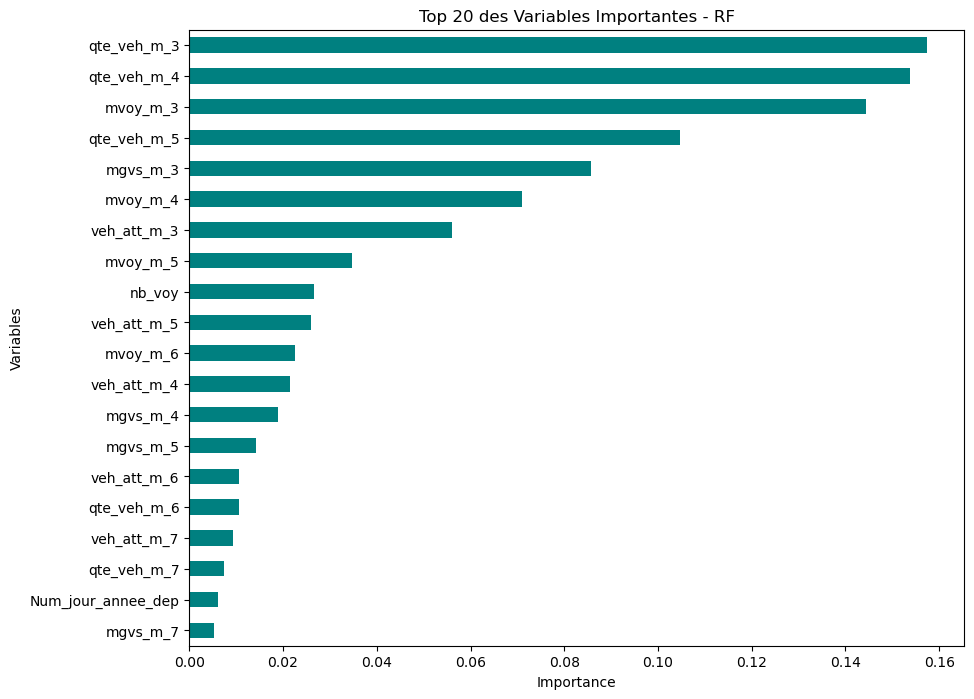

In [89]:
# Extraire et trier les importances
importances2 = rf_model_m2.feature_importances_
features2 = X_train2.columns
feature_importances2 = pd.Series(importances2, index=features2)
feature_importances2 = feature_importances2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

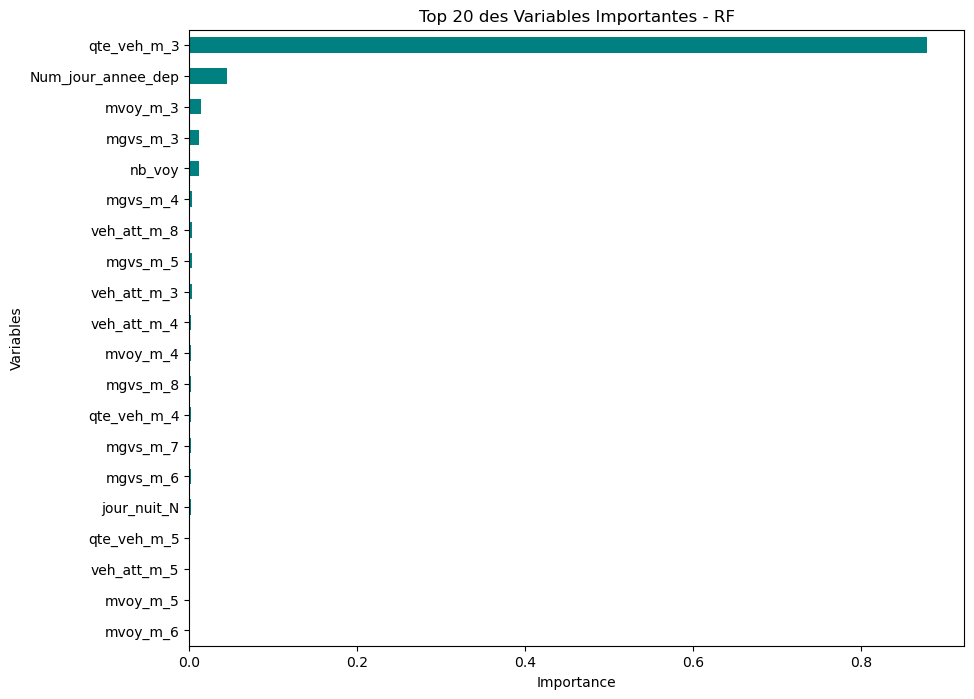

In [90]:
# Extraire et trier les importances
importances_best_m1 = best_rf_model_m1.feature_importances_
features_best_m1 = X_train.columns
feature_importances_best_m1 = pd.Series(importances_best_m1, index=features_best_m1)
feature_importances_best_m1 = feature_importances_best_m1.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m1.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

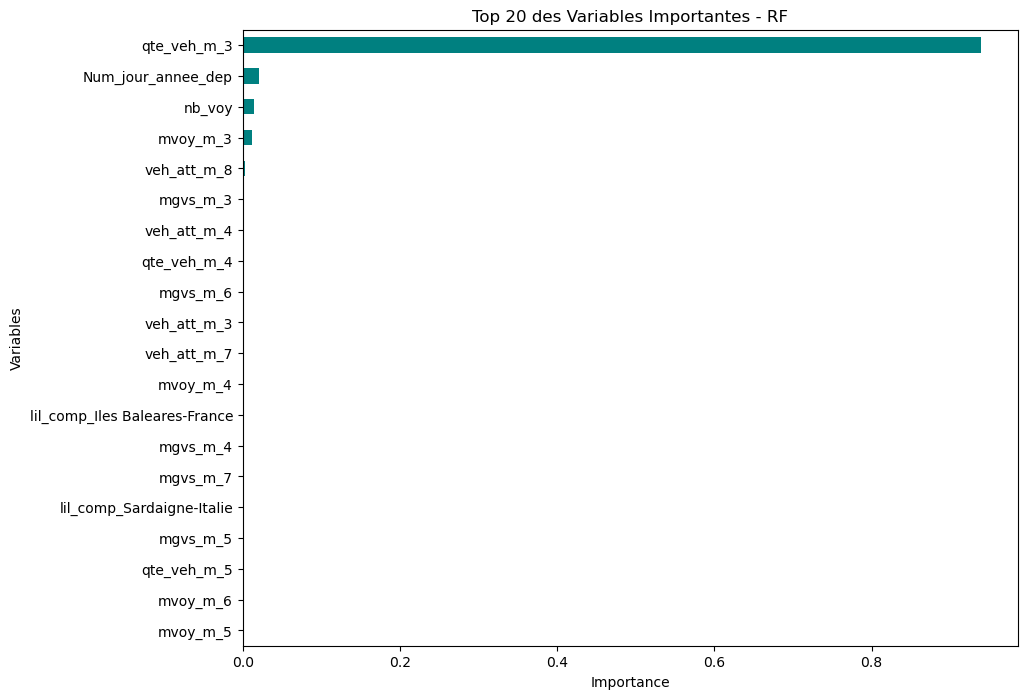

In [91]:
# Extraire et trier les importances
importances_best_m2 = best_rf_model_m2.feature_importances_
features_best_m2 = X_train2.columns
feature_importances_best_m2 = pd.Series(importances_best_m2, index=features_best_m2)
feature_importances_best_m2 = feature_importances_best_m2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

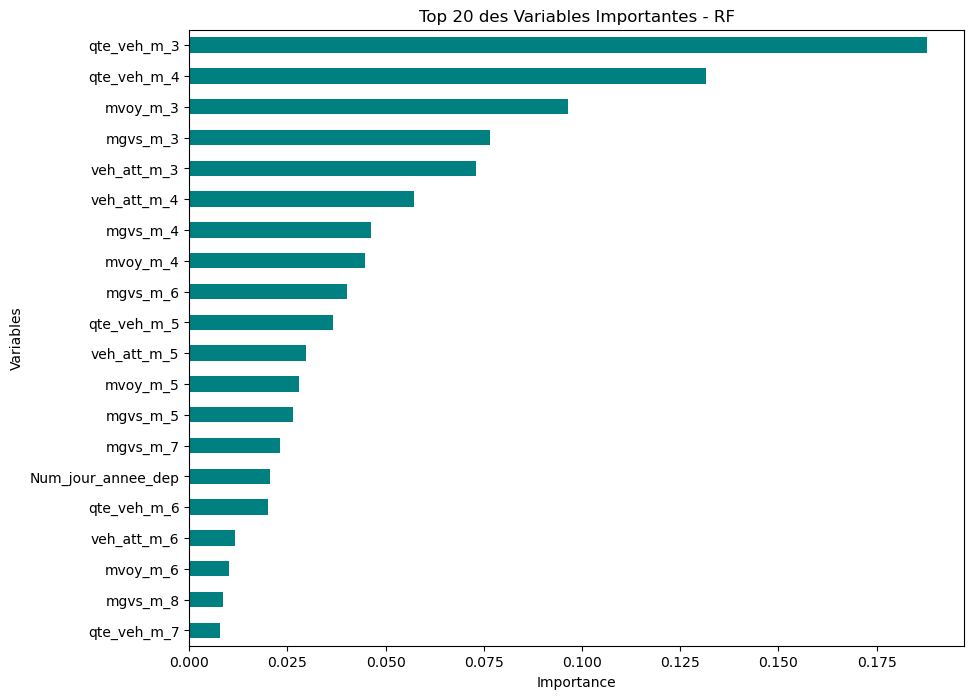

In [92]:
# Extraire et trier les importances
importances_best_m1_2 = best_rf_model_m1_2.feature_importances_
features_best_m1_2 = X_train.columns
feature_importances_best_m1_2 = pd.Series(importances_best_m1_2, index=features_best_m1_2)
feature_importances_best_m1_2 = feature_importances_best_m1_2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m1_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

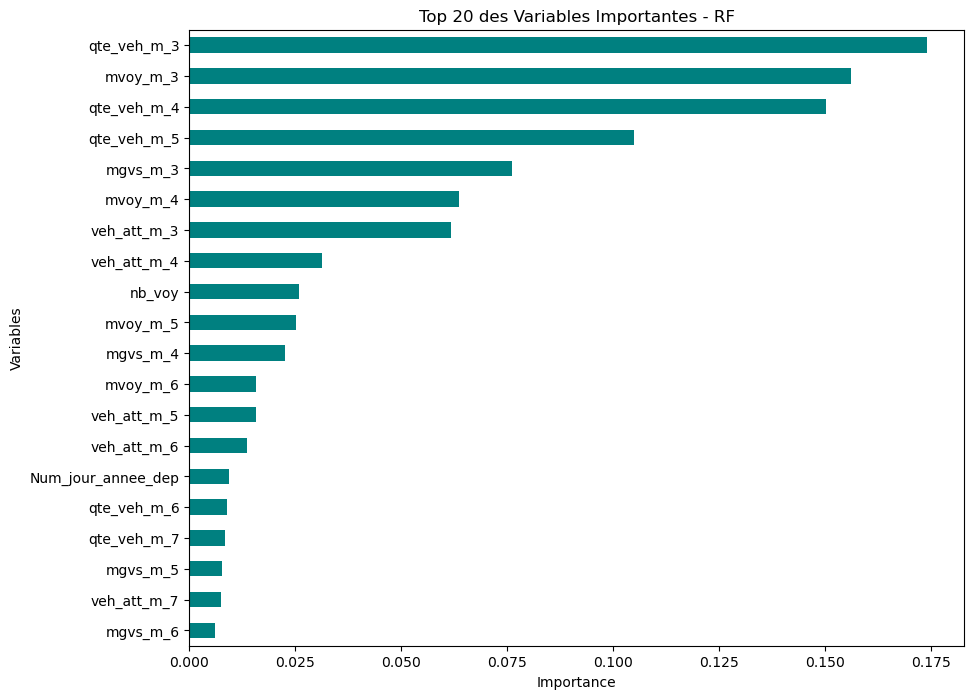

In [93]:
# Extraire et trier les importances
importances_best_m2_2 = best_rf_model_m2_2.feature_importances_
features_best_m2_2 = X_train2.columns
feature_importances_best_m2_2 = pd.Series(importances_best_m2_2, index=features_best_m2_2)
feature_importances_best_m2_2 = feature_importances_best_m2_2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m2_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

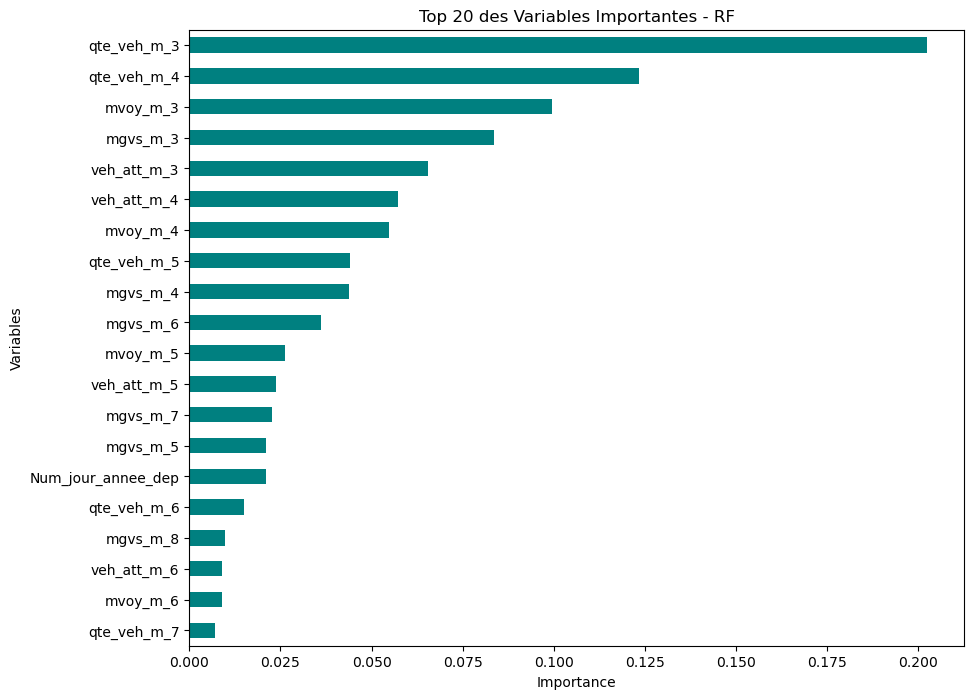

In [94]:
# Extraire et trier les importances
importances_best_m1_3 = best_rf_model_m1_3.feature_importances_
features_best_m1_3 = X_train.columns
feature_importances_best_m1_3 = pd.Series(importances_best_m1_3, index=features_best_m1_3)
feature_importances_best_m1_3 = feature_importances_best_m1_3.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m1_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

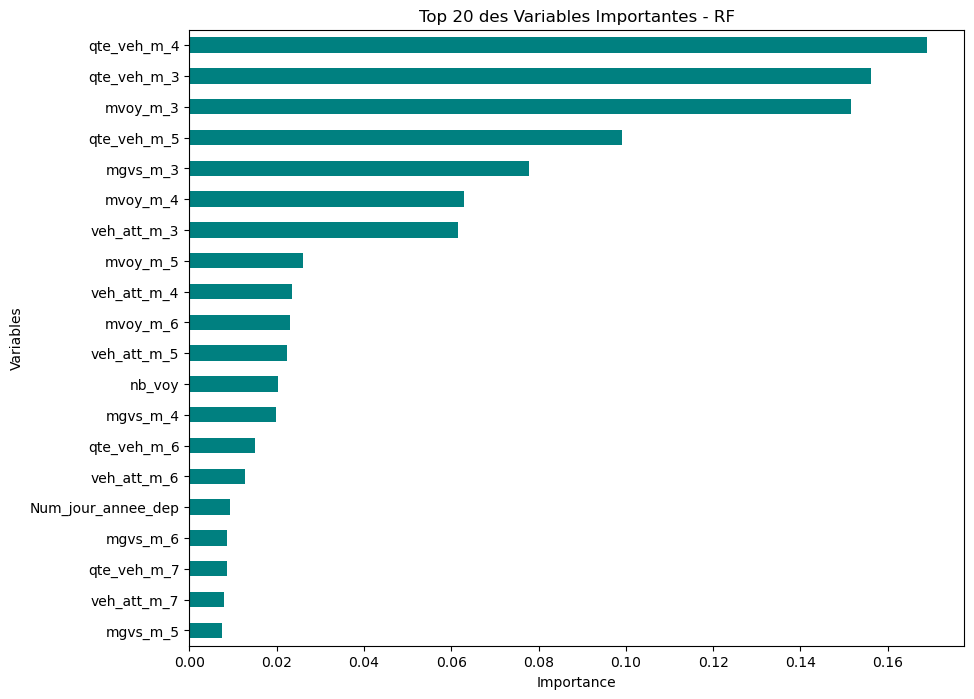

In [95]:
# Extraire et trier les importances
importances_best_m2_3 = best_rf_model_m2_3.feature_importances_
features_best_m2_3 = X_train2.columns
feature_importances_best_m2_3 = pd.Series(importances_best_m2_3, index=features_best_m2_3)
feature_importances_best_m2_3 = feature_importances_best_m2_3.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_best_m2_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - RF")
plt.gca().invert_yaxis() # Pour que la variable la plus importante soit en haut
plt.show()

### XGBoost ###

#### Maille 1 ####

In [134]:
# XGBoost
from xgboost import XGBRegressor

# Initialiser le modèle XGBoost de base
xgb_model = XGBRegressor(n_estimators=100, 
                         max_depth=5, 
                         learning_rate=0.1, 
                         subsample=0.8, 
                         colsample_bytree=0.8, 
                         random_state=42, 
                         verbosity=1)

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Effectuer la validation croisée
cv_results_xgb = cross_validate(xgb_model, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats pour chaque métrique
print("Résultats de validation croisée :")
print(f"MAE moyen : {-np.mean(cv_results_xgb['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_xgb['test_MSE']):.2f}")
Mse_test_xgb = -np.mean(cv_results_xgb['test_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_test_xgb):.2f}")
print(f"R² moyen : {np.mean(cv_results_xgb['test_R2']):.3f}")

# Résultats données entrainement
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_xgb['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_xgb['train_MSE']):.2f}")
Mse_train_xgb = -np.mean(cv_results_xgb['train_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_train_xgb):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_xgb['train_R2']):.3f}")

Résultats de validation croisée :
MAE moyen : 15.41
RMSE moyen : 23.28
R² moyen : 0.933
MAE moyen (entraînement) : 12.81
RMSE moyen : 18.81
R² moyen (entraînement) : 0.956


In [135]:
### Entrainement avec validation croisée temporelle: ###

# Nombre de splits pour la validation croisée temporelle
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_xgb, rmse_scores_xgb, r2_scores_xgb, mape_scores_xgb, mape_filtered_scores_xgb = [], [], [], [], []

# Ajouter les erreurs pour chaque split
all_results_xgb = []

for train_index_xgb, test_index_xgb in tscv.split(X):
    X_train_cross_xgb, X_test_cross_xgb = X.iloc[train_index_xgb], X.iloc[test_index_xgb]
    y_train_cross_xgb, y_test_cross_xgb = y.iloc[train_index_xgb], y.iloc[test_index_xgb]
    
    # Entraîner le modèle
    xgb_model.fit(X_train_cross_xgb, y_train_cross_xgb)
    
    # Faire des prédictions
    y_pred_cross_val_xgb = xgb_model.predict(X_test_cross_xgb)
    
    # Calcul des métriques
    mae_scores_xgb.append(mean_absolute_error(y_test_cross_xgb, y_pred_cross_val_xgb))
    rmse_scores_xgb.append(np.sqrt(mean_squared_error(y_test_cross_xgb, y_pred_cross_val_xgb)))
    r2_scores_xgb.append(r2_score(y_test_cross_xgb, y_pred_cross_val_xgb))
    mape_scores_xgb.append(np.mean(np.abs((y_test_cross_xgb - y_pred_cross_val_xgb) / y_test_cross_xgb)) * 100)
    
    # Filtrer et recalculer le MAPE pour les valeurs positives
    y_test_filtered_xgb = y_test_cross_xgb[y_test_cross_xgb > 0]
    y_pred_filtered_xgb = y_pred_cross_val_xgb[y_test_cross_xgb > 0]
    mape_filtered_scores_xgb.append(np.mean(np.abs((y_test_filtered_xgb - y_pred_filtered_xgb) / y_test_filtered_xgb)) * 100)

    # Calculer l'erreur absolue pour ce split
    df_split_results_xgb = X_test_cross_xgb.copy()
    df_split_results_xgb['y_test'] = y_test_cross
    df_split_results_xgb['y_pred'] = y_pred_cross_val_xgb
    df_split_results_xgb['err-abs'] = abs(y_test_cross - y_pred_cross_val_xgb)
    all_results_xgb.append(df_split_results_xgb)

# Résultats moyens
print(f"MAE moyen sur les {n_splits} splits : {np.mean(mae_scores_xgb):.2f}")
print(f"RMSE moyen sur les {n_splits} splits : {np.mean(rmse_scores_xgb):.2f}")
print(f"R² moyen sur les {n_splits} splits : {np.mean(r2_scores_xgb):.4f}")
# print(f"MAPE moyen sur les {n_splits} splits : {np.mean(mape_scores_xgb):.2f}%")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_xgb):.2f}%")

MAE moyen sur les 5 splits : 25.29
RMSE moyen sur les 5 splits : 34.50
R² moyen sur les 5 splits : 0.7541
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 68.42%


In [136]:
# Entraînement final sur tout l'ensemble d'entrainement 
xgb_model.fit(X_train, 
              y_train, 
              eval_set=[(X_test, y_test)], # Set de validation
              eval_metric="mae",  # Métrique utilisée pour l'early stopping
              early_stopping_rounds=50,  # Stopper si pas d'amélioration après 50 itérations
              verbose=True)

# Faire des prédictions sur l'ensemble de test
y_pred_xgb = xgb_model.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
xgb_results = X_test.copy()
# Ajouter les valeurs réelles
xgb_results['y_test'] = y_test 
# Ajouter les prédictions
xgb_results['y_pred'] = y_pred_xgb
# Calculer l'erreur absolue 
xgb_results['err_abs'] = abs(xgb_results['y_test'] - xgb_results['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
xgb_results['oveh'] = df_maille_aggregee2['oveh']
xgb_results['abs-err'] = df_maille_aggregee2['abs-err']
xgb_results['nb_voy'] = df_maille_aggregee2['nb_voy']

# Évaluer la performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"Mean Absolute Error (MAE) : {mae_xgb}")
print(f"Root Mean Squared Error (RMSE) : {rmse_xgb}")
print(f"Coefficient de détermination (R²) : {r2_xgb}")
# print(f"Mean Absolute Percentage Error (MAPE)  : {mape_xgb:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_xgb = y_test[y_test > 0]
y_pred_filtered_xgb = y_pred_xgb[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_xgb = np.mean(np.abs((y_test_filtered_xgb - y_pred_filtered_xgb) / y_test_filtered_xgb)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_xgb:.2f}%")

Mean Absolute Error (MAE) : 15.1003558332928
Root Mean Squared Error (RMSE) : 22.208702318406782
Coefficient de détermination (R²) : 0.9419022343261656
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 52.91%


In [137]:
# Évaluer la performance sur l'ensemble d'entraînement
y_train_xgb = xgb_model.predict(X_train)

mae_train_xgb = mean_absolute_error(y_train, y_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_xgb))
r2_train_xgb = r2_score(y_train, y_train_xgb)

print(f"Random XGBoost (Entraînement) - MAE : {mae_train_xgb}")
print(f"Random XGBoost (Entraînement) - RMSE : {rmse_train_xgb}")
print(f"Random XGBoost (Entraînement) - R² : {r2_train_xgb}")

Random XGBoost (Entraînement) - MAE : 13.145552695100077
Random XGBoost (Entraînement) - RMSE : 19.387034908298357
Random XGBoost (Entraînement) - R² : 0.953755312832056


In [138]:
# Trier les résultats par erreur absolue décroissante
xgb_results =xgb_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle1 XGBoost")
xgb_results.head()

Top erreurs absolues - Modèle1 XGBoost


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.000000,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,87.751289,125.248711,521.0,434.0
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,65.518707,117.481293,303.0,176.0
6333,181,2.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152.0,40.614120,111.385880,148.0,102.0
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.000000,19.0,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,84.691208,108.308792,NaN,NaN
11839,255,4.0,0.0,0.0,0.0,0.0,0.0,109.142857,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150.0,48.681740,101.318260,NaN,NaN


In [139]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_results['err_abs'] = xgb_results['err_abs'].sort_values(ascending=False).values
xgb_results['abs-err'] = xgb_results['abs-err'].sort_values(ascending=False).values

In [140]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle1 XGBoost")
xgb_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle1 XGBoost


,y_test,y_pred,err_abs,abs-err,oveh
6334,213.0,87.751289,125.248711,2087.0,521.0
4536,183.0,65.518707,117.481293,2034.0,303.0
6333,152.0,40.614120,111.385880,1675.0,148.0
11289,193.0,84.691208,108.308792,1606.0,NaN
11839,150.0,48.681740,101.318260,1469.0,NaN


#### Maille 2 ####

In [291]:
# XGBoost 
from xgboost import XGBRegressor

# Initialiser le modèle XGBoost de base 
xgb_model2 = XGBRegressor(n_estimators=700, # Augmenter le nombre d’arbres
                          max_depth=2, #  Profondeur plus faible
                          learning_rate=0.05, # Apprentissage plus lent
                          subsample=0.7, # Réduction des données par arbre
                          colsample_bytree=0.7, # Moins de variables par arbre
                          reg_alpha=0.5,  # Régularisation L1
                          reg_lambda=0.5, # Régularisation L2
                          random_state=42, 
                          verbosity=1)

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Effectuer la validation croisée 
cv_results_xgb2 = cross_validate(xgb_model2, X_train2, y_train2, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats pour chaque métrique
print("Résultats de validation croisée :")
print(f"MAE moyen : {-np.mean(cv_results_xgb2['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_xgb2['test_MSE']):.2f}")
Mse_test_xgb2 = -np.mean(cv_results_xgb2['test_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_test_xgb2):.2f}")
print(f"R² moyen : {np.mean(cv_results_xgb2['test_R2']):.3f}")

# Résultats données entraînement 
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_xgb2['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_xgb2['train_MSE']):.2f}")
Mse_train_xgb2 = -np.mean(cv_results_xgb2['train_MSE'])
print(f"RMSE moyen : {np.sqrt(Mse_train_xgb2):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_xgb2['train_R2']):.3f}")

Résultats de validation croisée :
MAE moyen : 24.89
RMSE moyen : 43.36
R² moyen : 0.977
MAE moyen (entraînement) : 20.77
RMSE moyen : 32.60
R² moyen (entraînement) : 0.987


In [292]:
### Validation croisée temporelle ###

# Nombre de splits pour la validation croisée temporelle
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_xgb2, rmse_scores_xgb2, r2_scores_xgb2, mape_scores_xgb2, mape_filtered_scores_xgb2 = [], [], [], [], []
all_results_xgb2 = []

for train_index_xgb2, test_index_xgb2 in tscv.split(X2):
    X_train_cross_xgb2, X_test_cross_xgb2 = X2.iloc[train_index_xgb2], X2.iloc[test_index_xgb2]
    y_train_cross_xgb2, y_test_cross_xgb2 = y2.iloc[train_index_xgb2], y2.iloc[test_index_xgb2]
    
    # Entraîner le modèle 
    xgb_model2.fit(X_train_cross_xgb2, y_train_cross_xgb2)
    
    # Faire des prédictions 
    y_pred_cross_val_xgb2 = xgb_model2.predict(X_test_cross_xgb2)
    
    # Calcul des métriques 
    mae_scores_xgb2.append(mean_absolute_error(y_test_cross_xgb2, y_pred_cross_val_xgb2))
    rmse_scores_xgb2.append(np.sqrt(mean_squared_error(y_test_cross_xgb2, y_pred_cross_val_xgb2)))
    r2_scores_xgb2.append(r2_score(y_test_cross_xgb2, y_pred_cross_val_xgb2))
    mape_scores_xgb2.append(np.mean(np.abs((y_test_cross_xgb2 - y_pred_cross_val_xgb2) / y_test_cross_xgb2)) * 100)
    
    # Filtrer les valeurs positives et recalculer le MAPE
    y_test_filtered_xgb2 = y_test_cross_xgb2[y_test_cross_xgb2 > 0]
    y_pred_filtered_xgb2 = y_pred_cross_val_xgb2[y_test_cross_xgb2 > 0]
    mape_filtered_scores_xgb2.append(np.mean(np.abs((y_test_filtered_xgb2 - y_pred_filtered_xgb2) / y_test_filtered_xgb2)) * 100)

    # Calculer l'erreur absolue pour ce split
    df_split_results_xgb2 = X_test_cross_xgb2.copy()
    df_split_results_xgb2['y_test'] = y_test_cross_xgb2
    df_split_results_xgb2['y_pred'] = y_pred_cross_val_xgb2
    df_split_results_xgb2['err-abs'] = abs(y_test_cross_xgb2 - y_pred_cross_val_xgb2)
    all_results_xgb2.append(df_split_results_xgb2)

# Résultats moyens 
print(f"MAE moyen sur les {n_splits} splits  : {np.mean(mae_scores_xgb2):.2f}")
print(f"RMSE moyen sur les {n_splits} splits  : {np.mean(rmse_scores_xgb2):.2f}")
print(f"R² moyen sur les {n_splits} splits  : {np.mean(r2_scores_xgb2):.4f}")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_xgb2):.2f}%")

MAE moyen sur les 5 splits  : 49.28
RMSE moyen sur les 5 splits  : 87.20
R² moyen sur les 5 splits  : 0.7442
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 125.08%


In [293]:
# Entraînement final sur tout l'ensemble d'entraînement 
xgb_model2.fit(X_train2, 
               y_train2,
               eval_set=[(X_test2, y_test2)], # Set de validation
               eval_metric="mae",  # Métrique utilisée pour l'early stopping
               early_stopping_rounds=50,  # Stopper si pas d'amélioration après 50 itérations
               verbose=True)

# Faire des prédictions sur l'ensemble de test 
y_pred_xgb2 = xgb_model2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2
xgb_results2 = X_test2.copy()
xgb_results2['y_test'] = y_test2
xgb_results2['y_pred'] = y_pred_xgb2
xgb_results2['err_abs'] = abs(xgb_results2['y_test'] - xgb_results2['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_results2['oveh'] = df_maille_aggregee2['oveh']
xgb_results2['abs-err'] = df_maille_aggregee2['abs-err']
xgb_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

# Évaluer la performance
mae_xgb2 = mean_absolute_error(y_test2, y_pred_xgb2)
rmse_xgb2 = np.sqrt(mean_squared_error(y_test2, y_pred_xgb2))
r2_xgb2 = r2_score(y_test2, y_pred_xgb2)
mape_xgb2 = np.mean(np.abs((y_test2 - y_pred_xgb2) / y_test2)) * 100

print(f"Mean Absolute Error (MAE) : {mae_xgb2}")
print(f"Root Mean Squared Error (RMSE) : {rmse_xgb2}")
print(f"Coefficient de détermination (R²) : {r2_xgb2}")
# print(f"Mean Absolute Percentage Error (MAPE)  : {mape_xgb2:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_xgb2 = y_test2[y_test2 > 0]
y_pred_filtered_xgb2 = y_pred_xgb2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_xgb2 = np.mean(np.abs((y_test_filtered_xgb2 - y_pred_filtered_xgb2) / y_test_filtered_xgb2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_xgb2:.2f}%")

Mean Absolute Error (MAE) : 24.759244638984327
Root Mean Squared Error (RMSE) : 45.926929601130205
Coefficient de détermination (R²) : 0.9706374950259747
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 91.88%


In [294]:
# Évaluer la performance sur l'ensemble d'entraînement
y_train_xgb2 = xgb_model2.predict(X_train2)

mae_train_xgb2 = mean_absolute_error(y_train2, y_train_xgb2)
rmse_train_xgb2 = np.sqrt(mean_squared_error(y_train2, y_train_xgb2))
r2_train_xgb2 = r2_score(y_train2, y_train_xgb2)

print(f"XGBoost (Entraînement) - MAE : {mae_train_xgb2}")
print(f"XGBoost (Entraînement) - RMSE : {rmse_train_xgb2}")
print(f"XGBoost (Entraînement) - R² : {r2_train_xgb2}")

XGBoost (Entraînement) - MAE : 21.21663747844334
XGBoost (Entraînement) - RMSE : 33.55637412016413
XGBoost (Entraînement) - R² : 0.986208243849839


In [295]:
# Trier les résultats pour chaque colonne de manière décroissante
xgb_results2 = xgb_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 XGBoost")
xgb_results2.head()

Top erreurs absolues - Modèle2 XGBoost


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1836.593750,469.593750,515.0,443.714286
5428,239,429.0,202.0,83.0,50.0,10.0,1.0,429.000000,132.000000,52.0,35.0,21.0,21.0,79.0,32.0,20.0,9.0,4.0,0.0,379.0,217.0,149.0,61.0,35.0,82.0,8,0,0,0,0,0,0,0,1070.0,1467.920532,397.920532,2084.0,1305.000000
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1840.367920,397.367920,1657.0,1434.000000
5411,238,255.0,128.0,43.0,22.0,3.0,0.0,255.000000,128.000000,43.0,22.0,3.0,0.0,100.0,61.0,23.0,10.0,15.0,0.0,694.0,326.0,241.0,137.0,113.0,0.0,7,0,0,0,0,0,0,0,706.0,1039.428101,333.428101,1783.0,994.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,681.181274,325.818726,1750.0,823.000000


In [296]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_results2['err_abs'] = xgb_results2['err_abs'].sort_values(ascending=False).values
xgb_results2['abs-err'] = xgb_results2['abs-err'].sort_values(ascending=False).values

In [297]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle2 XGBoost")
xgb_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle2 XGBoost


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1836.593750,469.593750,2034.0,515.0
5428,1070.0,1467.920532,397.920532,1470.0,2084.0
5218,1443.0,1840.367920,397.367920,1457.0,1657.0
5411,706.0,1039.428101,333.428101,1444.0,1783.0
4710,1007.0,681.181274,325.818726,1441.0,1750.0


### XGB RandomizedSearch + GridSearch ###

#### Maille 1 ####

In [298]:
# Définir la grille de paramètres
param_random_XGB = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.5, 0.6, 0.7],
    'reg_lambda': [0.5, 0.6, 0.7]
}

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_XGB,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_xgb.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour XGBoost :", random_search_xgb.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.8, 'reg_lambda': 0.6, 'reg_alpha': 0.7, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [ ]:
# Ajuster autour des meilleurs paramètres trouvés
param_grid_XGB = {
    'n_estimators': [random_search_xgb.best_params_['n_estimators'] - 50,
                     random_search_xgb.best_params_['n_estimators'],
                     random_search_xgb.best_params_['n_estimators'] + 50],
    'max_depth': [random_search_xgb.best_params_['max_depth'] - 1,
                  random_search_xgb.best_params_['max_depth'],
                  random_search_xgb.best_params_['max_depth'] + 1],
    'learning_rate': [random_search_xgb.best_params_['learning_rate'] * 0.5,
                      random_search_xgb.best_params_['learning_rate'],
                      random_search_xgb.best_params_['learning_rate'] * 1.5],
    'subsample': [random_search_xgb.best_params_['subsample'] * 0.5,
                  random_search_xgb.best_params_['subsample'],
                  random_search_xgb.best_params_['subsample'] * 1.5],
    'colsample_bytree': [random_search_xgb.best_params_['colsample_bytree'] * 0.5,
                         random_search_xgb.best_params_['colsample_bytree'],
                         random_search_xgb.best_params_['colsample_bytree'] * 1.5],
    'reg_alpha': [random_search_xgb.best_params_['reg_alpha'] * 0.5,
                  random_search_xgb.best_params_['reg_alpha'],
                  random_search_xgb.best_params_['reg_alpha'] * 1.5],
    'reg_lambda': [random_search_xgb.best_params_['reg_lambda'] * 0.5,
                   random_search_xgb.best_params_['reg_lambda'],
                   random_search_xgb.best_params_['reg_lambda'] * 1.5]
}

grid_search_xgb = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_XGB,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

# Afficher les résultats
print("Meilleurs paramètres après GridSearch :", grid_search_xgb.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6075 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2430 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit

Meilleurs paramètres après GridSearch : {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 350, 'reg_alpha': 0.7, 'reg_lambda': 0.6, 'subsample': 0.8}


In [300]:
# Meilleur modèle 
xgb_best_model = grid_search_xgb.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model.fit(X_train, y_train)

# Évaluer sur l’ensemble de test
best_y_pred_xgb_test = xgb_best_model.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
xgb_rand_grid_results = X_test.copy()
xgb_rand_grid_results['y_test'] = y_test
xgb_rand_grid_results['y_pred'] = best_y_pred_xgb_test
xgb_rand_grid_results['err_abs'] = abs(xgb_rand_grid_results['y_test'] - xgb_rand_grid_results['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_rand_grid_results['oveh'] = df_maille_aggregee['oveh']
xgb_rand_grid_results['abs-err'] = df_maille_aggregee['abs-err']
xgb_rand_grid_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_xgb_test = mean_absolute_error(y_test, best_y_pred_xgb_test)
best_rmse_xgb_test = np.sqrt(mean_squared_error(y_test, best_y_pred_xgb_test))
best_r2_xgb_test = r2_score(y_test, best_y_pred_xgb_test)

print(f"XGBoost - MAE : {best_mae_xgb_test}")
print(f"XGBoost - RMSE : {best_rmse_xgb_test}")
print(f"XGBoost - R² : {best_r2_xgb_test}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb = np.mean(np.abs((y_test - best_y_pred_xgb_test) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_xgb = y_test[y_test > 0]
best_y_pred_filtered_xgb = best_y_pred_xgb_test[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb = np.mean(np.abs((best_y_test_filtered_xgb - best_y_pred_filtered_xgb) / best_y_test_filtered_xgb)) * 100
print(f"XGBoost - MAPE sans valeurs négatives : {best_mape_filtered_test_xgb:.2f}%")

XGBoost - MAE : 14.119674752888807
XGBoost - RMSE : 21.073209462519365
XGBoost - R² : 0.9476912390822323
XGBoost - MAPE sans valeurs négatives : 45.45%


In [301]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train = xgb_best_model.predict(X_train)

best_mae_xgb_train = mean_absolute_error(y_train, best_y_pred_xgb_train)
best_rmse_xgb_train = np.sqrt(mean_squared_error(y_train, best_y_pred_xgb_train))
best_r2_xgb_train = r2_score(y_train, best_y_pred_xgb_train)

print(f"Random Forest (Entraînement) - MAE : {best_mae_xgb_train}")
print(f"Random Forest (Entraînement) - RMSE : {best_rmse_xgb_train}")
print(f"Random Forest (Entraînement) - R² : {best_r2_xgb_train}")

Random Forest (Entraînement) - MAE : 9.629776652956926
Random Forest (Entraînement) - RMSE : 14.061832757752965
Random Forest (Entraînement) - R² : 0.9756710750798909


In [302]:
# Trier les résultats par erreur absolue décroissante
xgb_rand_grid_results =xgb_rand_grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle1 XGBoost Rand Grid")
xgb_rand_grid_results.head()

Top erreurs absolues - Modèle1 XGBoost Rand Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,477.172668,128.827332,880.0,426.000000
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,61.498505,121.501495,197.0,4.000000
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.0,19.0,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,72.497025,120.502975,341.0,176.000000
9676,226,97.0,39.0,15.0,7.0,1.0,0.0,97.0,39.0,15.0,7.0,7.0,7.0,35.0,3.0,3.0,1.0,4.0,0.0,685.0,430.0,145.0,174.0,78.0,49.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,360.0,243.660416,116.339584,378.0,235.000000
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,106.376747,106.623253,353.0,67.285714


In [303]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_rand_grid_results['err_abs'] = xgb_rand_grid_results['err_abs'].sort_values(ascending=False).values
xgb_rand_grid_results['abs-err'] = xgb_rand_grid_results['abs-err'].sort_values(ascending=False).values

In [304]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle XGBoost Rand Grid")
xgb_rand_grid_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle XGBoost Rand Grid


,y_test,y_pred,err_abs,abs-err,oveh
9669,606.0,477.172668,128.827332,731.0,880.0
4536,183.0,61.498505,121.501495,609.0,197.0
11289,193.0,72.497025,120.502975,568.0,341.0
9676,360.0,243.660416,116.339584,551.0,378.0
6334,213.0,106.376747,106.623253,533.0,353.0


#### Maille 2 ####

In [305]:
# Définir la grille de paramètres 
param_random_XGB2 = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.5, 0.6, 0.7],
    'reg_lambda': [0.5, 0.6, 0.7]
}

# RandomizedSearchCV 
random_search_xgb2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_XGB2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_xgb2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour XGBoost :", random_search_xgb2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.6, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [306]:
# Ajuster autour des meilleurs paramètres trouvés 
param_grid_XGB2 = {
    'n_estimators': [random_search_xgb2.best_params_['n_estimators'] - 100,
                     random_search_xgb2.best_params_['n_estimators'],
                     random_search_xgb2.best_params_['n_estimators'] + 100],
    'max_depth': [random_search_xgb2.best_params_['max_depth'] - 1,
                  random_search_xgb2.best_params_['max_depth'],
                  random_search_xgb2.best_params_['max_depth'] + 1],
    'learning_rate': [random_search_xgb2.best_params_['learning_rate'] * 0.5,
                      random_search_xgb2.best_params_['learning_rate'],
                      random_search_xgb2.best_params_['learning_rate'] * 1.5],
    'subsample': [random_search_xgb2.best_params_['subsample'] * 0.5,
                  random_search_xgb2.best_params_['subsample'],
                  random_search_xgb2.best_params_['subsample'] * 1.5],
    'colsample_bytree': [random_search_xgb2.best_params_['colsample_bytree'] * 0.5,
                         random_search_xgb2.best_params_['colsample_bytree'],
                         random_search_xgb2.best_params_['colsample_bytree'] * 1.5],
    'reg_alpha': [random_search_xgb2.best_params_['reg_alpha'] * 0.5,
                  random_search_xgb2.best_params_['reg_alpha'],
                  random_search_xgb2.best_params_['reg_alpha'] * 1.5],
    'reg_lambda': [random_search_xgb2.best_params_['reg_lambda'] * 0.5,
                   random_search_xgb2.best_params_['reg_lambda'],
                   random_search_xgb2.best_params_['reg_lambda'] * 1.5]
}

grid_search_xgb2 = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_XGB2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres après GridSearch 
print("Meilleurs paramètres après GridSearch :", grid_search_xgb2.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6075 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2430 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\sklearn.py", line 1108, in fit

Meilleurs paramètres après GridSearch : {'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.6, 'reg_lambda': 0.5, 'subsample': 0.7}


In [307]:
# Meilleur modèle 
xgb_best_model2 = grid_search_xgb2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model2.fit(X_train2, y_train2)

# Évaluer sur l’ensemble de test
best_y_pred_xgb_test2 = xgb_best_model2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2
xgb_rand_grid_results2 = X_test2.copy()
xgb_rand_grid_results2['y_test'] = y_test2
xgb_rand_grid_results2['y_pred'] = best_y_pred_xgb_test2
xgb_rand_grid_results2['err_abs'] = abs(xgb_rand_grid_results2['y_test'] - xgb_rand_grid_results2['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_rand_grid_results2['oveh'] = df_maille_aggregee2['oveh']
xgb_rand_grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
xgb_rand_grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_xgb_test2 = mean_absolute_error(y_test2, best_y_pred_xgb_test2)
best_rmse_xgb_test2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_xgb_test2))
best_r2_xgb_test2 = r2_score(y_test2, best_y_pred_xgb_test2)

print(f"XGBoost - MAE : {best_mae_xgb_test2}")
print(f"XGBoost - RMSE : {best_rmse_xgb_test2}")
print(f"XGBoost - R² : {best_r2_xgb_test2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb2 = np.mean(np.abs((y_test2 - best_y_pred_xgb_test2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
best_y_test_filtered_xgb2 = y_test2[y_test2 > 0]
best_y_pred_filtered_xgb2 = best_y_pred_xgb_test2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb2 = np.mean(np.abs((best_y_test_filtered_xgb2 - best_y_pred_filtered_xgb2) / best_y_test_filtered_xgb2)) * 100
print(f"XGBoost - MAPE sans valeurs négatives : {best_mape_filtered_test_xgb2:.2f}%")

XGBoost - MAE : 22.081525801818565
XGBoost - RMSE : 42.91069016367878
XGBoost - R² : 0.9743675995977564
XGBoost - MAPE sans valeurs négatives : 60.04%


In [308]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train2 = xgb_best_model2.predict(X_train2)

best_mae_xgb_train2 = mean_absolute_error(y_train2, best_y_pred_xgb_train2)
best_rmse_xgb_train2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_xgb_train2))
best_r2_xgb_train2 = r2_score(y_train2, best_y_pred_xgb_train2)

print(f"XGBoost (Entraînement) - MAE : {best_mae_xgb_train2}")
print(f"XGBoost (Entraînement) - RMSE : {best_rmse_xgb_train2}")
print(f"XGBoost (Entraînement) - R² : {best_r2_xgb_train2}")

XGBoost (Entraînement) - MAE : 11.67638652765037
XGBoost (Entraînement) - RMSE : 17.361805383219384
XGBoost (Entraînement) - R² : 0.9963080204920064


In [309]:
# Trier les résultats par erreur absolue décroissante
xgb_rand_grid_results2 =xgb_rand_grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 XGBoost Rand Grid")
xgb_rand_grid_results2.head()

Top erreurs absolues - Modèle2 XGBoost Rand Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1793.332031,426.332031,515.0,443.714286
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1843.339600,400.339600,1657.0,1434.000000
5428,239,429.0,202.0,83.0,50.0,10.0,1.0,429.000000,132.000000,52.0,35.0,21.0,21.0,79.0,32.0,20.0,9.0,4.0,0.0,379.0,217.0,149.0,61.0,35.0,82.0,8,0,0,0,0,0,0,0,1070.0,1388.994385,318.994385,2084.0,1305.000000
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.000000,269.000000,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1752.522461,305.477539,3307.0,1027.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,704.426208,302.573792,1750.0,823.000000


In [310]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_rand_grid_results2['err_abs'] = xgb_rand_grid_results2['err_abs'].sort_values(ascending=False).values
xgb_rand_grid_results2['abs-err'] = xgb_rand_grid_results2['abs-err'].sort_values(ascending=False).values

In [311]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle2 XGBoost Rand Grid")
xgb_rand_grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle2 XGBoost Rand Grid


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1793.332031,426.332031,2034.0,515.0
5218,1443.0,1843.339600,400.339600,1470.0,1657.0
5428,1070.0,1388.994385,318.994385,1457.0,2084.0
5481,2058.0,1752.522461,305.477539,1444.0,3307.0
4710,1007.0,704.426208,302.573792,1441.0,1750.0


### RandomizedSearch XGB ###

#### Maille 1 ####

In [312]:
# Définir la grille de paramètres
param_random_xgb_m1_2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.5, 0.6, 0.7],
    'reg_lambda': [0.5, 0.6, 0.7]
}

# RandomizedSearchCV
random_search_xgb_m1_2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_xgb_m1_2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_xgb_m1_2.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour XGBoost :", random_search_xgb_m1_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.7, 'reg_lambda': 0.6, 'reg_alpha': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [313]:
# Reprendre les meilleurs paramètres
xgb_best_model_m1_2 = random_search_xgb_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model_m1_2.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_xgb_test_m1_2 = xgb_best_model_m1_2.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
xgb_rand_results = X_test.copy()
xgb_rand_results['y_test'] = y_test
xgb_rand_results['y_pred'] = best_y_pred_xgb_test_m1_2
xgb_rand_results['err_abs'] = abs(xgb_rand_results['y_test'] - xgb_rand_results['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_rand_results['oveh'] = df_maille_aggregee['oveh']
xgb_rand_results['abs-err'] = df_maille_aggregee['abs-err']
xgb_rand_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_xgb_test_m1_2 = mean_absolute_error(y_test, best_y_pred_xgb_test_m1_2)
best_rmse_xgb_test_m1_2 = np.sqrt(mean_squared_error(y_test, best_y_pred_xgb_test_m1_2))
best_r2_xgb_test_m1_2 = r2_score(y_test, best_y_pred_xgb_test_m1_2)

print(f"MAE sur l'ensemble de test : {best_mae_xgb_test_m1_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_xgb_test_m1_2}")
print(f"R² sur l'ensemble de test : {best_r2_xgb_test_m1_2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb_m1_2 = np.mean(np.abs((y_test - best_y_pred_xgb_test_m1_2) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_xgb_m1_2 = y_test[y_test > 0]
best_y_pred_filtered_xgb_m1_2 = best_y_pred_xgb_test_m1_2[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb_m1_2 = np.mean(np.abs((best_y_test_filtered_xgb_m1_2 - best_y_pred_filtered_xgb_m1_2) / best_y_test_filtered_xgb_m1_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_xgb_m1_2:.2f}%")

MAE sur l'ensemble de test : 14.110141361949225
Root Mean Squared Error (RMSE) : 20.93243193854646
R² sur l'ensemble de test : 0.9483877918266896
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 45.73%


In [314]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train_m1_2 = xgb_best_model_m1_2.predict(X_train)

best_mae_xgb_train_m1_2 = mean_absolute_error(y_train, best_y_pred_xgb_train_m1_2)
best_rmse_xgb_train_m1_2 = np.sqrt(mean_squared_error(y_train, best_y_pred_xgb_train_m1_2))
best_r2_xgb_train_m1_2 = r2_score(y_train, best_y_pred_xgb_train_m1_2)

print(f"XGBoost (Entraînement) - MAE : {best_mae_xgb_train_m1_2}")
print(f"XGBoost (Entraînement) - RMSE : {best_rmse_xgb_train_m1_2}")
print(f"XGBoost (Entraînement) - R² : {best_r2_xgb_train_m1_2}")

XGBoost (Entraînement) - MAE : 10.104861728569809
XGBoost (Entraînement) - RMSE : 14.764697416890053
XGBoost (Entraînement) - R² : 0.9731781849492851


In [315]:
# Trier les résultats pour chaque colonne de manière décroissante
xgb_rand_results = xgb_rand_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle XGBoost Rand")
xgb_rand_results.head()

Top erreurs absolues - Modèle XGBoost Rand


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,471.575195,134.424805,880.0,426.000000
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,64.703133,118.296867,197.0,4.000000
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.000000,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,97.768402,115.231598,353.0,67.285714
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.000000,19.0,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,80.980331,112.019669,341.0,176.000000
11839,255,4.0,0.0,0.0,0.0,0.0,0.0,109.142857,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150.0,41.352592,108.647408,0.0,33.714286


In [316]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_rand_results['err_abs'] = xgb_rand_results['err_abs'].sort_values(ascending=False).values
xgb_rand_results['abs-err'] = xgb_rand_results['abs-err'].sort_values(ascending=False).values

In [317]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle XGBoost Rand")
xgb_rand_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle XGBoost Rand


,y_test,y_pred,err_abs,abs-err,oveh
9669,606.0,471.575195,134.424805,731.0,880.0
4536,183.0,64.703133,118.296867,609.0,197.0
6334,213.0,97.768402,115.231598,568.0,353.0
11289,193.0,80.980331,112.019669,551.0,341.0
11839,150.0,41.352592,108.647408,533.0,0.0


#### Maille 2 ####

In [341]:
# Définir la grille de paramètres
param_random_xgb_m2_2 = {
    'n_estimators': [400, 500, 600],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.02, 0.03, 0.04],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.7, 0.8, 0.9],
    'reg_lambda': [0.7, 0.8, 0.9]
}

# RandomizedSearchCV
random_search_xgb_m2_2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_xgb_m2_2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_xgb_m2_2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour XGBoost :", random_search_xgb_m2_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour XGBoost : {'subsample': 0.7, 'reg_lambda': 0.9, 'reg_alpha': 0.7, 'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.04, 'colsample_bytree': 0.9}


In [342]:
# Reprendre les meilleurs paramètres
xgb_best_model_m2_2 = random_search_xgb_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model_m2_2.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_xgb_test_m2_2 = xgb_best_model_m2_2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2
xgb_rand_results2 = X_test2.copy()
xgb_rand_results2['y_test'] = y_test2
xgb_rand_results2['y_pred'] = best_y_pred_xgb_test_m2_2
xgb_rand_results2['err_abs'] = abs(xgb_rand_results2['y_test'] - xgb_rand_results2['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_rand_results2['oveh'] = df_maille_aggregee2['oveh']
xgb_rand_results2['abs-err'] = df_maille_aggregee2['abs-err']
xgb_rand_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_xgb_test_m2_2 = mean_absolute_error(y_test2, best_y_pred_xgb_test_m2_2)
best_rmse_xgb_test_m2_2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_xgb_test_m2_2))
best_r2_xgb_test_m2_2 = r2_score(y_test2, best_y_pred_xgb_test_m2_2)

print(f"MAE sur l'ensemble de test : {best_mae_xgb_test_m2_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_xgb_test_m2_2}")
print(f"R² sur l'ensemble de test : {best_r2_xgb_test_m2_2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb_m2_2 = np.mean(np.abs((y_test2 - best_y_pred_xgb_test_m2_2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_xgb_m2_2 = y_test2[y_test2 > 0]
best_y_pred_filtered_xgb_m2_2 = best_y_pred_xgb_test_m2_2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb_m2_2 = np.mean(np.abs((best_y_test_filtered_xgb_m2_2 - best_y_pred_filtered_xgb_m2_2) / best_y_test_filtered_xgb_m2_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_xgb_m2_2:.2f}%")

MAE sur l'ensemble de test : 23.067246666421227
Root Mean Squared Error (RMSE) : 43.77315720283464
R² sur l'ensemble de test : 0.9733268674626897
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 81.04%


In [343]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train_m2_2 = xgb_best_model_m2_2.predict(X_train2)

best_mae_xgb_train_m2_2 = mean_absolute_error(y_train2, best_y_pred_xgb_train_m2_2)
best_rmse_xgb_trainm2_2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_xgb_train_m2_2))
best_r2_xgb_train_m2_2 = r2_score(y_train2, best_y_pred_xgb_train_m2_2)

print(f"XGBoost (Entraînement) - MAE : {best_mae_xgb_train_m2_2}")
print(f"XGBoost (Entraînement) - RMSE : {best_rmse_xgb_trainm2_2}")
print(f"XGBoost (Entraînement) - R² : {best_r2_xgb_train_m2_2}")

XGBoost (Entraînement) - MAE : 17.923755482486403
XGBoost (Entraînement) - RMSE : 27.948825575644012
XGBoost (Entraînement) - R² : 0.990432540310339


In [171]:
# Trier les résultats pour chaque colonne de manière décroissante
xgb_rand_results2 = xgb_rand_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 XGBoost Rand")
xgb_rand_results2.head()

Top erreurs absolues - Modèle2 XGBoost Rand


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1783.069580,416.069580,515.0,443.714286
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1855.033936,412.033936,1657.0,1434.000000
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.000000,269.000000,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1751.495972,306.504028,3307.0,1027.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,714.690918,292.309082,1750.0,823.000000
2471,140,31.0,12.0,1.0,0.0,0.0,0.0,26.000000,12.000000,3.0,0.0,0.0,0.0,40.0,6.0,4.0,2.0,0.0,0.0,209.0,37.0,61.0,23.0,28.0,0.0,3,1,0,0,0,0,0,0,526.0,234.493454,291.506546,973.0,121.571429


In [172]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_rand_results2['err_abs'] = xgb_rand_results2['err_abs'].sort_values(ascending=False).values
xgb_rand_results2['abs-err'] = xgb_rand_results2['abs-err'].sort_values(ascending=False).values

In [173]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle XGBoost Rand")
xgb_rand_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle XGBoost Rand


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1783.069580,416.069580,2034.0,515.0
5218,1443.0,1855.033936,412.033936,1470.0,1657.0
5481,2058.0,1751.495972,306.504028,1457.0,3307.0
4710,1007.0,714.690918,292.309082,1444.0,1750.0
2471,526.0,234.493454,291.506546,1441.0,973.0


### GrisSearch XGB ###

#### Maille 1 ####

In [344]:
# Définir la grille de paramètres
param_grid_XGB_m1_2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.5, 0.6, 0.7],
    'reg_lambda': [0.5, 0.6, 0.7]
}

# Effectuer une recherche avec GridSearchCV
grid_search_xgb_m1_2 = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_XGB_m1_2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb_m1_2.fit(X_train, y_train)

# Afficher les résultats
print("Meilleurs paramètres après GridSearch :", grid_search_xgb_m1_2.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Meilleurs paramètres après GridSearch : {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.7, 'reg_lambda': 0.6, 'subsample': 0.8}


In [345]:
# Reprendre les meilleurs paramètres
xgb_best_model_m1_3 = grid_search_xgb_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model_m1_3.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_xgb_test_m1_3 = xgb_best_model_m1_3.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
xgb_grid_results = X_test.copy()
xgb_grid_results['y_test'] = y_test
xgb_grid_results['y_pred'] = best_y_pred_xgb_test_m1_3
xgb_grid_results['err_abs'] = abs(xgb_grid_results['y_test'] - xgb_grid_results['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_grid_results['oveh'] = df_maille_aggregee['oveh']
xgb_grid_results['abs-err'] = df_maille_aggregee['abs-err']
xgb_grid_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_xgb_test_m1_3 = mean_absolute_error(y_test, best_y_pred_xgb_test_m1_3)
best_rmse_xgb_test_m1_3 = np.sqrt(mean_squared_error(y_test, best_y_pred_xgb_test_m1_3))
best_r2_xgb_test_m1_3 = r2_score(y_test, best_y_pred_xgb_test_m1_3)

print(f"MAE sur l'ensemble de test : {best_mae_xgb_test_m1_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_xgb_test_m1_3}")
print(f"R² sur l'ensemble de test : {best_r2_xgb_test_m1_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb_m1_3 = np.mean(np.abs((y_test - best_y_pred_xgb_test_m1_3) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_xgb_m1_3 = y_test[y_test > 0]
best_y_pred_filtered_xgb_m1_3 = best_y_pred_xgb_test_m1_3[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb_m1_3 = np.mean(np.abs((best_y_test_filtered_xgb_m1_3 - best_y_pred_filtered_xgb_m1_3) / best_y_test_filtered_xgb_m1_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_xgb_m1_3:.2f}%")

MAE sur l'ensemble de test : 14.165091603948655
Root Mean Squared Error (RMSE) : 21.08816529281129
R² sur l'ensemble de test : 0.9476169648182888
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 46.47%


In [346]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train_m1_3 = xgb_best_model_m1_3.predict(X_train)

best_mae_xgb_train_m1_3 = mean_absolute_error(y_train, best_y_pred_xgb_train_m1_3)
best_rmse_xgb_train_m1_3 = np.sqrt(mean_squared_error(y_train, best_y_pred_xgb_train_m1_3))
best_r2_xgb_train_m1_3 = r2_score(y_train, best_y_pred_xgb_train_m1_3)

print(f"XGBoost (Entraînement) - MAE : {best_mae_xgb_train_m1_3}")
print(f"XGBoost (Entraînement) - RMSE : {best_rmse_xgb_train_m1_3}")
print(f"XGBoost (Entraînement) - R² : {best_r2_xgb_train_m1_3}")

XGBoost (Entraînement) - MAE : 10.121161044378733
XGBoost (Entraînement) - RMSE : 14.785231600021062
XGBoost (Entraînement) - R² : 0.97310352753674


In [347]:
# Trier les résultats par erreur absolue décroissante
xgb_grid_results =xgb_grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle XGBoost Grid")
xgb_grid_results.head()

Top erreurs absolues - Modèle XGBoost Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,482.116547,123.883453,880.0,426.000000
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,61.309608,121.690392,197.0,4.000000
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.0,19.0,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,73.480255,119.519745,341.0,176.000000
9676,226,97.0,39.0,15.0,7.0,1.0,0.0,97.0,39.0,15.0,7.0,7.0,7.0,35.0,3.0,3.0,1.0,4.0,0.0,685.0,430.0,145.0,174.0,78.0,49.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,360.0,245.645584,114.354416,378.0,235.000000
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,105.020958,107.979042,353.0,67.285714


In [348]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_grid_results['err_abs'] = xgb_grid_results['err_abs'].sort_values(ascending=False).values
xgb_grid_results['abs-err'] = xgb_grid_results['abs-err'].sort_values(ascending=False).values

In [349]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle XGBoost Grid")
xgb_grid_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle XGBoost Grid


,y_test,y_pred,err_abs,abs-err,oveh
9669,606.0,482.116547,123.883453,731.0,880.0
4536,183.0,61.309608,121.690392,609.0,197.0
11289,193.0,73.480255,119.519745,568.0,341.0
9676,360.0,245.645584,114.354416,551.0,378.0
6334,213.0,105.020958,107.979042,533.0,353.0


#### Maille 2 ####

In [350]:
# Définir la grille de paramètres
param_grid_XGB_m2_2 = {
    # 'n_estimators': [200, 300, 400],
    # 'max_depth': [3, 4, 5],
    # 'learning_rate': [0.01, 0.05, 0.1],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    # 'reg_alpha': [0.5, 0.6, 0.7],
    # 'reg_lambda': [0.5, 0.6, 0.7]
    'n_estimators': [400, 500, 600],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.02, 0.03, 0.04],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.7, 0.8, 0.9],
    'reg_lambda': [0.7, 0.8, 0.9]
}

# Effectuer une recherche avec GridSearchCV
grid_search_xgb_m2_2 = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_XGB_m2_2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb_m2_2.fit(X_train2, y_train2)

# Afficher les résultats
print("Meilleurs paramètres après GridSearch :", grid_search_xgb_m2_2.best_params_)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Meilleurs paramètres après GridSearch : {'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 600, 'reg_alpha': 0.9, 'reg_lambda': 0.7, 'subsample': 0.7}


In [351]:
# Reprendre les meilleurs paramètres
xgb_best_model_m2_3 = grid_search_xgb_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
xgb_best_model_m2_3.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_xgb_test_m2_3 = xgb_best_model_m2_3.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2
xgb_grid_results2 = X_test2.copy()
xgb_grid_results2['y_test'] = y_test2
xgb_grid_results2['y_pred'] = best_y_pred_xgb_test_m2_3
xgb_grid_results2['err_abs'] = abs(xgb_grid_results2['y_test'] - xgb_grid_results2['y_pred'])

# Ajouter les colonnes supplémentaires 
xgb_grid_results2['oveh'] = df_maille_aggregee2['oveh']
xgb_grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
xgb_grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_xgb_test_m2_3 = mean_absolute_error(y_test2, best_y_pred_xgb_test_m2_3)
best_rmse_xgb_test_m2_3 = np.sqrt(mean_squared_error(y_test2, best_y_pred_xgb_test_m2_3))
best_r2_xgb_test_m2_3 = r2_score(y_test2, best_y_pred_xgb_test_m2_3)

print(f"MAE sur l'ensemble de test : {best_mae_xgb_test_m2_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_xgb_test_m2_3}")
print(f"R² sur l'ensemble de test : {best_r2_xgb_test_m2_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_xgb_m2_3 = np.mean(np.abs((y_test2 - best_y_pred_xgb_test_m2_3) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
best_y_test_filtered_xgb_m2_3 = y_test2[y_test2 > 0]
best_y_pred_filtered_xgb_m2_3 = best_y_pred_xgb_test_m2_3[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_xgb_m2_3 = np.mean(np.abs((best_y_test_filtered_xgb_m2_3 - best_y_pred_filtered_xgb_m2_3) / best_y_test_filtered_xgb_m2_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_xgb_m2_3:.2f}%")

MAE sur l'ensemble de test : 23.43581438918464
Root Mean Squared Error (RMSE) : 44.51239915588566
R² sur l'ensemble de test : 0.9724183473561171
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 84.46%


In [352]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_xgb_train_m2_3 = xgb_best_model_m2_3.predict(X_train2)

best_mae_xgb_train_m2_3 = mean_absolute_error(y_train2, best_y_pred_xgb_train_m2_3)
best_rmse_xgb_train_m2_3 = np.sqrt(mean_squared_error(y_train2, best_y_pred_xgb_train_m2_3))
best_r2_xgb_train_m2_3 = r2_score(y_train2, best_y_pred_xgb_train_m2_3)

print(f"XGBoost (Entraînement) - MAE : {best_mae_xgb_train_m2_3}")
print(f"XGBoost (Entraînement) - RMSE : {best_rmse_xgb_train_m2_3}")
print(f"XGBoost (Entraînement) - R² : {best_r2_xgb_train_m2_3}")

XGBoost (Entraînement) - MAE : 18.11141471677234
XGBoost (Entraînement) - RMSE : 28.09744464013033
XGBoost (Entraînement) - R² : 0.9903305190336414


In [353]:
# Trier les résultats par erreur absolue décroissante
xgb_grid_results2 =xgb_grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 XGBoost Grid")
xgb_grid_results2.head()

Top erreurs absolues - Modèle2 XGBoost Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1819.394775,452.394775,515.0,443.714286
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1870.461792,427.461792,1657.0,1434.000000
5428,239,429.0,202.0,83.0,50.0,10.0,1.0,429.000000,132.000000,52.0,35.0,21.0,21.0,79.0,32.0,20.0,9.0,4.0,0.0,379.0,217.0,149.0,61.0,35.0,82.0,8,0,0,0,0,0,0,0,1070.0,1470.234009,400.234009,2084.0,1305.000000
5411,238,255.0,128.0,43.0,22.0,3.0,0.0,255.000000,128.000000,43.0,22.0,3.0,0.0,100.0,61.0,23.0,10.0,15.0,0.0,694.0,326.0,241.0,137.0,113.0,0.0,7,0,0,0,0,0,0,0,706.0,1006.693359,300.693359,1783.0,994.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,714.299561,292.700439,1750.0,823.000000


In [354]:
# Trier chaque colonne individuellement par ordre décroissant
xgb_grid_results2['err_abs'] = xgb_grid_results2['err_abs'].sort_values(ascending=False).values
xgb_grid_results2['abs-err'] = xgb_grid_results2['abs-err'].sort_values(ascending=False).values

In [355]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle XGBoost Grid")
xgb_grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle XGBoost Grid


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1819.394775,452.394775,2034.0,515.0
5218,1443.0,1870.461792,427.461792,1470.0,1657.0
5428,1070.0,1470.234009,400.234009,1457.0,2084.0
5411,706.0,1006.693359,300.693359,1444.0,1783.0
4710,1007.0,714.299561,292.700439,1441.0,1750.0


### Meilleurs résultats XGB trouvés ###

In [356]:
# Modèle m1_xgb
xgb_results['model'] = 'm1_xgb'

# Modèle m1_xgb_rand_grid
xgb_rand_grid_results['model'] = 'm1_xgb_rand_grid'

# Modèle m1_xgb_rand
xgb_rand_results['model'] = 'm1_xgb_rand'

# Modèle m1_xgb_grid
xgb_grid_results['model'] = 'm1_xgb_grid'

# Modèle m2_xgb
xgb_results2['model'] = 'm2_xgb'

# Modèle m2_xgb_rand_grid
xgb_rand_grid_results2['model'] = 'm2_xgb_rand_grid'

# Modèle m2_xgb_rand
xgb_rand_results2['model'] = 'm2_xgb_rand'

# Modèle m2_xgb_grid
xgb_grid_results2['model'] = 'm2_xgb_grid'

# Regrouper tous les résultats dans un seul DataFrame
all_best_xgb_results = pd.concat([
    xgb_results,
    xgb_rand_grid_results,
    xgb_rand_results,
    xgb_grid_results,
], ignore_index=True)

# Regrouper tous les résultats dans un seul DataFrame
all_best_xgb_results2 = pd.concat([
    xgb_results2,
    xgb_rand_grid_results2,
    xgb_rand_results2,
    xgb_grid_results2
], ignore_index=True)

# Trier par erreur absolue décroissante
all_best_xgb_results = all_best_xgb_results.sort_values(by='err_abs', ascending=False)
all_best_xgb_results2 = all_best_xgb_results2.sort_values(by='err_abs', ascending=False)

In [357]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M1")
all_best_xgb_results.head()

Top erreurs absolues parmi tous les modèles M1


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err,model
6010,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,471.575195,134.424805,880.0,731.0,m1_xgb_rand
3005,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,477.172668,128.827332,880.0,731.0,m1_xgb_rand_grid
0,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,87.751289,125.248711,521.0,2087.0,m1_xgb
9015,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,482.116547,123.883453,880.0,731.0,m1_xgb_grid
9016,151,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,61.309608,121.690392,197.0,609.0,m1_xgb_grid


In [358]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M2")
all_best_xgb_results2.head()

Top erreurs absolues parmi tous les modèles M2


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err,model
0,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1836.593750,469.593750,515.0,2034.000000,m2_xgb
3173,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1827.767944,460.767944,515.0,443.714286,m2_xgb_rand
4752,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1819.394775,452.394775,515.0,2034.000000,m2_xgb_grid
4753,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1870.461792,427.461792,1657.0,1470.000000,m2_xgb_grid
1584,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1793.332031,426.332031,515.0,2034.000000,m2_xgb_rand_grid


In [359]:
# Regrouper les résultats de tous les modèles
final_results_xgb = pd.DataFrame({
    # Maille 1
    'y_test': y_test,  # La cible réelle 
    'm1_xgb': xgb_results['err_abs'],
    'm1_xgb_rand_grid': xgb_rand_grid_results['err_abs'],
    'm1_xgb_rand': xgb_rand_results['err_abs'],
    'm1_xgb_grid': xgb_grid_results['err_abs'],
    'abs-err': df_maille_aggregee['abs-err'],
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results_xgb['m1_xgb'] = final_results_xgb['m1_xgb'].sort_values(ascending=False).values
final_results_xgb['m1_xgb_rand_grid'] = final_results_xgb['m1_xgb_rand_grid'].sort_values(ascending=False).values
final_results_xgb['m1_xgb_rand'] = final_results_xgb['m1_xgb_rand'].sort_values(ascending=False).values
final_results_xgb['m1_xgb_grid'] = final_results_xgb['m1_xgb_grid'].sort_values(ascending=False).values
final_results_xgb['abs-err'] = final_results_xgb['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results_xgb.head()

Comparaison finale erreur absolue des modèles


,y_test,m1_xgb,m1_xgb_rand_grid,m1_xgb_rand,m1_xgb_grid,abs-err
0,NaN,125.248711,128.827332,134.424805,123.883453,731.0
1,NaN,117.481293,121.501495,118.296867,121.690392,731.0
2,NaN,111.385880,120.502975,115.231598,119.519745,707.0
3,41.0,108.308792,116.339584,112.019669,114.354416,705.0
4,NaN,101.318260,106.623253,108.647408,107.979042,700.0


In [360]:
# Regrouper les résultats de tous les modèles
final_results_xgb2 = pd.DataFrame({
    # Maille 2
    'y_test': y_test2,  # La cible réelle 
    'm2_xgb': xgb_results2['err_abs'],
    'm2_xgb_rand_grid': xgb_rand_grid_results2['err_abs'],
    'm2_xgb_rand': xgb_rand_results2['err_abs'],
    'm2_xgb_grid': xgb_grid_results2['err_abs'],
    'abs-err': df_maille_aggregee2['abs-err'],
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results_xgb2['m2_xgb'] = final_results_xgb2['m2_xgb'].sort_values(ascending=False).values
final_results_xgb2['m2_xgb_rand_grid'] = final_results_xgb2['m2_xgb_rand_grid'].sort_values(ascending=False).values
final_results_xgb2['m2_xgb_rand'] = final_results_xgb2['m2_xgb_rand'].sort_values(ascending=False).values
final_results_xgb2['m2_xgb_grid'] = final_results_xgb2['m2_xgb_grid'].sort_values(ascending=False).values
final_results_xgb2['abs-err'] = final_results_xgb2['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results_xgb2.head()

Comparaison finale erreur absolue des modèles


,y_test,m2_xgb,m2_xgb_rand_grid,m2_xgb_rand,m2_xgb_grid,abs-err
0,33.0,469.593750,426.332031,460.767944,452.394775,2087.0
1,NaN,397.920532,400.339600,404.330688,427.461792,2034.0
2,NaN,397.367920,318.994385,392.268311,400.234009,1998.0
3,NaN,333.428101,305.477539,285.552246,300.693359,1916.0
4,NaN,325.818726,302.573792,274.851990,292.700439,1745.0


In [ ]:
# Exporter le DataFrame avec les résultats finaux pour la maille 1
final_results_xgb.to_excel("final_results_xgb.xlsx", index=False)

# Exporter le DataFrame avec les résultats finaux pour la maille 2
final_results_xgb2.to_excel("final_results_xgb2.xlsx", index=False)

In [361]:
# Noms des modèles à comparer
models2 = ['m1_xgb', 'm1_xgb_rand_grid', 'm1_xgb_rand', 'm1_xgb_grid', 'm2_xgb', 'm2_xgb_rand_grid', 'm2_xgb_rand', 'm2_xgb_grid']

# Scores des modèles pour MAE, RMSE et R² (remplir avec les bonnes valeurs issues de tes calculs)
mae_scores2 = [mae_xgb, best_mae_xgb_test, best_mae_xgb_test_m1_2 , best_mae_xgb_test_m1_3, 
              mae_xgb2, best_mae_xgb_test2, best_mae_xgb_test_m2_2 , best_mae_xgb_test_m2_3]
rmse_scores2 = [rmse_xgb, best_rmse_xgb_test, best_rmse_xgb_test_m1_2 , best_rmse_xgb_test_m1_3,
                rmse_xgb2, best_rmse_xgb_test2, best_rmse_xgb_test_m2_2 , best_rmse_xgb_test_m2_3]
r2_scores2 = [r2_xgb, best_r2_xgb_test, best_r2_xgb_test_m1_2 , best_r2_xgb_test_m1_3,
             r2_xgb2, best_r2_xgb_test2, best_r2_xgb_test_m2_2 , best_r2_xgb_test_m2_3]

# Créer un DataFrame pour comparer les scores
df_scores2 = pd.DataFrame({
    'Modèle': models2,
    'MAE': mae_scores2,
    'RMSE': rmse_scores2,
    'R²': r2_scores2
})

# Afficher les scores
print("Comparaison des métriques des modèles")
df_scores2

Comparaison des métriques des modèles


,Modèle,MAE,RMSE,R²
0,m1_xgb,15.100356,22.208702,0.941902
1,m1_xgb_rand_grid,14.119675,21.073209,0.947691
2,m1_xgb_rand,14.110141,20.932432,0.948388
3,m1_xgb_grid,14.165092,21.088165,0.947617
4,m2_xgb,24.759245,45.926930,0.970637
5,m2_xgb_rand_grid,22.081526,42.910690,0.974368
6,m2_xgb_rand,23.067247,43.773157,0.973327
7,m2_xgb_grid,23.435814,44.512399,0.972418


In [362]:
# Trier par MAE pour voir les meilleurs modèles en premier
df_scores_sorted2 = df_scores2.sort_values(by='MAE', ascending=True)
print("Scores triés par MAE")
df_scores_sorted2

Scores triés par MAE


,Modèle,MAE,RMSE,R²
2,m1_xgb_rand,14.110141,20.932432,0.948388
1,m1_xgb_rand_grid,14.119675,21.073209,0.947691
3,m1_xgb_grid,14.165092,21.088165,0.947617
0,m1_xgb,15.100356,22.208702,0.941902
5,m2_xgb_rand_grid,22.081526,42.910690,0.974368
6,m2_xgb_rand,23.067247,43.773157,0.973327
7,m2_xgb_grid,23.435814,44.512399,0.972418
4,m2_xgb,24.759245,45.926930,0.970637


C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\3262022192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted2, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\3262022192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted2, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\3262022192.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Modèle', data=df_scores_sorted2, palette='viridis')
C:\Users\

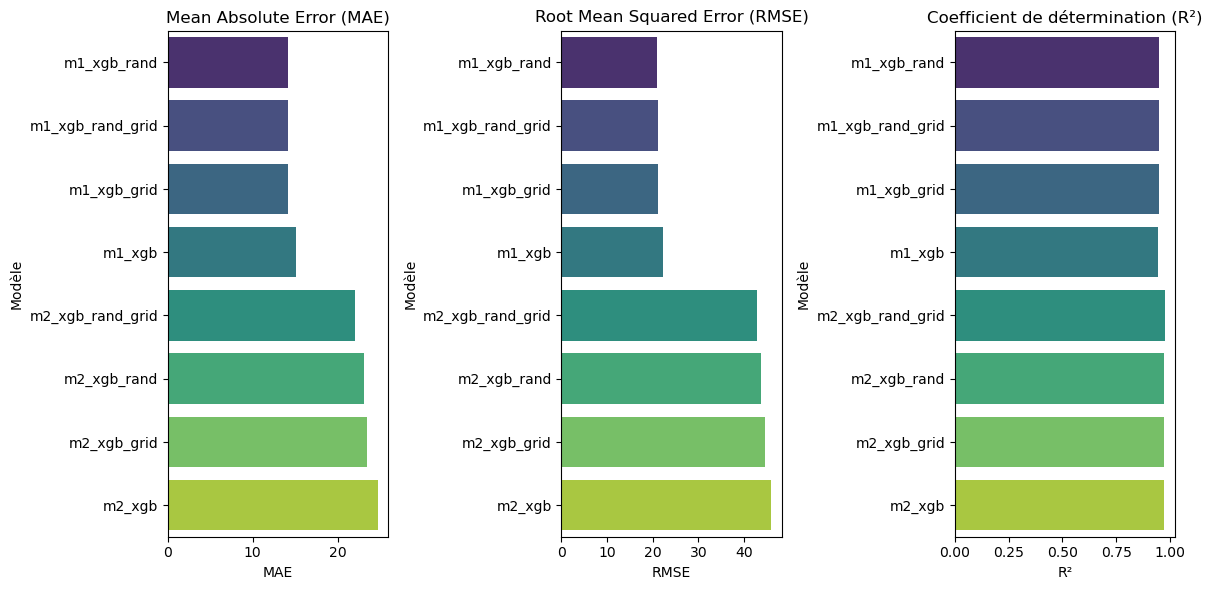

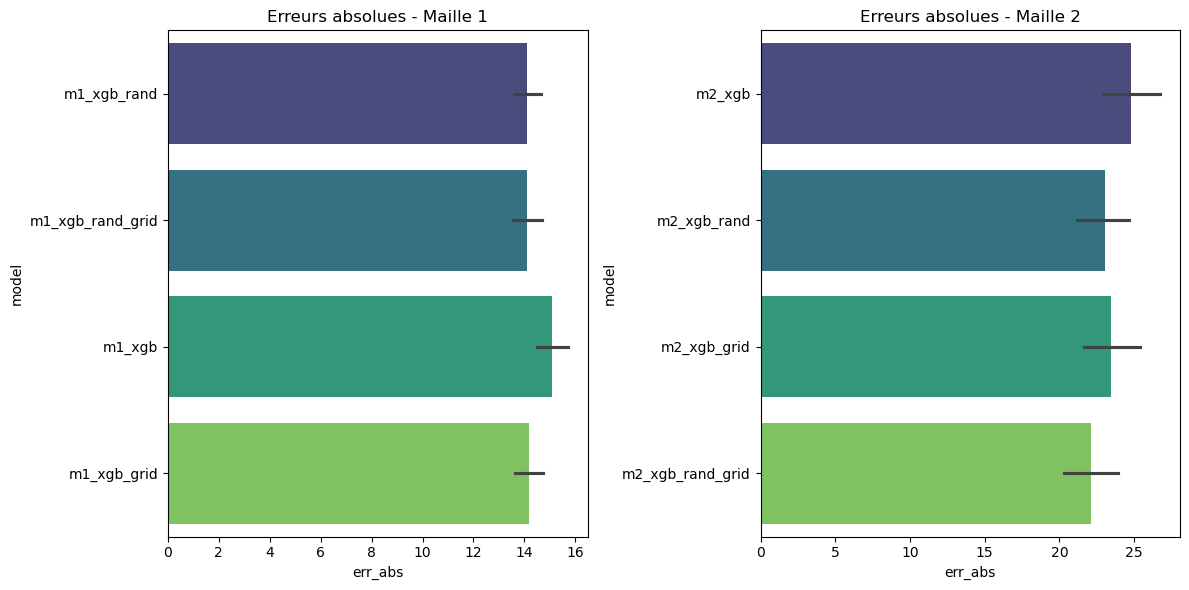

In [363]:
# Visualisation des scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted2, palette='viridis')
plt.title("Mean Absolute Error (MAE)")

plt.subplot(1, 3, 2)
sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted2, palette='viridis')
plt.title("Root Mean Squared Error (RMSE)")

plt.subplot(1, 3, 3)
sns.barplot(x='R²', y='Modèle', data=df_scores_sorted2, palette='viridis')
plt.title("Coefficient de détermination (R²)")

plt.tight_layout()

# Comparaison des erreurs absolues
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='err_abs', y='model', data=all_best_xgb_results, palette='viridis')
plt.title("Erreurs absolues - Maille 1")

plt.subplot(1, 2, 2)
sns.barplot(x='err_abs', y='model', data=all_best_xgb_results2, palette='viridis')
plt.title("Erreurs absolues - Maille 2")

plt.tight_layout()

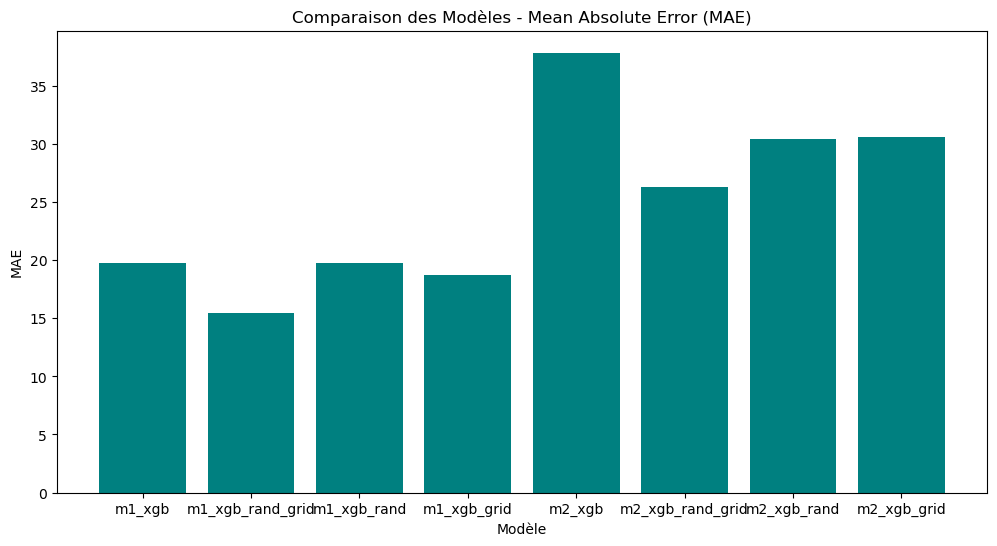

In [364]:
# Comparaison des scores MAE
plt.figure(figsize=(12, 6))
plt.bar(models2, mae_scores, color='teal')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.title('Comparaison des Modèles - Mean Absolute Error (MAE)')
plt.show()

### Visualisation ###

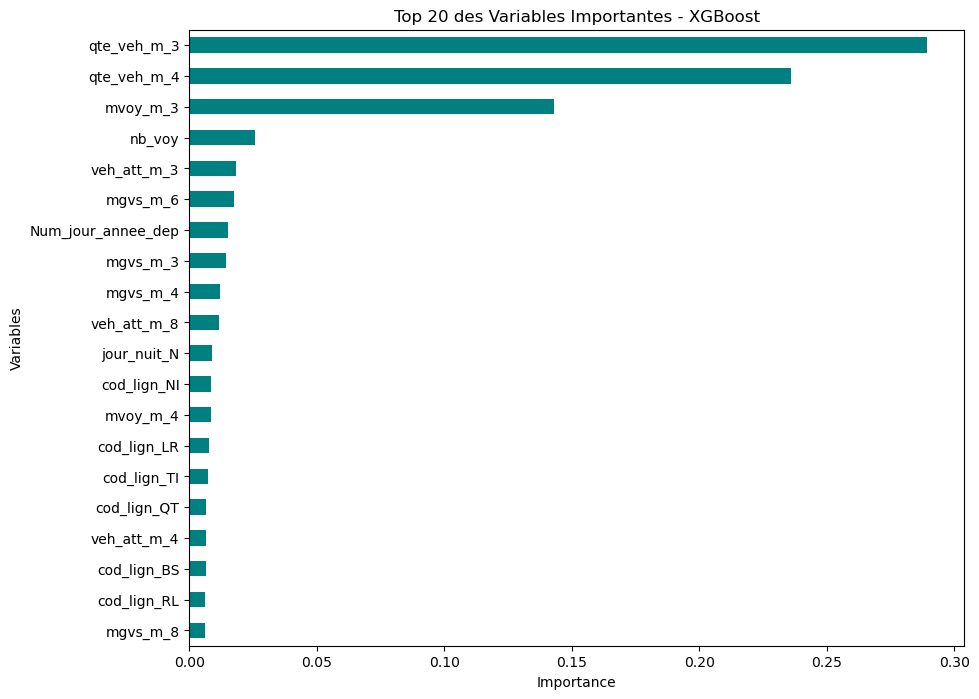

In [365]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb = xgb_model.feature_importances_  
features_xgb = X_train.columns
feature_importances_xgb = pd.Series(importances_xgb, index=features)
feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

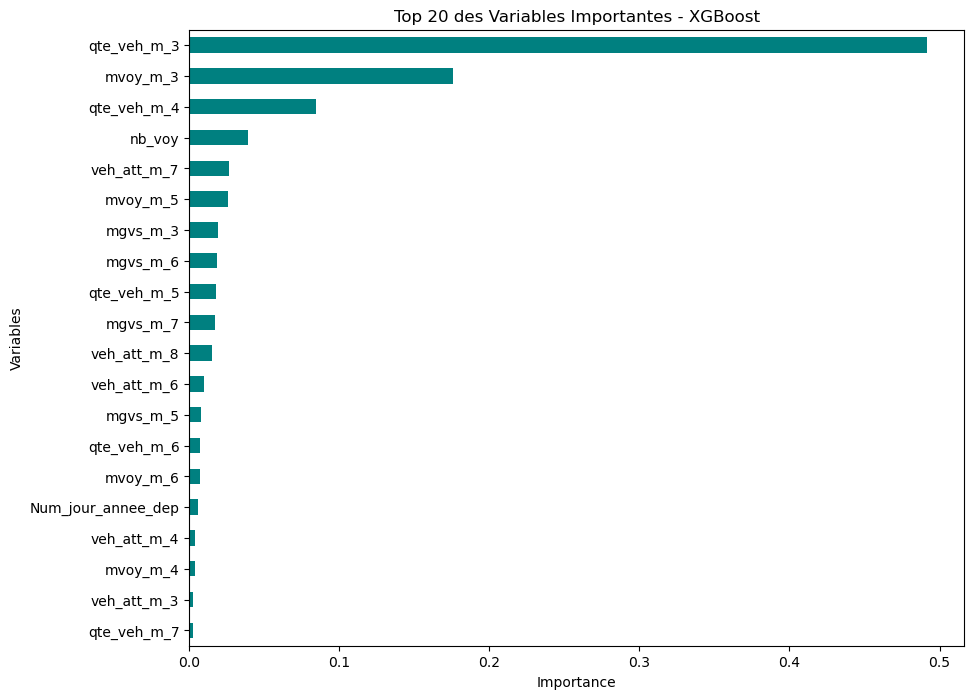

In [366]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb2 = xgb_model2.feature_importances_  
features_xgb2 = X_train2.columns
feature_importances_xgb2 = pd.Series(importances_xgb2, index=features2)
feature_importances_xgb2 = feature_importances_xgb2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

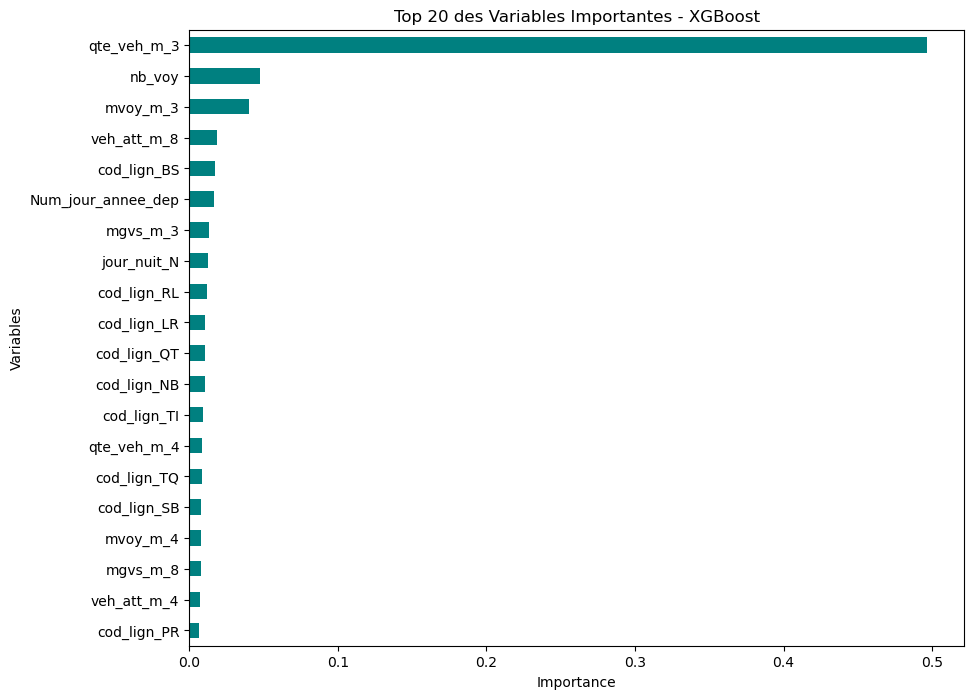

In [367]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best = xgb_best_model.feature_importances_  
features_xgb_best = X_train.columns
feature_importances_xgb_best = pd.Series(importances_xgb_best, index=features_xgb_best)
feature_importances_xgb_best = feature_importances_xgb_best.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

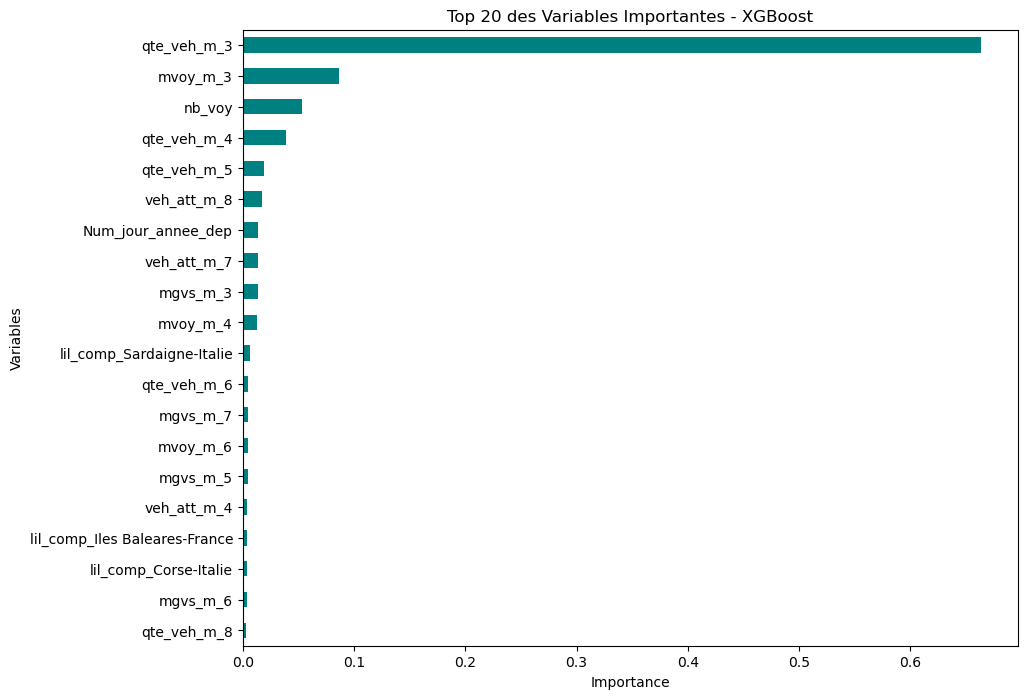

In [368]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best2 = xgb_best_model2.feature_importances_
features_xgb_best2 = X_train2.columns
feature_importances_xgb_best2 = pd.Series(importances_xgb_best2, index=features_xgb_best2)
feature_importances_xgb_best2 = feature_importances_xgb_best2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

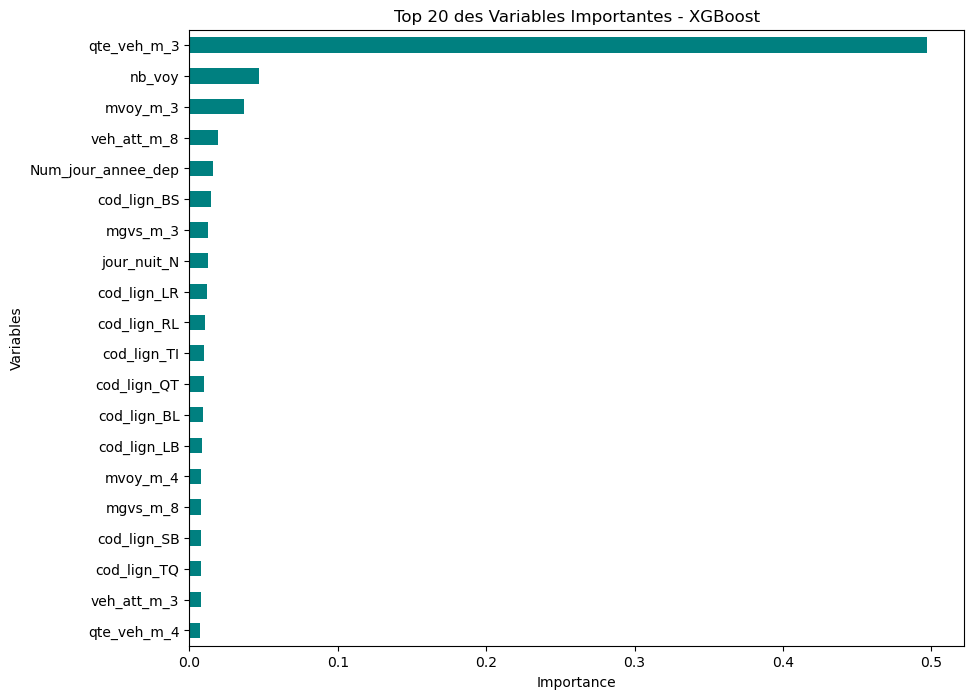

In [369]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best_m1_2 = xgb_best_model_m1_2.feature_importances_
features_xgb_best_m1_2 = X_train.columns
feature_importances_xgb_best_m1_2 = pd.Series(importances_xgb_best_m1_2, index=features_xgb_best_m1_2)
feature_importances_xgb_best_m1_2 = feature_importances_xgb_best_m1_2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best_m1_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

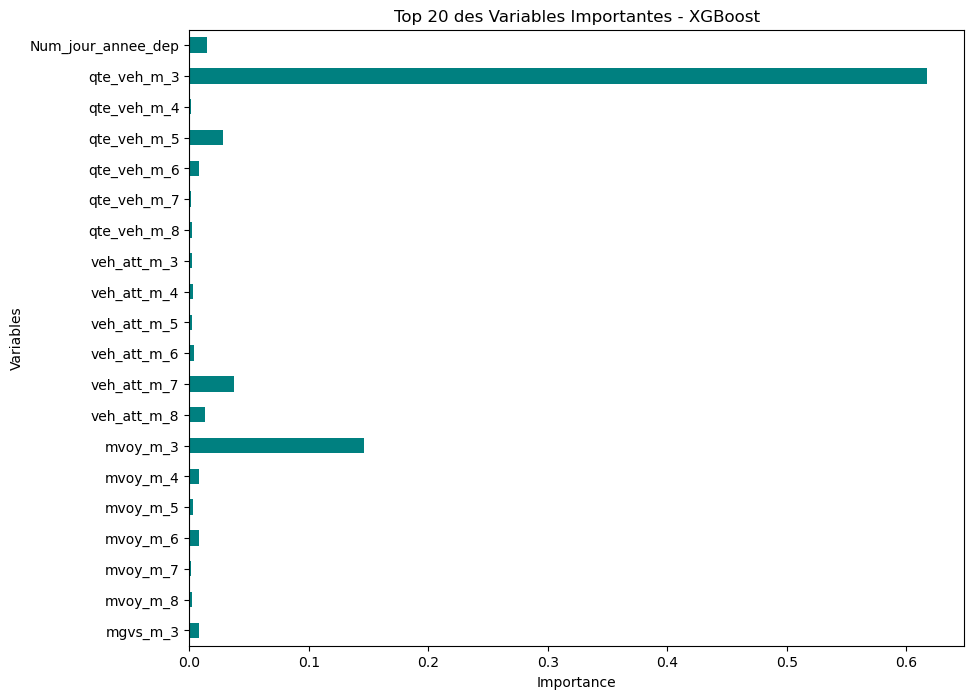

In [370]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best_m2_2 = xgb_best_model_m2_2.feature_importances_
features_xgb_best_m2_2 = X_train2.columns
feature_importances_xgb_best_m2_2 = pd.Series(importances_xgb_best_m2_2, index=features_xgb_best_m2_2)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best_m2_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

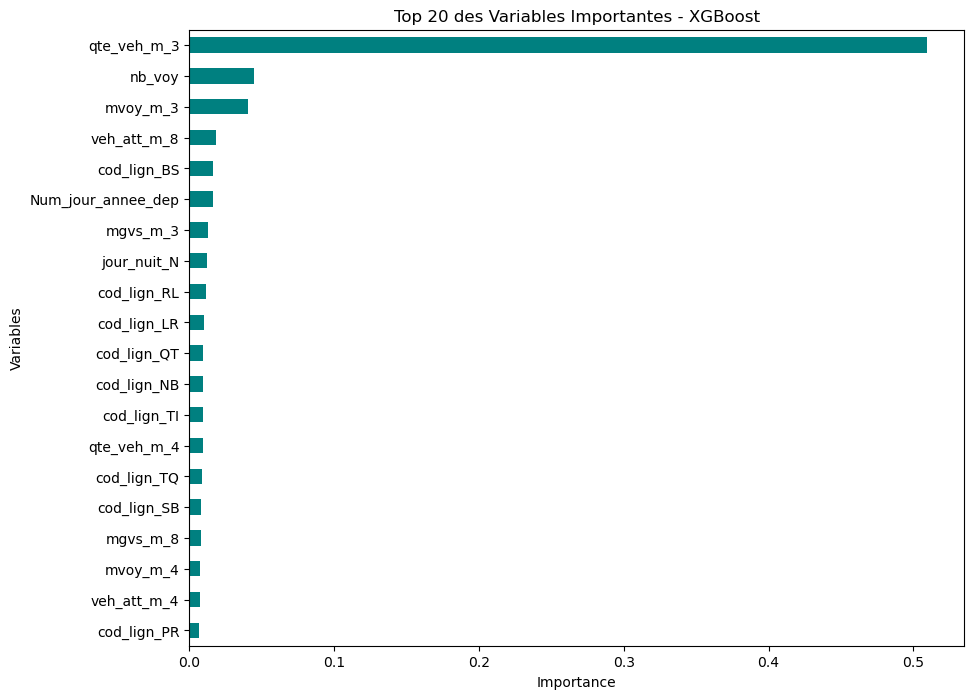

In [371]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best_m1_3 = xgb_best_model_m1_3.feature_importances_
features_xgb_best_m1_3 = X_train.columns
feature_importances_xgb_best_m1_3 = pd.Series(importances_xgb_best_m1_3, index=features_xgb_best_m1_3)
feature_importances_xgb_best_m1_3 = feature_importances_xgb_best_m1_3.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best_m1_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

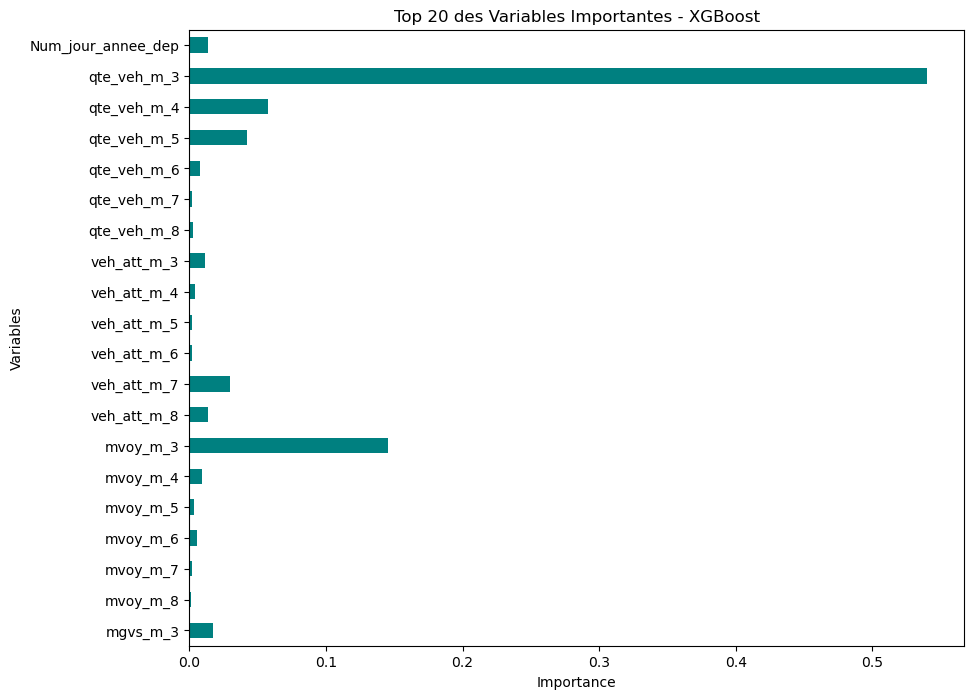

In [372]:
# Extraire et trier les importances des caractéristiques pour XGBoost
importances_xgb_best_m2_3 = xgb_best_model_m2_3.feature_importances_
features_xgb_best_m2_3 = X_train2.columns
feature_importances_xgb_best_m2_3 = pd.Series(importances_xgb_best_m2_3, index=features_xgb_best_m2_3)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_xgb_best_m2_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - XGBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

### CatBoost ###

#### Maille 1 ####

In [373]:
# CatBoost
from catboost import CatBoostRegressor 

# Initialiser le modèle CatBoost avec des paramètres de base
cat_model = CatBoostRegressor(
    iterations=500,  # Nombre d'itérations
    depth=5,         # Profondeur maximale des arbres
    learning_rate=0.05,  # Taux d'apprentissage
    l2_leaf_reg=5,  # Régularisation L2
    bagging_temperature=0.5,  # Introduire du bruit pour éviter le surajustement
    random_strength=5,  # Réduction de l’influence des valeurs extrêmes
    random_state=42,  # Reproductibilité
    verbose=0      
)

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Effectuer la validation croisée classique
cv_results_cat = cross_validate(cat_model, X_train, y_train, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats
print("Résultats de validation croisée classique :")
print(f"MAE moyen : {-np.mean(cv_results_cat['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_cat['test_MSE']):.2f}")
rmse_cat = np.sqrt(-np.mean(cv_results_cat['test_MSE']))
print(f"RMSE moyen : {rmse_cat:.2f}")
print(f"R² moyen : {np.mean(cv_results_cat['test_R2']):.3f}")
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_cat['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_cat['train_MSE']):.2f}")
print(f"RMSE moyen (entraînement) : {np.sqrt(-np.mean(cv_results_cat['train_MSE'])):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_cat['train_R2']):.3f}")

Résultats de validation croisée classique :
MAE moyen : 15.65
RMSE moyen : 23.44
R² moyen : 0.932
MAE moyen (entraînement) : 14.43
RMSE moyen (entraînement) : 21.28
R² moyen (entraînement) : 0.944


In [374]:
# Nombre de splits pour la validation croisée temporelle
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_cat, rmse_scores_cat, r2_scores_cat, mape_scores_cat, mape_filtered_scores_cat = [], [], [], [], []

# Ajouter les erreurs pour chaque split
all_results_cat = []

for train_index_cat, test_index_cat in tscv.split(X):
    X_train_cross_cat, X_test_cross_cat = X.iloc[train_index_cat], X.iloc[test_index_cat]
    y_train_cross_cat, y_test_cross_cat = y.iloc[train_index_cat], y.iloc[test_index_cat]
    
    # Entraîner le modèle
    cat_model.fit(X_train_cross_cat, y_train_cross_cat)
    
    # Faire des prédictions
    y_pred_cross_val_cat = cat_model.predict(X_test_cross_cat)
    
    # Calcul des métriques
    mae_scores_cat.append(mean_absolute_error(y_test_cross_cat, y_pred_cross_val_cat))
    rmse_scores_cat.append(np.sqrt(mean_squared_error(y_test_cross_cat, y_pred_cross_val_cat)))
    r2_scores_cat.append(r2_score(y_test_cross_cat, y_pred_cross_val_cat))
    mape_scores_cat.append(np.mean(np.abs((y_test_cross_cat - y_pred_cross_val_cat) / y_test_cross_cat)) * 100)
    
    # Filtrer et recalculer le MAPE pour les valeurs positives
    y_test_filtered_cat = y_test_cross_cat[y_test_cross_cat > 0]
    y_pred_filtered_cat = y_pred_cross_val_cat[y_test_cross_cat > 0]
    mape_filtered_scores_cat.append(np.mean(np.abs((y_test_filtered_cat - y_pred_filtered_cat) / y_test_filtered_cat)) * 100)

    # Calculer l'erreur absolue pour ce split
    df_split_results_cat = X_test_cross_cat.copy()
    df_split_results_cat['y_test'] = y_test_cross_cat
    df_split_results_cat['y_pred'] = y_pred_cross_val_cat
    df_split_results_cat['err-abs'] = abs(y_test_cross_cat - y_pred_cross_val_cat)
    all_results_cat.append(df_split_results_cat)

# Résultats moyens
print(f"MAE moyen sur les {n_splits} splits : {np.mean(mae_scores_cat):.2f}")
print(f"RMSE moyen sur les {n_splits} splits : {np.mean(rmse_scores_cat):.2f}")
print(f"R² moyen sur les {n_splits} splits : {np.mean(r2_scores_cat):.4f}")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_cat):.2f}%")

MAE moyen sur les 5 splits : 25.26
RMSE moyen sur les 5 splits : 35.01
R² moyen sur les 5 splits : 0.7451
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 62.51%


In [ ]:
# Entraîner le modèle sur l'ensemble d'entraînement
cat_model.fit(X_train, 
              y_train,
              eval_set=[(X_test, y_test)],  # Set de validation
              eval_metric="mae",  # Métrique utilisée pour l'early stopping
              early_stopping_rounds=50,  # Stopper si pas d'amélioration après 50 itérations
              verbose=True
              )

# Faire des prédictions sur l'ensemble de test
y_pred_cat = cat_model.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test pour conserver les colonnes originales
cat_results = X_test.copy()
# Ajouter les valeurs réelles
cat_results['y_test'] = y_test 
# Ajouter les prédictions
cat_results['y_pred'] = y_pred_cat
# Calculer l'erreur absolue 
cat_results['err_abs'] = abs(cat_results['y_test'] - cat_results['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
cat_results['oveh'] = df_maille_aggregee['oveh']
cat_results['abs-err'] = df_maille_aggregee['abs-err']
cat_results['nb_voy'] = df_maille_aggregee['nb_voy']

# Évaluer les performances
mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_cat = r2_score(y_test, y_pred_cat)
mape_cat = np.mean(np.abs((y_test - y_pred_cat) / y_test)) * 100

print(f"Mean Absolute Error (MAE) : {mae_cat}")
print(f"Root Mean Squared Error (RMSE) : {rmse_cat}")
print(f"Coefficient de détermination (R²) : {r2_cat}")
# print(f"Mean Absolute Percentage Error (MAPE) : {mape_cat:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
y_test_filtered_cat = y_test[y_test > 0]
y_pred_filtered_cat = y_pred_cat[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_cat = np.mean(np.abs((y_test_filtered_cat - y_pred_filtered_cat) / y_test_filtered_cat)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_cat:.2f}%")

Mean Absolute Error (MAE) : 15.198604808799443
Root Mean Squared Error (RMSE) : 22.365212129556088
Coefficient de détermination (R²) : 0.9410804924726558
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 56.61%


In [376]:
# Évaluer la performance sur l'ensemble d'entraînement
y_train_cat = cat_model.predict(X_train)

mae_train_cat = mean_absolute_error(y_train, y_train_cat)
rmse_train_cat = np.sqrt(mean_squared_error(y_train, y_train_cat))
r2_train_cat = r2_score(y_train, y_train_cat)

print(f"CatBoost (Entraînement) - MAE : {mae_train_cat}")
print(f"CatBoost (Entraînement) - RMSE : {rmse_train_cat}")
print(f"CatBoost (Entraînement) - R² : {r2_train_cat}")

CatBoost (Entraînement) - MAE : 14.437187512262103
CatBoost (Entraînement) - RMSE : 21.35695832726227
CatBoost (Entraînement) - R² : 0.9438799742268983


In [ ]:
# # Création dataframe avec les résultats
# df_results_cat = pd.DataFrame({
#     'y_test': y_test,
#     'y_pred': y_pred_cat,
#     'err-abs': abs(y_test - y_pred_cat) 
# })

# # Trié Dataframe par erreur absolue
# df_results_cat = df_results_cat.sort_values(by='err-abs', ascending=False)
# df_results_cat.head(20)

In [377]:
# Trier les résultats par erreur absolue décroissante
cat_results =cat_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle1 CatBoost")
cat_results.head()

Top erreurs absolues - Modèle1 CatBoost


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,86.681161,126.318839,353.0,67.285714
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,485.231671,120.768329,880.0,426.000000
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,64.232315,118.767685,197.0,4.000000
6333,181,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152.0,40.012648,111.987352,515.0,154.571429
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.0,19.0,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,89.146598,103.853402,341.0,176.000000


In [378]:
# Trier chaque colonne individuellement par ordre décroissant
cat_results['err_abs'] = cat_results['err_abs'].sort_values(ascending=False).values
cat_results['abs-err'] = cat_results['abs-err'].sort_values(ascending=False).values

In [379]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle1 CatBoost")
cat_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle1 CatBoost


,y_test,y_pred,err_abs,abs-err,oveh
6334,213.0,86.681161,126.318839,731.0,353.0
9669,606.0,485.231671,120.768329,609.0,880.0
4536,183.0,64.232315,118.767685,568.0,197.0
6333,152.0,40.012648,111.987352,551.0,515.0
11289,193.0,89.146598,103.853402,533.0,341.0


#### Maille 2 ####

In [388]:
# CatBoost
from catboost import CatBoostRegressor 

# Initialiser le modèle CatBoost avec des paramètres de base
cat_model2 = CatBoostRegressor(
    iterations=700,  # Nombre d'itérations
    depth=4,         # Profondeur maximale des arbres
    learning_rate=0.03,  # Taux d'apprentissage
    l2_leaf_reg=6,  # Régularisation L2
    bagging_temperature=0.6,  # Introduire du bruit pour éviter le surajustement
    random_strength=6,  # Réduction de l’influence des valeurs extrêmes
    random_state=42,  # Reproductibilité
    verbose=0 
)

# Définir les métriques à utiliser
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Effectuer la validation croisée classique
cv_results_cat2 = cross_validate(cat_model2, X_train2, y_train2, cv=5, scoring=scoring_metrics, return_train_score=True)

# Afficher les résultats
print("Résultats de validation croisée classique :")
print(f"MAE moyen : {-np.mean(cv_results_cat2['test_MAE']):.2f}")
# print(f"MSE moyen : {-np.mean(cv_results_cat2['test_MSE']):.2f}")
rmse_cat2 = np.sqrt(-np.mean(cv_results_cat2['test_MSE']))
print(f"RMSE moyen : {rmse_cat2:.2f}")
print(f"R² moyen : {np.mean(cv_results_cat2['test_R2']):.3f}")
print(f"MAE moyen (entraînement) : {-np.mean(cv_results_cat2['train_MAE']):.2f}")
# print(f"MSE moyen (entraînement) : {-np.mean(cv_results_cat2['train_MSE']):.2f}")
print(f"RMSE moyen (entraînement) : {np.sqrt(-np.mean(cv_results_cat2['train_MSE'])):.2f}")
print(f"R² moyen (entraînement) : {np.mean(cv_results_cat2['train_R2']):.3f}")

Résultats de validation croisée classique :
MAE moyen : 26.07
RMSE moyen : 46.10
R² moyen : 0.974
MAE moyen (entraînement) : 23.08
RMSE moyen (entraînement) : 37.52
R² moyen (entraînement) : 0.983


In [389]:
# Nombre de splits pour la validation croisée temporelle
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sauvegarder les scores pour chaque split
mae_scores_cat2, rmse_scores_cat2, r2_scores_cat2, mape_scores_cat2, mape_filtered_scores_cat2 = [], [], [], [], []

# Ajouter les erreurs pour chaque split
all_results_cat2 = []

for train_index_cat2, test_index_cat2 in tscv.split(X2):
    X_train_cross_cat2, X_test_cross_cat2 = X2.iloc[train_index_cat2], X2.iloc[test_index_cat2]
    y_train_cross_cat2, y_test_cross_cat2 = y2.iloc[train_index_cat2], y2.iloc[test_index_cat2]
    
    # Entraîner le modèle
    cat_model2.fit(X_train_cross_cat2, y_train_cross_cat2)
    
    # Faire des prédictions
    y_pred_cross_val_cat2 = cat_model2.predict(X_test_cross_cat2)
    
    # Calcul des métriques
    mae_scores_cat2.append(mean_absolute_error(y_test_cross_cat2, y_pred_cross_val_cat2))
    rmse_scores_cat2.append(np.sqrt(mean_squared_error(y_test_cross_cat2, y_pred_cross_val_cat2)))
    r2_scores_cat2.append(r2_score(y_test_cross_cat2, y_pred_cross_val_cat2))
    mape_scores_cat2.append(np.mean(np.abs((y_test_cross_cat2 - y_pred_cross_val_cat2) / y_test_cross_cat2)) * 100)
    
    # Filtrer et recalculer le MAPE pour les valeurs positives
    y_test_filtered_cat2 = y_test_cross_cat2[y_test_cross_cat2 > 0]
    y_pred_filtered_cat2 = y_pred_cross_val_cat2[y_test_cross_cat2 > 0]
    mape_filtered_scores_cat2.append(np.mean(np.abs((y_test_filtered_cat2 - y_pred_filtered_cat2) / y_test_filtered_cat2)) * 100)

    # Calculer l'erreur absolue pour ce split
    df_split_results_cat2 = X_test_cross_cat2.copy()
    df_split_results_cat2['y_test'] = y_test_cross_cat2
    df_split_results_cat2['y_pred'] = y_pred_cross_val_cat2
    df_split_results_cat2['err-abs'] = abs(y_test_cross_cat2 - y_pred_cross_val_cat2)
    all_results_cat2.append(df_split_results_cat2)

# Résultats moyens
print(f"MAE moyen sur les {n_splits} splits : {np.mean(mae_scores_cat2):.2f}")
print(f"RMSE moyen sur les {n_splits} splits : {np.mean(rmse_scores_cat2):.2f}")
print(f"R² moyen sur les {n_splits} splits : {np.mean(r2_scores_cat2):.4f}")
print(f"MAPE moyen sur les {n_splits} splits (valeurs positives uniquement) : {np.mean(mape_filtered_scores_cat2):.2f}%")

MAE moyen sur les 5 splits : 54.78
RMSE moyen sur les 5 splits : 96.84
R² moyen sur les 5 splits : 0.6949
MAPE moyen sur les 5 splits (valeurs positives uniquement) : 94.26%


In [ ]:
# Entraîner le modèle sur l'ensemble d'entraînement
cat_model2.fit(X_train2, 
               y_train2,
               eval_set=[(X_test2, y_test2)],  # Set de validation
               eval_metric="mae",  # Métrique utilisée pour l'early stopping
               early_stopping_rounds=50,  # Stopper si pas d'amélioration après 50 itérations
               verbose=True
               )

# Faire des prédictions sur l'ensemble de test
y_pred_cat2 = cat_model2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test2 pour conserver les colonnes originales
cat_results2 = X_test2.copy()
# Ajouter les valeurs réelles
cat_results2['y_test'] = y_test2 
# Ajouter les prédictions
cat_results2['y_pred'] = y_pred_cat2
# Calculer l'erreur absolue 
cat_results2['err_abs'] = abs(cat_results2['y_test'] - cat_results2['y_pred'])  

# Ajouter les colonnes supplémentaires : 'oveh', 'abs-err' et 'nb_voy'
cat_results2['oveh'] = df_maille_aggregee2['oveh']
cat_results2['abs-err'] = df_maille_aggregee2['abs-err']
cat_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

# Évaluer les performances
mae_cat2 = mean_absolute_error(y_test2, y_pred_cat2)
rmse_cat2 = np.sqrt(mean_squared_error(y_test2, y_pred_cat2))
r2_cat2 = r2_score(y_test2, y_pred_cat2)
mape_cat22 = np.mean(np.abs((y_test2 - y_pred_cat2) / y_test2)) * 100

print(f"Mean Absolute Error (MAE) : {mae_cat2}")
print(f"Root Mean Squared Error (RMSE) : {rmse_cat2}")
print(f"Coefficient de détermination (R²) : {r2_cat2}")
# print(f"Mean Absolute Percentage Error (MAPE) : {mape_cat2:.2f}%")

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test2
y_test_filtered_cat2 = y_test2[y_test2 > 0]
y_pred_filtered_cat2 = y_pred_cat2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
mape_filtered_cat2 = np.mean(np.abs((y_test_filtered_cat2 - y_pred_filtered_cat2) / y_test_filtered_cat2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {mape_filtered_cat2:.2f}%")

Mean Absolute Error (MAE) : 25.336058089004204
Root Mean Squared Error (RMSE) : 44.9345394966568
Coefficient de détermination (R²) : 0.9718927167841582
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 96.84%


In [391]:
# Évaluer la performance sur l'ensemble d'entraînement
y_cat_train2 = cat_model2.predict(X_train2)

mae_train_cat2 = mean_absolute_error(y_train2, y_cat_train2)
rmse_train_cat2 = np.sqrt(mean_squared_error(y_train2, y_cat_train2))
r2_train_cat2 = r2_score(y_train2, y_cat_train2)

print(f"CatBoost (Entraînement) - MAE : {mae_train_cat2}")
print(f"CatBoost (Entraînement) - RMSE : {rmse_train_cat2}")
print(f"CatBoost (Entraînement) - R² : {r2_train_cat2}")

CatBoost (Entraînement) - MAE : 23.752887929000476
CatBoost (Entraînement) - RMSE : 38.93352743190388
CatBoost (Entraînement) - R² : 0.9814340566558746


In [392]:
# Trier les résultats par erreur absolue décroissante
cat_results2 =cat_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle2 CatBoost")
cat_results2.head()

Top erreurs absolues - Modèle2 CatBoost


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,646.529750,360.470250,1750.0,823.000000
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1704.714004,337.714004,515.0,443.714286
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.000000,269.000000,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1747.651458,310.348542,3307.0,1027.000000
2471,140,31.0,12.0,1.0,0.0,0.0,0.0,26.000000,12.000000,3.0,0.0,0.0,0.0,40.0,6.0,4.0,2.0,0.0,0.0,209.0,37.0,61.0,23.0,28.0,0.0,3,1,0,0,0,0,0,0,526.0,247.773675,278.226325,973.0,121.571429
5411,238,255.0,128.0,43.0,22.0,3.0,0.0,255.000000,128.000000,43.0,22.0,3.0,0.0,100.0,61.0,23.0,10.0,15.0,0.0,694.0,326.0,241.0,137.0,113.0,0.0,7,0,0,0,0,0,0,0,706.0,982.033841,276.033841,1783.0,994.000000


In [393]:
# Trier chaque colonne individuellement par ordre décroissant
cat_results2['err_abs'] = cat_results2['err_abs'].sort_values(ascending=False).values
cat_results2['abs-err'] = cat_results2['abs-err'].sort_values(ascending=False).values

In [394]:
# Afficher les premières lignes pour chaque modèle
print("Top erreurs absolues - Modèle2 CatBoost")
cat_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle2 CatBoost


,y_test,y_pred,err_abs,abs-err,oveh
4710,1007.0,646.529750,360.470250,2034.0,1750.0
6260,1367.0,1704.714004,337.714004,1470.0,515.0
5481,2058.0,1747.651458,310.348542,1457.0,3307.0
2471,526.0,247.773675,278.226325,1444.0,973.0
5411,706.0,982.033841,276.033841,1441.0,1783.0


### RandomizedSearch + GridSearch Cat ###

#### Maille 1 ####

In [ ]:
# Définir la grille de paramètres
param_random_cat = {
    'iterations': [400, 500, 600],
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 4, 5],
    'bagging_temperature': [0.5, 0.6, 0.8],
    'random_strength': [4, 5, 6]
}

# Configurer RandomizedSearchCV
random_search_cat = RandomizedSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    param_distributions=param_random_cat,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Lancer la recherche
random_search_cat.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour CatBoost (RandomizedSearchCV) :", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour CatBoost (RandomizedSearchCV) : {'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 4, 'iterations': 600, 'depth': 6, 'bagging_temperature': 0.8}


In [396]:
# Ajuster autour des meilleurs paramètres trouvés
param_grid_cat = {
    'iterations': [random_search_cat.best_params_['iterations'] - 100,
                   random_search_cat.best_params_['iterations'],
                   random_search_cat.best_params_['iterations'] + 100],
    'depth': [random_search_cat.best_params_['depth'] - 1,
              random_search_cat.best_params_['depth'],
              random_search_cat.best_params_['depth'] + 1],
    'learning_rate': [random_search_cat.best_params_['learning_rate'] * 0.5,
                      random_search_cat.best_params_['learning_rate'],
                      random_search_cat.best_params_['learning_rate'] * 1.5],
    'l2_leaf_reg': [random_search_cat.best_params_['l2_leaf_reg'] - 1,
                    random_search_cat.best_params_['l2_leaf_reg'],
                    random_search_cat.best_params_['l2_leaf_reg'] + 1],
    'bagging_temperature': [random_search_cat.best_params_['bagging_temperature'] * 0.5,
                            random_search_cat.best_params_['bagging_temperature'],
                            random_search_cat.best_params_['bagging_temperature'] * 1.5],
    'random_strength': [random_search_cat.best_params_['random_strength'] - 1,
                        random_search_cat.best_params_['random_strength'],
                        random_search_cat.best_params_['random_strength'] + 1]
}

grid_search_cat = GridSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    param_grid=param_grid_cat,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_cat.fit(X_train, y_train)

# Afficher les résultats
print("Meilleurs paramètres après GridSearchCV :", grid_search_cat.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres après GridSearchCV : {'bagging_temperature': 0.4, 'depth': 7, 'iterations': 700, 'l2_leaf_reg': 3, 'learning_rate': 0.07500000000000001, 'random_strength': 5}


In [397]:
# Meilleur modèle
cat_best_model = grid_search_cat.best_estimator_

# Entraîner sur tout l’ensemble d’entraînement
cat_best_model.fit(X_train, y_train)

# Faire des prédictions sur l’ensemble de test
best_y_pred_cat_test = cat_best_model.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
cat_rand_grid_results = X_test.copy()
cat_rand_grid_results['y_test'] = y_test
cat_rand_grid_results['y_pred'] = best_y_pred_cat_test
cat_rand_grid_results['err_abs'] = abs(cat_rand_grid_results['y_test'] - cat_rand_grid_results['y_pred'])

# Ajouter les colonnes supplémentaires 
cat_rand_grid_results['oveh'] = df_maille_aggregee['oveh']
cat_rand_grid_results['abs-err'] = df_maille_aggregee['abs-err']
cat_rand_grid_results['nb_voy'] = df_maille_aggregee['nb_voy']

# Évaluer la performance
best_mae_cat_test = mean_absolute_error(y_test, best_y_pred_cat_test)
best_rmse_cat_test = np.sqrt(mean_squared_error(y_test, best_y_pred_cat_test))
best_r2_cat_test = r2_score(y_test, best_y_pred_cat_test)

print(f"CatBoost - MAE : {best_mae_cat_test}")
print(f"CatBoost - RMSE : {best_rmse_cat_test}")
print(f"CatBoost - R² : {best_r2_cat_test}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_cat = np.mean(np.abs((y_test - best_y_pred_cat_test) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat = y_test[y_test > 0]
best_y_pred_filtered_cat = best_y_pred_cat_test[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_cat = np.mean(np.abs((best_y_test_filtered_cat - best_y_pred_filtered_cat) / best_y_test_filtered_cat)) * 100
print(f"XGBoost - MAPE sans valeurs négatives : {best_mape_filtered_test_cat:.2f}%")

CatBoost - MAE : 14.036943287988604
CatBoost - RMSE : 20.9164421298601
CatBoost - R² : 0.948466612494518
XGBoost - MAPE sans valeurs négatives : 46.81%


In [398]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_cat_train = cat_best_model.predict(X_train)

best_mae_cat_train = mean_absolute_error(y_train, best_y_pred_cat_train)
best_rmse_cat_train = np.sqrt(mean_squared_error(y_train, best_y_pred_cat_train))
best_r2_cat_train = r2_score(y_train, best_y_pred_cat_train)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train}")

CatBoost (Entraînement) - MAE : 10.69852982714301
CatBoost (Entraînement) - RMSE : 15.688733129149682
CatBoost (Entraînement) - R² : 0.9697158901764868


In [399]:
# Trier les résultats par erreur absolue décroissante
cat_rand_grid_results =cat_rand_grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Rand Grid")
cat_rand_grid_results.head()

Top erreurs absolues - Modèle CatBoost Rand Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,468.328637,137.671363,880.0,426.000000
10596,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,490.686733,136.313267,1069.0,247.714286
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,68.118213,114.881787,197.0,4.000000
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.000000,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,99.874546,113.125454,353.0,67.285714
11289,247,29.0,19.0,4.0,0.0,0.0,0.0,29.0,19.000000,4.0,0.0,0.0,0.0,7.0,5.0,8.0,0.0,0.0,0.0,312.0,278.0,248.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193.0,81.479286,111.520714,341.0,176.000000


In [400]:
# Trier chaque colonne individuellement par ordre décroissant
cat_rand_grid_results['err_abs'] = cat_rand_grid_results['err_abs'].sort_values(ascending=False).values
cat_rand_grid_results['abs-err'] = cat_rand_grid_results['abs-err'].sort_values(ascending=False).values

In [401]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle CatBoost Rand Grid")
cat_rand_grid_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Rand Grid


,y_test,y_pred,err_abs,abs-err,oveh
9669,606.0,468.328637,137.671363,731.0,880.0
10596,627.0,490.686733,136.313267,609.0,1069.0
4536,183.0,68.118213,114.881787,568.0,197.0
6334,213.0,99.874546,113.125454,551.0,353.0
11289,193.0,81.479286,111.520714,533.0,341.0


#### Maille 2 ####

In [456]:
# Définir la grille de paramètres
param_random_cat2 = {
    'iterations': [500, 600, 700],
    'depth': [2, 3, 4],
    'learning_rate': [0.01, 0.02, 0.03],
    'l2_leaf_reg': [4, 5, 6],
    'bagging_temperature': [0.4, 0.5, 0.6],
    'random_strength': [5, 6, 7]
}

# Configurer RandomizedSearchCV
random_search_cat2 = RandomizedSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    param_distributions=param_random_cat2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Lancer la recherche
random_search_cat2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour CatBoost (RandomizedSearchCV) :", random_search_cat2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres pour CatBoost (RandomizedSearchCV) : {'random_strength': 6, 'learning_rate': 0.03, 'l2_leaf_reg': 4, 'iterations': 700, 'depth': 4, 'bagging_temperature': 0.5}


In [457]:
# Ajuster autour des meilleurs paramètres trouvés
param_grid_cat2 = {
    'iterations': [random_search_cat2.best_params_['iterations'] - 100,
                   random_search_cat2.best_params_['iterations'],
                   random_search_cat2.best_params_['iterations'] + 100],
    'depth': [random_search_cat2.best_params_['depth'] - 1,
              random_search_cat2.best_params_['depth'],
              random_search_cat2.best_params_['depth'] + 1],
    'learning_rate': [random_search_cat2.best_params_['learning_rate'] * 0.5,
                      random_search_cat2.best_params_['learning_rate'],
                      random_search_cat2.best_params_['learning_rate'] * 1.5],
    'l2_leaf_reg': [random_search_cat2.best_params_['l2_leaf_reg'] - 1,
                    random_search_cat2.best_params_['l2_leaf_reg'],
                    random_search_cat2.best_params_['l2_leaf_reg'] + 1],
    'bagging_temperature': [random_search_cat2.best_params_['bagging_temperature'] * 0.5,
                            random_search_cat2.best_params_['bagging_temperature'],
                            random_search_cat2.best_params_['bagging_temperature'] * 1.5],
    'random_strength': [random_search_cat2.best_params_['random_strength'] - 1,
                        random_search_cat2.best_params_['random_strength'],
                        random_search_cat2.best_params_['random_strength'] + 1]
}

grid_search_cat2 = GridSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    param_grid=param_grid_cat2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_cat2.fit(X_train2, y_train2)

# Afficher les résultats
print("Meilleurs paramètres après GridSearchCV :", grid_search_cat2.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


KeyboardInterrupt: 

In [232]:
# Meilleur modèle
cat_best_model2 = grid_search_cat2.best_estimator_

# Entraîner sur tout l’ensemble d’entraînement
cat_best_model2.fit(X_train2, y_train2)

# Faire des prédictions sur l’ensemble de test
best_y_pred_cat_test2 = cat_best_model2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_tes2
cat_rand_grid_results2 = X_test2.copy()
cat_rand_grid_results2['y_test'] = y_test2
cat_rand_grid_results2['y_pred'] = best_y_pred_cat_test2
cat_rand_grid_results2['err_abs'] = abs(cat_rand_grid_results2['y_test'] - cat_rand_grid_results2['y_pred'])

# Ajouter les colonnes supplémentaires 
cat_rand_grid_results2['oveh'] = df_maille_aggregee2['oveh']
cat_rand_grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
cat_rand_grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

# Évaluer la performance
best_mae_cat_test2 = mean_absolute_error(y_test2, best_y_pred_cat_test2)
best_rmse_cat_test2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_cat_test2))
best_r2_cat_test2 = r2_score(y_test2, best_y_pred_cat_test2)

print(f"CatBoost - MAE : {best_mae_cat_test2}")
print(f"CatBoost - RMSE : {best_rmse_cat_test2}")
print(f"CatBoost - R² : {best_r2_cat_test2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_cat2 = np.mean(np.abs((y_test2 - best_y_pred_cat_test2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat2 = y_test2[y_test2 > 0]
best_y_pred_filtered_cat2 = best_y_pred_cat_test2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_cat2 = np.mean(np.abs((best_y_test_filtered_cat2 - best_y_pred_filtered_cat2) / best_y_test_filtered_cat2)) * 100
print(f"XGBoost - MAPE sans valeurs négatives : {best_mape_filtered_test_cat2:.2f}%")

CatBoost - MAE : 21.163999978561005
CatBoost - RMSE : 40.50192866864048
CatBoost - R² : 0.9771645440158112
XGBoost - MAPE sans valeurs négatives : 66.15%


In [233]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_cat_train2 = cat_best_model2.predict(X_train2)

best_mae_cat_train2 = mean_absolute_error(y_train2, best_y_pred_cat_train2)
best_rmse_cat_train2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_cat_train2))
best_r2_cat_train2 = r2_score(y_train2, best_y_pred_cat_train2)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train2}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train2}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train2}")

CatBoost (Entraînement) - MAE : 14.233026364928676
CatBoost (Entraînement) - RMSE : 21.663558264839743
CatBoost (Entraînement) - R² : 0.9942518367005023


In [234]:
# Trier les résultats par erreur absolue décroissante
cat_rand_grid_results2 =cat_rand_grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Rand Grid")
cat_rand_grid_results2.head()

Top erreurs absolues - Modèle CatBoost Rand Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1946.504323,579.504323,515.0,443.714286
5428,239,429.0,202.0,83.0,50.0,10.0,1.0,429.000000,132.000000,52.0,35.0,21.0,21.0,79.0,32.0,20.0,9.0,4.0,0.0,379.0,217.0,149.0,61.0,35.0,82.0,8,0,0,0,0,0,0,0,1070.0,1373.797724,303.797724,2084.0,1305.000000
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1743.830282,300.830282,1657.0,1434.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,710.749634,296.250366,1750.0,823.000000
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.000000,94.000000,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,708.225914,290.774086,0.0,2034.000000


In [235]:
# Trier chaque colonne individuellement par ordre décroissant
cat_rand_grid_results2['err_abs'] = cat_rand_grid_results2['err_abs'].sort_values(ascending=False).values
cat_rand_grid_results2['abs-err'] = cat_rand_grid_results2['abs-err'].sort_values(ascending=False).values

In [236]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle CatBoost Rand Grid")
cat_rand_grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Rand Grid


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1946.504323,579.504323,2034.0,515.0
5428,1070.0,1373.797724,303.797724,1470.0,2084.0
5218,1443.0,1743.830282,300.830282,1457.0,1657.0
4710,1007.0,710.749634,296.250366,1444.0,1750.0
2684,999.0,708.225914,290.774086,1441.0,0.0


### RandomizedSearch cat ###

#### Maille 1 ####

In [402]:
# Définir la grille de paramètres
param_random_cat_m1_2 = {
    'iterations': [400, 500, 600],
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 4, 5],
    'bagging_temperature': [0.5, 0.6, 0.8],
    'random_strength': [4, 5, 6]   
}

# RandomizedSearchCV
random_search_cat_m1_2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_cat_m1_2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_cat_m1_2.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour CatBoost :", random_search_cat_m1_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres pour CatBoost : {'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 4, 'iterations': 400, 'depth': 5, 'bagging_temperature': 0.8}


In [403]:
# Reprendre les meilleurs paramètres
cat_best_model_m1_2 = random_search_cat_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
cat_best_model_m1_2.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_cat_test_m1_2 = cat_best_model_m1_2.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
cat_rand_results = X_test.copy()
cat_rand_results['y_test'] = y_test
cat_rand_results['y_pred'] = best_y_pred_cat_test_m1_2
cat_rand_results['err_abs'] = abs(cat_rand_results['y_test'] - cat_rand_results['y_pred'])

# Ajouter les colonnes supplémentaires 
cat_rand_results['oveh'] = df_maille_aggregee['oveh']
cat_rand_results['abs-err'] = df_maille_aggregee['abs-err']
cat_rand_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_cat_test_m1_2 = mean_absolute_error(y_test, best_y_pred_cat_test_m1_2)
best_rmse_cat_test_m1_2 = np.sqrt(mean_squared_error(y_test, best_y_pred_cat_test_m1_2))
best_r2_cat_test_m1_2 = r2_score(y_test, best_y_pred_cat_test_m1_2)

print(f"MAE sur l'ensemble de test : {best_mae_cat_test_m1_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_cat_test_m1_2}")
print(f"R² sur l'ensemble de test : {best_r2_cat_test_m1_2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_cat_m1_2 = np.mean(np.abs((y_test - best_y_pred_cat_test_m1_2) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat_m1_2 = y_test[y_test > 0]
best_y_pred_filtered_cat_m1_2 = best_y_pred_cat_test_m1_2[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_cat_m1_2 = np.mean(np.abs((best_y_test_filtered_cat_m1_2 - best_y_pred_filtered_cat_m1_2) / best_y_test_filtered_cat_m1_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_cat_m1_2:.2f}%")

c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


MAE sur l'ensemble de test : 15.17696761061467
Root Mean Squared Error (RMSE) : 22.095233410432666
R² sur l'ensemble de test : 0.9424943850279747
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 58.04%


In [404]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_cat_train_m1_2 = cat_best_model_m1_2.predict(X_train)

best_mae_cat_train_m1_2 = mean_absolute_error(y_train, best_y_pred_cat_train_m1_2)
best_rmse_cat_train_m1_2 = np.sqrt(mean_squared_error(y_train, best_y_pred_cat_train_m1_2))
best_r2_cat_train_m1_2 = r2_score(y_train, best_y_pred_cat_train_m1_2)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train_m1_2}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train_m1_2}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train_m1_2}")

CatBoost (Entraînement) - MAE : 12.969998825109272
CatBoost (Entraînement) - RMSE : 18.94672704423534
CatBoost (Entraînement) - R² : 0.9558320280488133


In [405]:
# Trier les résultats pour chaque colonne de manière décroissante
cat_rand_results = cat_rand_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Rand")
cat_rand_results.head()

Top erreurs absolues - Modèle CatBoost Rand


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.000000,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,81.568336,131.431664,353.0,67.285714
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,487.280792,118.719208,880.0,426.000000
6333,181,2.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152.0,38.759254,113.240746,515.0,154.571429
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,70.047012,112.952988,197.0,4.000000
11839,255,4.0,0.0,0.0,0.0,0.0,0.0,109.142857,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150.0,41.030304,108.969696,0.0,33.714286


In [406]:
# Trier chaque colonne individuellement par ordre décroissant
cat_rand_results['err_abs'] = cat_rand_results['err_abs'].sort_values(ascending=False).values
cat_rand_results['abs-err'] = cat_rand_results['abs-err'].sort_values(ascending=False).values

In [407]:
# Afficher les premières lignes 
print("Top erreurs absolues - Modèle CatBoost Rand")
cat_rand_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Rand


,y_test,y_pred,err_abs,abs-err,oveh
6334,213.0,81.568336,131.431664,731.0,353.0
9669,606.0,487.280792,118.719208,609.0,880.0
6333,152.0,38.759254,113.240746,568.0,515.0
4536,183.0,70.047012,112.952988,551.0,197.0
11839,150.0,41.030304,108.969696,533.0,0.0


#### Maille 2 ####

In [408]:
# Définir la grille de paramètres
param_random_cat_m2_2 = {
    'iterations': [500, 600, 700],
    'depth': [2, 3, 4],
    'learning_rate': [0.01, 0.02, 0.03],
    'l2_leaf_reg': [4, 5, 6],
    'bagging_temperature': [0.4, 0.5, 0.6],
    'random_strength': [5, 6, 7]
}

# RandomizedSearchCV
random_search_cat_m2_2 = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_random_cat_m2_2,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search_cat_m2_2.fit(X_train2, y_train2)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres pour CatBoost :", random_search_cat_m2_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres pour CatBoost : {'random_strength': 6, 'learning_rate': 0.03, 'l2_leaf_reg': 4, 'iterations': 600, 'depth': 3, 'bagging_temperature': 0.5}


In [409]:
# Reprendre les meilleurs paramètres
cat_best_model_m2_2 = random_search_cat_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
cat_best_model_m2_2.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_cat_test_m2_2 = cat_best_model_m2_2.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test
cat_rand_results2 = X_test2.copy()
cat_rand_results2['y_test'] = y_test2
cat_rand_results2['y_pred'] = best_y_pred_cat_test_m2_2
cat_rand_results2['err_abs'] = abs(cat_rand_results2['y_test'] - cat_rand_results2['y_pred'])

# Ajouter les colonnes supplémentaires
cat_rand_results2['oveh'] = df_maille_aggregee2['oveh']
cat_rand_results2['abs-err'] = df_maille_aggregee2['abs-err']
cat_rand_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_cat_test_m2_2 = mean_absolute_error(y_test2, best_y_pred_cat_test_m2_2)
best_rmse_cat_test_m2_2 = np.sqrt(mean_squared_error(y_test2, best_y_pred_cat_test_m2_2))
best_r2_cat_test_m2_2 = r2_score(y_test2, best_y_pred_cat_test_m2_2)

print(f"MAE sur l'ensemble de test : {best_mae_cat_test_m2_2}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_cat_test_m2_2}")
print(f"R² sur l'ensemble de test : {best_r2_cat_test_m2_2}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_test_cat_m2_2 = np.mean(np.abs((y_test2 - best_y_pred_cat_test_m2_2) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat_m2_2 = y_test2[y_test2 > 0]
best_y_pred_filtered_cat_m2_2 = best_y_pred_cat_test_m2_2[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_filtered_test_cat_m2_2 = np.mean(np.abs((best_y_test_filtered_cat_m2_2 - best_y_pred_filtered_cat_m2_2) / best_y_test_filtered_cat_m2_2)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_filtered_test_cat_m2_2:.2f}%")

c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:01:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


MAE sur l'ensemble de test : 26.2503563159644
Root Mean Squared Error (RMSE) : 46.19604984226948
R² sur l'ensemble de test : 0.9702923730470832
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 151.83%


In [410]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_cat_train_m2_2 = cat_best_model_m2_2.predict(X_train2)

best_mae_cat_train_m2_2 = mean_absolute_error(y_train2, best_y_pred_cat_train_m2_2)
best_rmse_cat_train_m2_2 = np.sqrt(mean_squared_error(y_train2, best_y_pred_cat_train_m2_2))
best_r2_cat_train_m2_2 = r2_score(y_train2, best_y_pred_cat_train_m2_2)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train_m2_2}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train_m2_2}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train_m2_2}")

CatBoost (Entraînement) - MAE : 21.289370546890414
CatBoost (Entraînement) - RMSE : 33.11668318643488
CatBoost (Entraînement) - R² : 0.9865673041548005


In [411]:
# Trier les résultats pour chaque colonne de manière décroissante
cat_rand_results2 = cat_rand_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Rand")
cat_rand_results2.head()

Top erreurs absolues - Modèle CatBoost Rand


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err
6260,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1775.032959,408.032959,515.0,443.714286
5481,241,753.0,376.0,146.0,93.0,32.0,2.0,753.000000,269.000000,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1676.301147,381.698853,3307.0,1027.000000
2684,149,135.0,60.0,22.0,4.0,0.0,0.0,122.000000,94.000000,94.0,95.0,95.0,100.0,38.0,21.0,7.0,4.0,0.0,0.0,109.0,61.0,27.0,15.0,20.0,10.0,6,0,0,0,0,0,0,1,999.0,636.156250,362.843750,0.0,2034.000000
4710,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,647.819519,359.180481,1750.0,823.000000
5218,232,558.0,272.0,125.0,57.0,10.0,0.0,558.000000,220.000000,93.0,47.0,36.0,36.0,159.0,64.0,13.0,10.0,12.0,0.0,931.0,398.0,120.0,125.0,74.0,52.0,7,0,0,0,0,0,0,0,1443.0,1759.113159,316.113159,1657.0,1434.000000


In [412]:
# Trier chaque colonne individuellement par ordre décroissant
cat_rand_results2['err_abs'] = cat_rand_results2['err_abs'].sort_values(ascending=False).values
cat_rand_results2['abs-err'] = cat_rand_results2['abs-err'].sort_values(ascending=False).values

In [413]:
# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Rand")
cat_rand_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Rand


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1775.032959,408.032959,2034.0,515.0
5481,2058.0,1676.301147,381.698853,1470.0,3307.0
2684,999.0,636.156250,362.843750,1457.0,0.0
4710,1007.0,647.819519,359.180481,1444.0,1750.0
5218,1443.0,1759.113159,316.113159,1441.0,1657.0


### GridSearch Cat ###

#### Maille 1 ####

In [420]:
# Définir la grille de paramètres
param_grid_cat_m1_2 = {
    'iterations': [400, 500, 600],
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 4, 5],
    'bagging_temperature': [0.5, 0.6, 0.8],
    'random_strength': [4, 5, 6] 
}

# Effectuer une recherche avec GridSearchCV
grid_search_cat_m1_2 = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_cat_m1_2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_cat_m1_2.fit(X_train, y_train)

# Afficher les résultats
print("Meilleurs paramètres après GridSearch :", grid_search_cat_m1_2.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres après GridSearch : {'bagging_temperature': 0.5, 'depth': 4, 'iterations': 400, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'random_strength': 4}


In [421]:
# Reprendre les meilleurs paramètres
cat_best_model_m1_3 = grid_search_cat_m1_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
cat_best_model_m1_3.fit(X_train, y_train)

# Évaluer sur l'ensemble de test
best_y_pred_cat_test_m1_3 = cat_best_model_m1_3.predict(X_test)

# Créer un DataFrame pour les résultats en copiant X_test
cat_grid_results = X_test.copy()
cat_grid_results['y_test'] = y_test
cat_grid_results['y_pred'] = best_y_pred_cat_test_m1_3
cat_grid_results['err_abs'] = abs(cat_grid_results['y_test'] - cat_grid_results['y_pred'])

# Ajouter les colonnes supplémentaires 
cat_grid_results['oveh'] = df_maille_aggregee['oveh']
cat_grid_results['abs-err'] = df_maille_aggregee['abs-err']
cat_grid_results['nb_voy'] = df_maille_aggregee['nb_voy']

best_mae_cat_test_m1_3 = mean_absolute_error(y_test, best_y_pred_cat_test_m1_3)
best_rmse_cat_test_m1_3 = np.sqrt(mean_squared_error(y_test, best_y_pred_cat_test_m1_3))
best_r2_cat_test_m1_3 = r2_score(y_test, best_y_pred_cat_test_m1_3)

print(f"MAE sur l'ensemble de test : {best_mae_cat_test_m1_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_cat_test_m1_3}")
print(f"R² sur l'ensemble de test : {best_r2_cat_test_m1_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_cat_test_m1_3 = np.mean(np.abs((y_test - best_y_pred_cat_test_m1_3) / y_test)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat_m1_3 = y_test[y_test > 0]
best_y_pred_filtered_cat_m1_3 = best_y_pred_cat_test_m1_3[y_test > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_test_filtered_cat_m1_3 = np.mean(np.abs((best_y_test_filtered_cat_m1_3 - best_y_pred_filtered_cat_m1_3) / best_y_test_filtered_cat_m1_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_test_filtered_cat_m1_3:.2f}%")

c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


MAE sur l'ensemble de test : 15.17696761061467
Root Mean Squared Error (RMSE) : 22.095233410432666
R² sur l'ensemble de test : 0.9424943850279747
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 58.04%


In [422]:
# Évaluer la performance sur l'ensemble d'entraînement  
best_y_pred_cat_train_m1_3 = cat_best_model_m1_3.predict(X_train)

best_mae_cat_train_m1_3 = mean_absolute_error(y_train, best_y_pred_cat_train_m1_3)
best_rmse_cat_train_m1_3 = np.sqrt(mean_squared_error(y_train, best_y_pred_cat_train_m1_3))
best_r2_cat_train_m1_3 = r2_score(y_train, best_y_pred_cat_train_m1_3)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train_m1_3}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train_m1_3}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train_m1_3}")

CatBoost (Entraînement) - MAE : 12.969998825109272
CatBoost (Entraînement) - RMSE : 18.94672704423534
CatBoost (Entraînement) - R² : 0.9558320280488133


In [423]:
# Trier les résultats pour chaque colonne de manière décroissante
cat_grid_results = cat_grid_results.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Grid")
cat_grid_results.head()

Top erreurs absolues - Modèle CatBoost Grid


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err
6334,181,5.0,3.0,1.0,0.0,0.0,0.0,2.000000,3.0,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,81.568336,131.431664,353.0,67.285714
9669,226,206.0,89.0,41.0,19.0,5.0,0.0,206.000000,89.0,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,487.280792,118.719208,880.0,426.000000
6333,181,2.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152.0,38.759254,113.240746,515.0,154.571429
4536,151,13.0,0.0,0.0,0.0,0.0,0.0,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,44.0,60.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,183.0,70.047012,112.952988,197.0,4.000000
11839,255,4.0,0.0,0.0,0.0,0.0,0.0,109.142857,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150.0,41.030304,108.969696,0.0,33.714286


In [424]:
# Trier chaque colonne individuellement par ordre décroissant
cat_grid_results['err_abs'] = cat_grid_results['err_abs'].sort_values(ascending=False).values
cat_grid_results['abs-err'] = cat_grid_results['abs-err'].sort_values(ascending=False).values

In [425]:
# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Grid")
cat_grid_results[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Grid


,y_test,y_pred,err_abs,abs-err,oveh
6334,213.0,81.568336,131.431664,731.0,353.0
9669,606.0,487.280792,118.719208,609.0,880.0
6333,152.0,38.759254,113.240746,568.0,515.0
4536,183.0,70.047012,112.952988,551.0,197.0
11839,150.0,41.030304,108.969696,533.0,0.0


#### Maille 2 ####

In [414]:
# Définir la grille de paramètres
param_grid_cat_m2_2 = {
    'iterations': [500, 600, 700],
    'depth': [2, 3, 4],
    'learning_rate': [0.01, 0.02, 0.03],
    'l2_leaf_reg': [4, 5, 6],
    'bagging_temperature': [0.4, 0.5, 0.6],
    'random_strength': [5, 6, 7]
}

# Effectuer une recherche avec GridSearchCV
grid_search_cat_m2_2 = GridSearchCV(
    XGBRegressor(random_state=42),
    param_grid_cat_m2_2,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_cat_m2_2.fit(X_train2, y_train2)

# Afficher les résultats
print("Meilleurs paramètres après GridSearch :", grid_search_cat_m2_2.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres après GridSearch : {'bagging_temperature': 0.4, 'depth': 2, 'iterations': 500, 'l2_leaf_reg': 4, 'learning_rate': 0.03, 'random_strength': 5}


In [415]:
# Reprendre les meilleurs paramètres
cat_best_model_m2_3 = grid_search_cat_m2_2.best_estimator_

# Entraîner le modèle avec les meilleurs paramètres
cat_best_model_m2_3.fit(X_train2, y_train2)

# Évaluer sur l'ensemble de test
best_y_pred_cat_test_m2_3 = cat_best_model_m2_3.predict(X_test2)

# Créer un DataFrame pour les résultats en copiant X_test
cat_grid_results2 = X_test2.copy()
cat_grid_results2['y_test'] = y_test2
cat_grid_results2['y_pred'] = best_y_pred_cat_test_m2_3
cat_grid_results2['err_abs'] = abs(cat_grid_results2['y_test'] - cat_grid_results2['y_pred'])

# Ajouter les colonnes supplémentaires
cat_grid_results2['oveh'] = df_maille_aggregee2['oveh']
cat_grid_results2['abs-err'] = df_maille_aggregee2['abs-err']
cat_grid_results2['nb_voy'] = df_maille_aggregee2['nb_voy']

best_mae_cat_test_m2_3 = mean_absolute_error(y_test2, best_y_pred_cat_test_m2_3)
best_rmse_cat_test_m2_3 = np.sqrt(mean_squared_error(y_test2, best_y_pred_cat_test_m2_3))
best_r2_cat_test_m2_3 = r2_score(y_test2, best_y_pred_cat_test_m2_3)

print(f"MAE sur l'ensemble de test : {best_mae_cat_test_m2_3}")
print(f"Root Mean Squared Error (RMSE) : {best_rmse_cat_test_m2_3}")
print(f"R² sur l'ensemble de test : {best_r2_cat_test_m2_3}")

# Calculer le Mean Absolute Percentage Error (MAPE)
best_mape_cat_test_m2_3 = np.mean(np.abs((y_test2 - best_y_pred_cat_test_m2_3) / y_test2)) * 100

# Filtrer les valeurs positives ou supérieures à un seuil dans y_test
best_y_test_filtered_cat_m2_3 = y_test2[y_test2 > 0]
best_y_pred_filtered_cat_m2_3 = best_y_pred_cat_test_m2_3[y_test2 > 0]

# Calcul du MAPE avec les valeurs filtrées
best_mape_test_filtered_cat_m2_3 = np.mean(np.abs((best_y_test_filtered_cat_m2_3 - best_y_pred_filtered_cat_m2_3) / best_y_test_filtered_cat_m2_3)) * 100
print(f"Mean Absolute Percentage Error (MAPE) sans valeurs négatives : {best_mape_test_filtered_cat_m2_3:.2f}%")

c:\Users\a.valery\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bagging_temperature", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

  warnings.warn(smsg, UserWarning)


MAE sur l'ensemble de test : 26.2503563159644
Root Mean Squared Error (RMSE) : 46.19604984226948
R² sur l'ensemble de test : 0.9702923730470832
Mean Absolute Percentage Error (MAPE) sans valeurs négatives : 151.83%


In [416]:
# Évaluer la performance sur l'ensemble d'entraînement
best_y_pred_cat_train_m2_3 = cat_best_model_m2_3.predict(X_train2)

best_mae_cat_train_m2_3 = mean_absolute_error(y_train2, best_y_pred_cat_train_m2_3)
best_rmse_cat_train_m2_3 = np.sqrt(mean_squared_error(y_train2, best_y_pred_cat_train_m2_3))
best_r2_cat_train_m2_3 = r2_score(y_train2, best_y_pred_cat_train_m2_3)

print(f"CatBoost (Entraînement) - MAE : {best_mae_cat_train_m2_3}")
print(f"CatBoost (Entraînement) - RMSE : {best_rmse_cat_train_m2_3}")
print(f"CatBoost (Entraînement) - R² : {best_r2_cat_train_m2_3}")

CatBoost (Entraînement) - MAE : 21.289370546890414
CatBoost (Entraînement) - RMSE : 33.11668318643488
CatBoost (Entraînement) - R² : 0.9865673041548005


In [417]:
# Trier les résultats pour chaque colonne de manière décroissante
cat_grid_results2 = cat_grid_results2.sort_values(by='err_abs', ascending=False)

# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Grid")

Top erreurs absolues - Modèle CatBoost Grid


In [418]:
# Trier chaque colonne individuellement par ordre décroissant
cat_grid_results2['err_abs'] = cat_grid_results2['err_abs'].sort_values(ascending=False).values
cat_grid_results2['abs-err'] = cat_grid_results2['abs-err'].sort_values(ascending=False).values

In [419]:
# Afficher les premières lignes
print("Top erreurs absolues - Modèle CatBoost Grid")
cat_grid_results2[['y_test', 'y_pred', 'err_abs', 'abs-err', 'oveh']].head()

Top erreurs absolues - Modèle CatBoost Grid


,y_test,y_pred,err_abs,abs-err,oveh
6260,1367.0,1775.032959,408.032959,2034.0,515.0
5481,2058.0,1676.301147,381.698853,1470.0,3307.0
2684,999.0,636.156250,362.843750,1457.0,0.0
4710,1007.0,647.819519,359.180481,1444.0,1750.0
5218,1443.0,1759.113159,316.113159,1441.0,1657.0


### Recherche meilleurs résultats CatBoost ###

In [427]:
# Modèle m1_cat
cat_results['model'] = 'm1_cat'

# Modèle m1_cat_rand_grid
cat_rand_grid_results['model'] = 'm1_cat_rand_grid'

# Modèle m1_cat_rand
cat_rand_results['model'] = 'm1_cat_rand'

# Modèle m1_cat_grid
cat_grid_results['model'] = 'm1_cat_grid'

# Modèle m2_cat
cat_results2['model'] = 'm2_cat'

# Modèle m2_cat_rand_grid
cat_rand_grid_results2['model'] = 'm2_cat_rand_grid'

# Modèle m2_cat_rand
cat_rand_results2['model'] = 'm2_cat_rand'

# Modèle m2_cat_grid
cat_grid_results2['model'] = 'm2_cat_grid'

# Regrouper tous les résultats dans un seul DataFrame
all_best_cat_results = pd.concat([
    cat_results,
    cat_rand_grid_results,
    cat_rand_results,
    cat_grid_results,
], ignore_index=True)

# Regrouper tous les résultats dans un seul DataFrame
all_best_cat_results2 = pd.concat([
    cat_results2,
    cat_rand_grid_results2,
    cat_rand_results2,
    cat_grid_results2
], ignore_index=True)

# Trier par erreur absolue décroissante
all_best_cat_results = all_best_cat_results.sort_values(by='err_abs', ascending=False)
all_best_results2 = all_best_cat_results2.sort_values(by='err_abs', ascending=False)

In [428]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M1")
all_best_cat_results.head()

Top erreurs absolues parmi tous les modèles M1


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,cod_lign_7Q,cod_lign_8L,cod_lign_8P,cod_lign_8T,cod_lign_AD,cod_lign_AH,cod_lign_AN,cod_lign_AT,cod_lign_BF,cod_lign_BH,cod_lign_BL,cod_lign_BN,cod_lign_BP,cod_lign_BR,cod_lign_BS,cod_lign_BT,cod_lign_DA,cod_lign_DH,cod_lign_DN,cod_lign_DT,cod_lign_FB,cod_lign_FL,cod_lign_FP,cod_lign_HA,cod_lign_HB,cod_lign_HD,cod_lign_HL,cod_lign_HN,cod_lign_HT,cod_lign_I7,cod_lign_IB,cod_lign_IL,cod_lign_IN,cod_lign_IS,cod_lign_IT,cod_lign_L8,cod_lign_LB,cod_lign_LH,cod_lign_LI,cod_lign_LR,cod_lign_MQ,cod_lign_MT,cod_lign_NB,cod_lign_ND,cod_lign_NH,cod_lign_NI,cod_lign_NS,cod_lign_NT,cod_lign_P8,cod_lign_PB,cod_lign_PF,cod_lign_PR,cod_lign_Q7,cod_lign_QM,cod_lign_QT,cod_lign_RB,cod_lign_RL,cod_lign_RN,cod_lign_RP,cod_lign_RS,cod_lign_RT,cod_lign_SB,cod_lign_SI,cod_lign_SN,cod_lign_SR,cod_lign_T8,cod_lign_TA,cod_lign_TB,cod_lign_TD,cod_lign_TH,cod_lign_TI,cod_lign_TM,cod_lign_TN,cod_lign_TQ,cod_lign_TR,jour_nuit_N,y_test,y_pred,err_abs,oveh,abs-err,model
3005,226,206.0,89.0,41.0,19.0,5.0,0.0,206.0,89.000000,41.0,19.0,19.0,19.0,55.0,26.0,6.0,7.0,5.0,0.0,881.0,487.0,137.0,275.0,87.0,58.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,606.0,468.328637,137.671363,880.0,731.0,m1_cat_rand_grid
3006,237,305.0,174.0,46.0,16.0,0.0,0.0,929.0,449.142857,46.0,13.0,0.0,0.0,59.0,55.0,14.0,74.0,24.0,0.0,454.0,451.0,118.0,432.0,383.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,627.0,490.686733,136.313267,1069.0,609.0,m1_cat_rand_grid
6010,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.000000,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,81.568336,131.431664,353.0,731.0,m1_cat_rand
9015,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.000000,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,81.568336,131.431664,353.0,731.0,m1_cat_grid
0,181,5.0,3.0,1.0,0.0,0.0,0.0,2.0,3.000000,1.0,0.0,0.0,0.0,8.0,7.0,0.0,0.0,0.0,0.0,85.0,48.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,213.0,86.681161,126.318839,353.0,731.0,m1_cat


In [429]:
# Afficher les premières lignes
print("Top erreurs absolues parmi tous les modèles M2")
all_best_cat_results2.head()

Top erreurs absolues parmi tous les modèles M2


,Num_jour_annee_dep,qte_veh_m_3,qte_veh_m_4,qte_veh_m_5,qte_veh_m_6,qte_veh_m_7,qte_veh_m_8,veh_att_m_3,veh_att_m_4,veh_att_m_5,veh_att_m_6,veh_att_m_7,veh_att_m_8,mvoy_m_3,mvoy_m_4,mvoy_m_5,mvoy_m_6,mvoy_m_7,mvoy_m_8,mgvs_m_3,mgvs_m_4,mgvs_m_5,mgvs_m_6,mgvs_m_7,mgvs_m_8,nb_voy,lil_comp_Corse-Italie,lil_comp_Elbe-Italie,lil_comp_Iles Baleares-France,lil_comp_Inter-Iles,lil_comp_Sardaigne-France,lil_comp_Sardaigne-Italie,sens_S,y_test,y_pred,err_abs,oveh,abs-err,model
0,216,238.0,82.0,44.0,15.0,5.0,0.0,159.000000,51.000000,27.0,14.0,14.0,14.0,28.0,26.0,8.0,3.0,0.0,0.0,198.0,144.0,30.0,43.0,79.0,54.0,4,0,0,0,0,0,0,1,1007.0,646.529750,360.470250,1750.0,2034.0,m2_cat
1,265,735.0,555.0,339.0,167.0,55.0,0.0,1552.285714,1581.857143,1346.0,150.0,52.0,0.0,74.0,60.0,89.0,28.0,71.0,0.0,293.0,281.0,326.0,87.0,210.0,0.0,8,0,0,0,0,0,0,1,1367.0,1704.714004,337.714004,515.0,1470.0,m2_cat
2,241,753.0,376.0,146.0,93.0,32.0,2.0,753.000000,269.000000,105.0,65.0,35.0,35.0,200.0,109.0,46.0,24.0,21.0,0.0,687.0,599.0,225.0,129.0,114.0,104.0,6,0,0,0,0,0,0,1,2058.0,1747.651458,310.348542,3307.0,1457.0,m2_cat
3,140,31.0,12.0,1.0,0.0,0.0,0.0,26.000000,12.000000,3.0,0.0,0.0,0.0,40.0,6.0,4.0,2.0,0.0,0.0,209.0,37.0,61.0,23.0,28.0,0.0,3,1,0,0,0,0,0,0,526.0,247.773675,278.226325,973.0,1444.0,m2_cat
4,238,255.0,128.0,43.0,22.0,3.0,0.0,255.000000,128.000000,43.0,22.0,3.0,0.0,100.0,61.0,23.0,10.0,15.0,0.0,694.0,326.0,241.0,137.0,113.0,0.0,7,0,0,0,0,0,0,0,706.0,982.033841,276.033841,1783.0,1441.0,m2_cat


In [430]:
# Regrouper les résultats de tous les modèles
final_results_cat = pd.DataFrame({
    # Maille 1
    'y_test': y_test,  # La cible réelle 
    'm1_cat': cat_results['err_abs'],
    'm1_cat_rand_grid': cat_rand_grid_results['err_abs'],
    'm1_cat_rand': cat_rand_results['err_abs'],
    'm1_cat_grid': cat_grid_results['err_abs'],
    'abs-err': df_maille_aggregee['abs-err'],
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results_cat['m1_cat'] = final_results_cat['m1_cat'].sort_values(ascending=False).values
final_results_cat['m1_cat_rand_grid'] = final_results_cat['m1_cat_rand_grid'].sort_values(ascending=False).values
final_results_cat['m1_cat_rand'] = final_results_cat['m1_cat_rand'].sort_values(ascending=False).values
final_results_cat['m1_cat_grid'] = final_results_cat['m1_cat_grid'].sort_values(ascending=False).values
final_results_cat['abs-err'] = final_results_cat['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results_cat.head()

Comparaison finale erreur absolue des modèles


,y_test,m1_cat,m1_cat_rand_grid,m1_cat_rand,m1_cat_grid,abs-err
0,NaN,126.318839,137.671363,131.431664,131.431664,731.0
1,NaN,120.768329,136.313267,118.719208,118.719208,731.0
2,NaN,118.767685,114.881787,113.240746,113.240746,707.0
3,41.0,111.987352,113.125454,112.952988,112.952988,705.0
4,NaN,103.853402,111.520714,108.969696,108.969696,700.0


In [431]:
# Regrouper les résultats de tous les modèles
final_results_cat2 = pd.DataFrame({
    # Maille 1
    'y_test': y_test2,  # La cible réelle 
    'm2_cat': cat_results2['err_abs'],
    'm2_cat_rand_grid': cat_rand_grid_results2['err_abs'],
    'm2_cat_rand': cat_rand_results2['err_abs'],
    'm2_cat_grid': cat_grid_results2['err_abs'],
    'abs-err': df_maille_aggregee2['abs-err'],
})

# Afficher les premières lignes pour visualisation:
# Trier chaque colonne individuellement par ordre décroissant
final_results_cat2['m2_cat'] = final_results_cat2['m2_cat'].sort_values(ascending=False).values
final_results_cat2['m2_cat_rand_grid'] = final_results_cat2['m2_cat_rand_grid'].sort_values(ascending=False).values
final_results_cat2['m2_cat_rand'] = final_results_cat2['m2_cat_rand'].sort_values(ascending=False).values
final_results_cat2['m2_cat_grid'] = final_results_cat2['m2_cat_grid'].sort_values(ascending=False).values
final_results_cat2['abs-err'] = final_results_cat2['abs-err'].sort_values(ascending=False).values

print("Comparaison finale erreur absolue des modèles")
final_results_cat2.head()

Comparaison finale erreur absolue des modèles


,y_test,m2_cat,m2_cat_rand_grid,m2_cat_rand,m2_cat_grid,abs-err
0,33.0,360.470250,579.504323,408.032959,408.032959,2087.0
1,NaN,337.714004,303.797724,381.698853,381.698853,2034.0
2,NaN,310.348542,300.830282,362.843750,362.843750,1998.0
3,NaN,278.226325,296.250366,359.180481,359.180481,1916.0
4,NaN,276.033841,290.774086,316.113159,316.113159,1745.0


In [ ]:
# Exporter le DataFrame avec les résultats finaux pour la maille 1
final_results_cat.to_excel("final_results_cat.xlsx", index=False)

# Exporter le DataFrame avec les résultats finaux pour la maille 2
final_results_cat2.to_excel("final_results_cat2.xlsx", index=False)

In [432]:
# Noms des modèles à comparer
models3 = ['m1_cat', 'm1_cat_rand_grid', 'm1_cat_rand', 'm1_cat_grid', 'm2_cat', 'm2_cat_rand_grid', 'm2_cat_rand', 'm2_cat_grid']

# Scores des modèles pour MAE, RMSE et R² (remplir avec les bonnes valeurs issues de tes calculs)
mae_scores3 = [mae_cat, best_mae_cat_test, best_mae_cat_test_m1_2 , best_mae_cat_test_m1_3, 
              mae_cat2, best_mae_cat_test2, best_mae_cat_test_m2_2 , best_mae_cat_test_m2_3]
rmse_scores3 = [rmse_cat, best_rmse_cat_test, best_rmse_cat_test_m1_2 , best_rmse_cat_test_m1_3,
                rmse_cat2, best_rmse_cat_test2, best_rmse_cat_test_m2_2 , best_rmse_cat_test_m2_3]
r2_scores3 = [r2_cat, best_r2_cat_test, best_r2_cat_test_m1_2 , best_r2_cat_test_m1_3,
                r2_cat2, best_r2_cat_test2, best_r2_cat_test_m2_2 , best_r2_cat_test_m2_3]

# Créer un DataFrame pour comparer les scores
df_scores3 = pd.DataFrame({
    'Modèle': models3,
    'MAE': mae_scores3,
    'RMSE': rmse_scores3,
    'R²': r2_scores3
})

# Afficher les scores
print("Comparaison des métriques des modèles")
df_scores3

Comparaison des métriques des modèles


,Modèle,MAE,RMSE,R²
0,m1_cat,15.198605,22.365212,0.941080
1,m1_cat_rand_grid,14.036943,20.916442,0.948467
2,m1_cat_rand,15.176968,22.095233,0.942494
3,m1_cat_grid,15.176968,22.095233,0.942494
4,m2_cat,25.336058,44.934539,0.971893
5,m2_cat_rand_grid,21.164000,40.501929,0.977165
6,m2_cat_rand,26.250356,46.196050,0.970292
7,m2_cat_grid,26.250356,46.196050,0.970292


In [433]:
# Trier par MAE pour voir les meilleurs modèles en premier
df_scores_sorted3 = df_scores3.sort_values(by='MAE', ascending=True)
print("Scores triés par MAE")
df_scores_sorted3

Scores triés par MAE


,Modèle,MAE,RMSE,R²
1,m1_cat_rand_grid,14.036943,20.916442,0.948467
2,m1_cat_rand,15.176968,22.095233,0.942494
3,m1_cat_grid,15.176968,22.095233,0.942494
0,m1_cat,15.198605,22.365212,0.941080
5,m2_cat_rand_grid,21.164000,40.501929,0.977165
4,m2_cat,25.336058,44.934539,0.971893
6,m2_cat_rand,26.250356,46.196050,0.970292
7,m2_cat_grid,26.250356,46.196050,0.970292


C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\236013390.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted3, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\236013390.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted3, palette='viridis')
C:\Users\a.valery\AppData\Local\Temp\ipykernel_6384\236013390.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Modèle', data=df_scores_sorted3, palette='viridis')
C:\Users\a.v

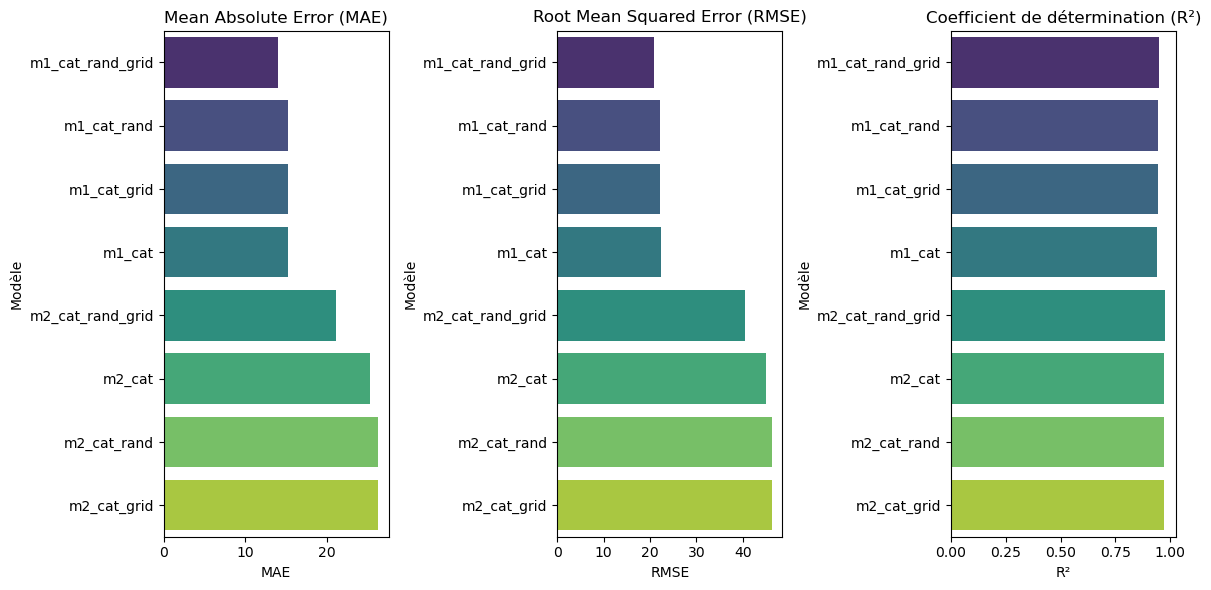

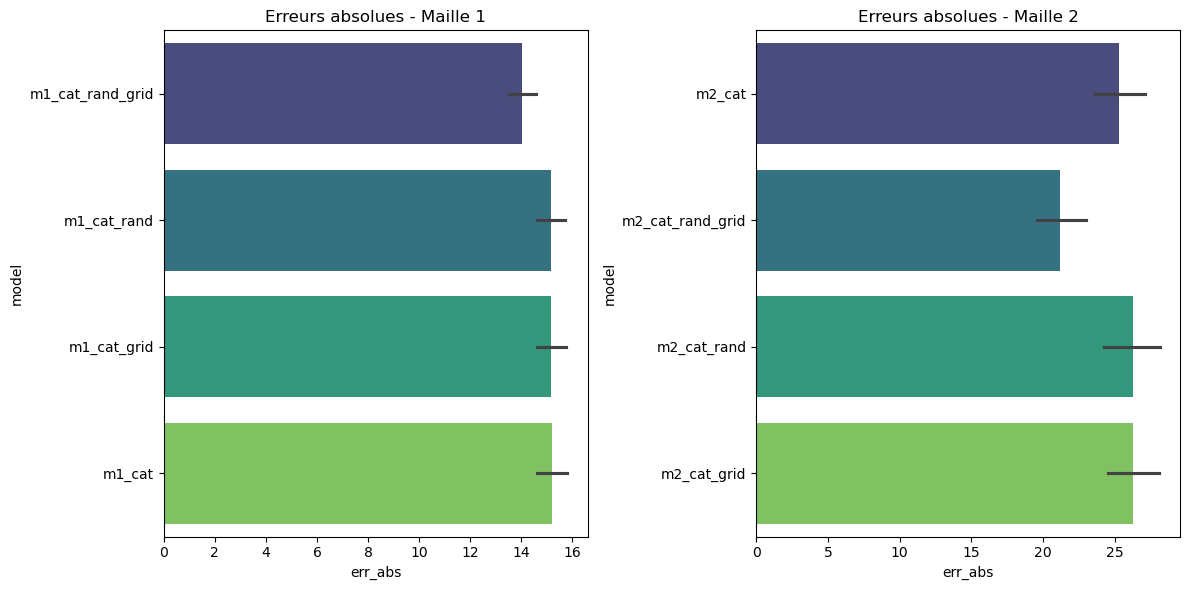

In [434]:
# Visualisation des scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='MAE', y='Modèle', data=df_scores_sorted3, palette='viridis')
plt.title("Mean Absolute Error (MAE)")

plt.subplot(1, 3, 2)
sns.barplot(x='RMSE', y='Modèle', data=df_scores_sorted3, palette='viridis')
plt.title("Root Mean Squared Error (RMSE)")

plt.subplot(1, 3, 3)
sns.barplot(x='R²', y='Modèle', data=df_scores_sorted3, palette='viridis')
plt.title("Coefficient de détermination (R²)")

plt.tight_layout()

# Comparaison des erreurs absolues
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='err_abs', y='model', data=all_best_cat_results, palette='viridis')
plt.title("Erreurs absolues - Maille 1")

plt.subplot(1, 2, 2)
sns.barplot(x='err_abs', y='model', data=all_best_cat_results2, palette='viridis')
plt.title("Erreurs absolues - Maille 2")

plt.tight_layout()

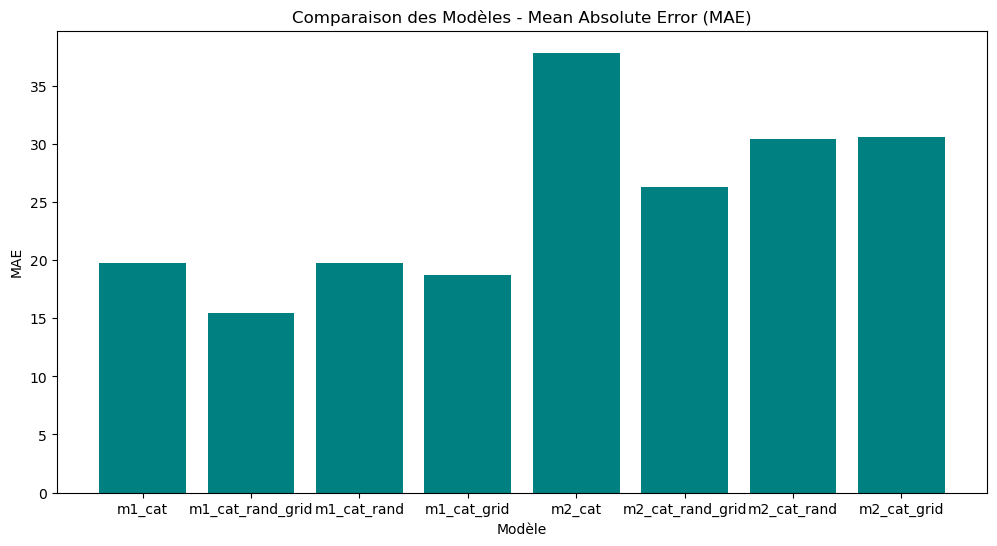

In [435]:
# Comparaison des scores MAE
plt.figure(figsize=(12, 6))
plt.bar(models3, mae_scores, color='teal')
plt.xlabel('Modèle')
plt.ylabel('MAE')
plt.title('Comparaison des Modèles - Mean Absolute Error (MAE)')
plt.show()

### Visualisation Catboost ###

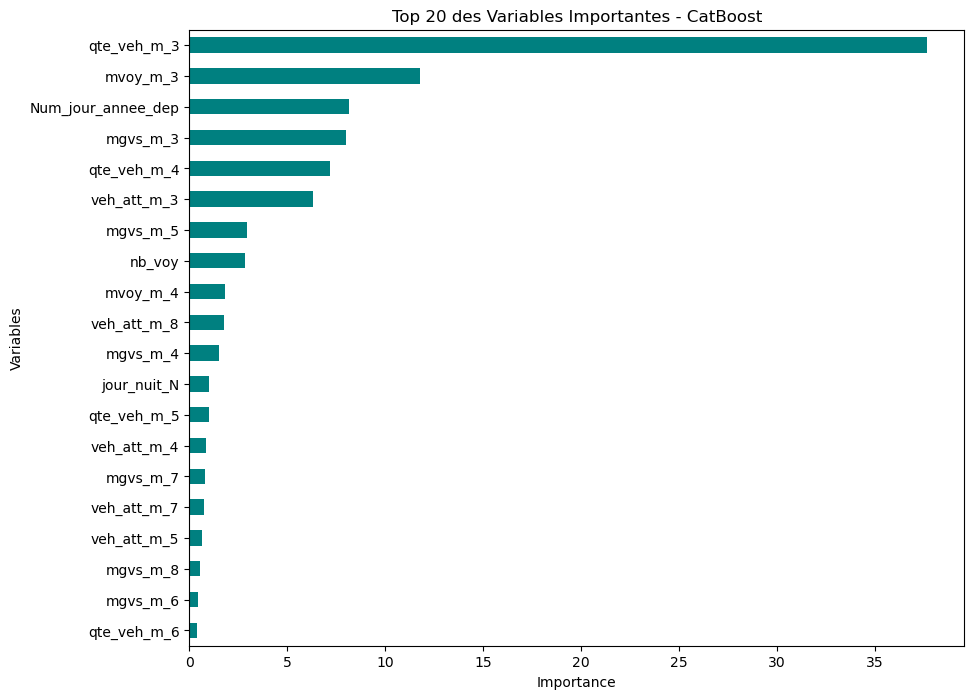

In [436]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat = cat_model.feature_importances_
features_cat = X_train.columns
feature_importances_cat = pd.Series(importances_cat, index=features_cat)
feature_importances_cat = feature_importances_cat.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

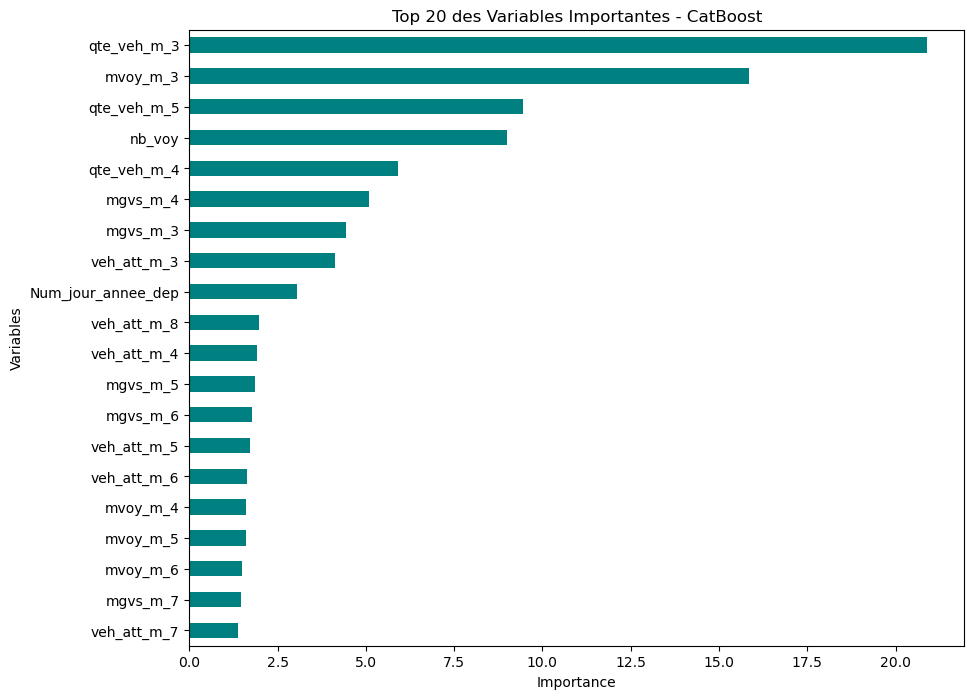

In [437]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat2 = cat_model2.feature_importances_
features_cat2 = X_train2.columns
feature_importances_cat2 = pd.Series(importances_cat2, index=features_cat2)
feature_importances_cat2 = feature_importances_cat2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

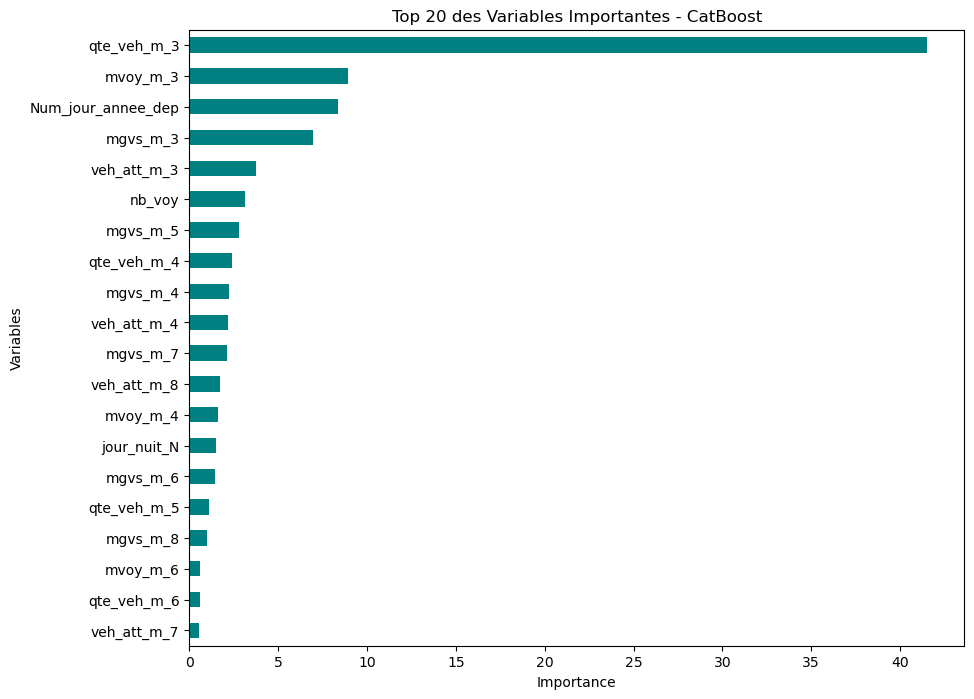

In [438]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_best = cat_best_model.feature_importances_
features_cat_best = X_train.columns
feature_importances_cat_best = pd.Series(importances_cat_best, index=features_cat_best)
feature_importances_cat_best = feature_importances_cat_best.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_best.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

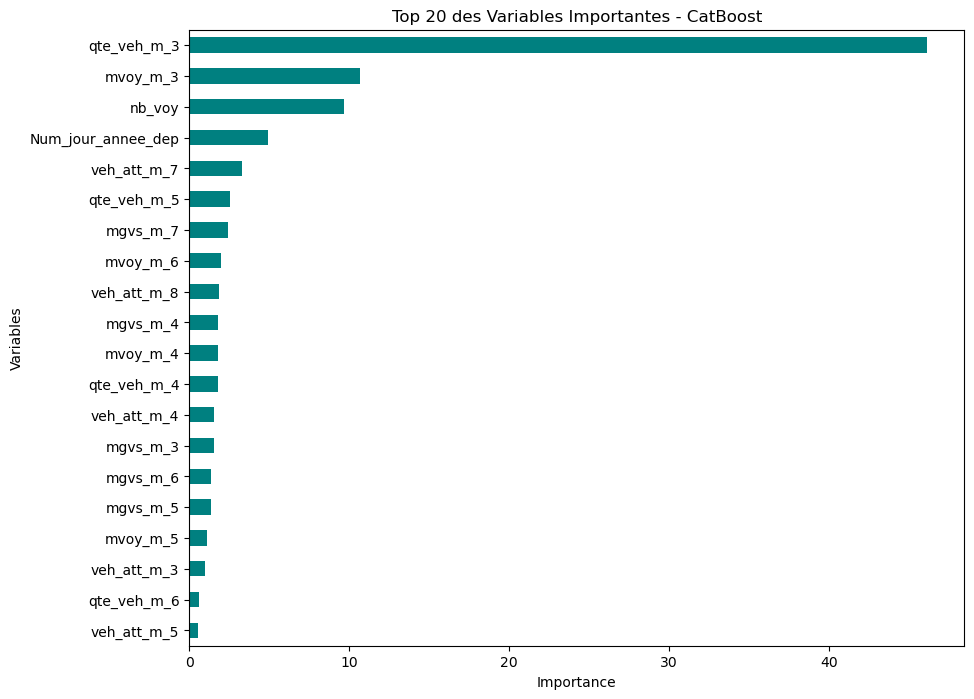

In [439]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_best2 = cat_best_model2.feature_importances_
features_cat_best2 = X_train2.columns
feature_importances_cat_best2 = pd.Series(importances_cat_best2, index=features_cat_best2)
feature_importances_cat_best2 = feature_importances_cat_best2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_best2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

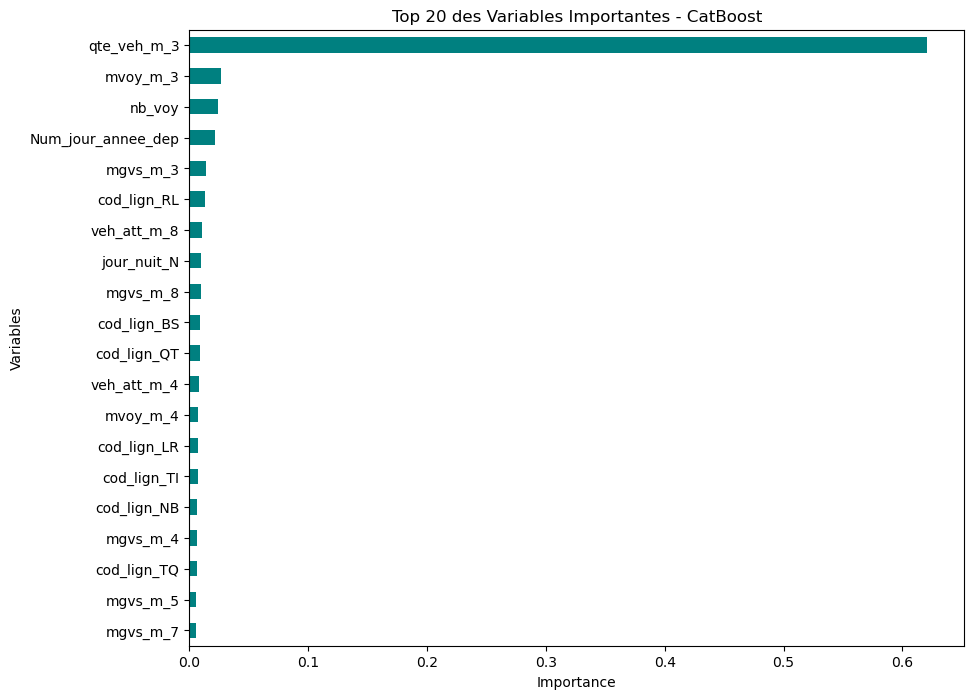

In [440]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_m1_2 = cat_best_model_m1_2.feature_importances_
features_cat_m1_2 = X_train.columns
feature_importances_cat_m1_2 = pd.Series(importances_cat_m1_2, index=features_cat_m1_2)
feature_importances_cat_m1_2 = feature_importances_cat_m1_2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_m1_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

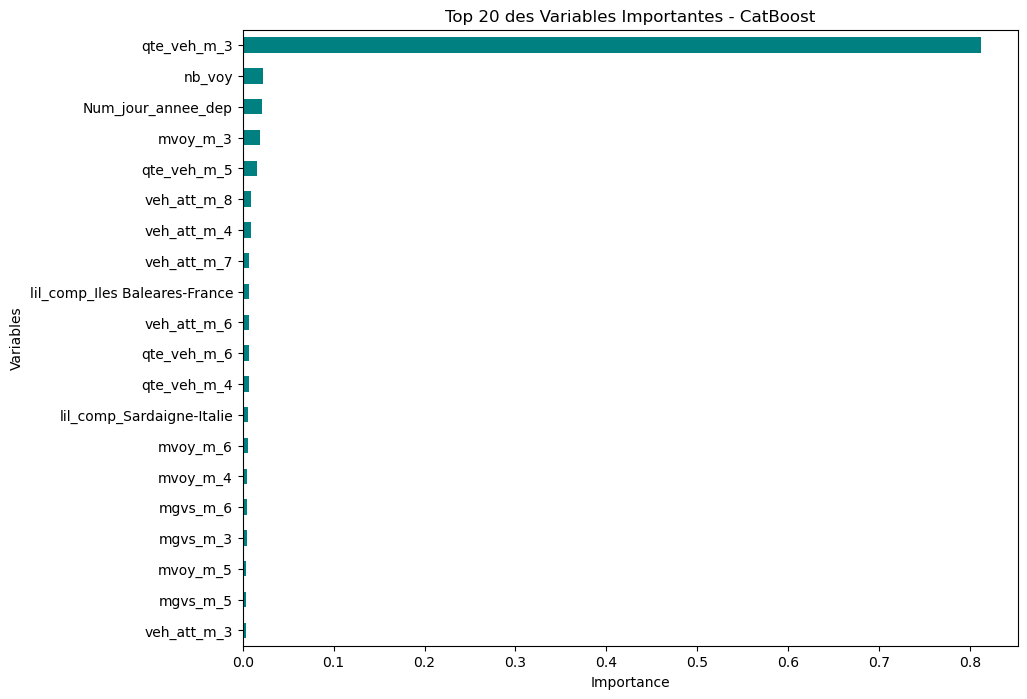

In [441]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_m2_2 = cat_best_model_m2_2.feature_importances_
features_cat_m2_2 = X_train2.columns
feature_importances_cat_m2_2 = pd.Series(importances_cat_m2_2, index=features_cat_m2_2)
feature_importances_cat_m2_2 = feature_importances_cat_m2_2.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_m2_2.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

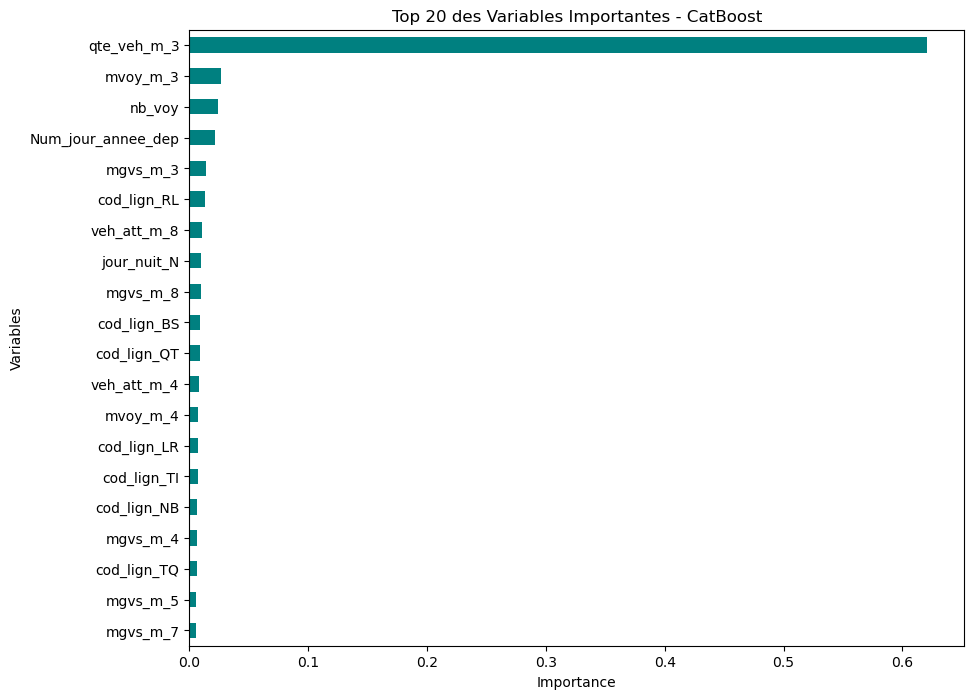

In [442]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_m1_3 = cat_best_model_m1_3.feature_importances_
features_cat_m1_3 = X_train.columns
feature_importances_cat_m1_3 = pd.Series(importances_cat_m1_3, index=features_cat_m1_3)
feature_importances_cat_m1_3 = feature_importances_cat_m1_3.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_m1_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

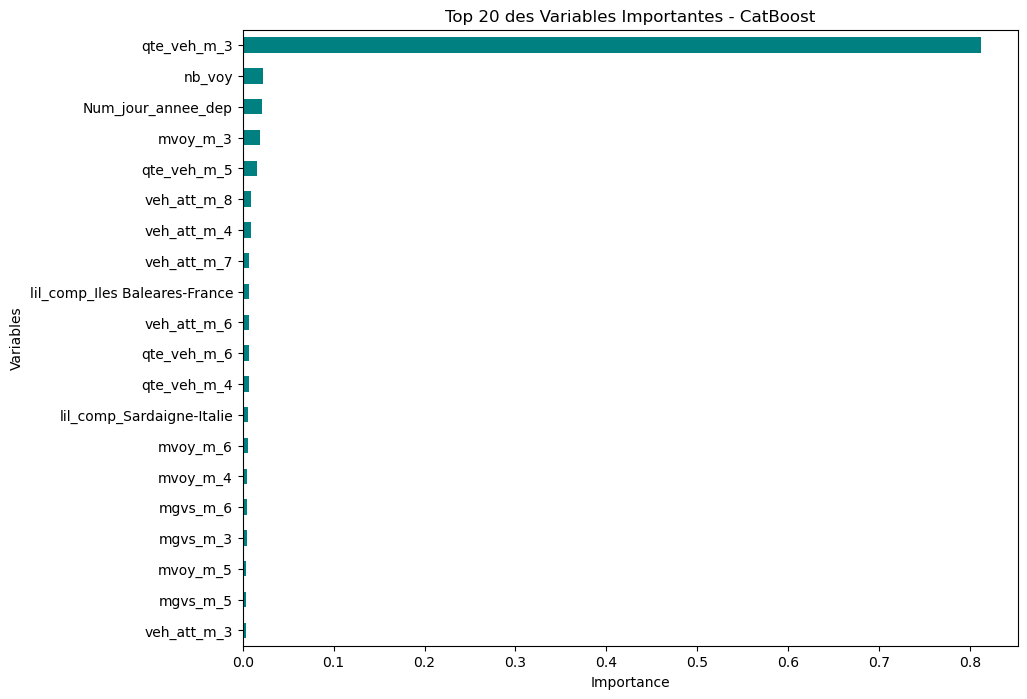

In [443]:
# Extraire et trier les importances des caractéristiques pour CatBoost
importances_cat_m2_3 = cat_best_model_m2_3.feature_importances_
features_cat_m2_3 = X_train2.columns
feature_importances_cat_m2_3 = pd.Series(importances_cat_m2_3, index=features_cat_m2_3)
feature_importances_cat_m2_3 = feature_importances_cat_m2_3.sort_values(ascending=False)

# Afficher les 20 premières variables importantes
plt.figure(figsize=(10, 8))
feature_importances_cat_m2_3.head(20).plot(kind='barh', color="teal")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.title("Top 20 des Variables Importantes - CatBoost")
plt.gca().invert_yaxis()  # Inverser l'axe pour avoir la variable la plus importante en haut
plt.show()

### Autres ###

In [ ]:
# # Enregistrer un modèle
# import joblib

# # Sauvegarder un modèle
# joblib.dump(rf_model, 'random_forest_model.joblib')

# # Charger un modèle
# rf_model = joblib.load('random_forest_model.joblib')

In [ ]:
# # Prendre un échantillon de 10 % des données
# X_sample = X.sample(frac=0.1, random_state=42)
# y_sample = y.loc[X_sample.index]

# model.fit(X_sample, y_sample)

In [ ]:
# # Arrondir pour simplifier les prédictions
# # Exemple d'arrondi pour des colonnes spécifiques
# X['colonne_numerique'] = X['colonne_numerique'].round(2)

In [ ]:
# # Méthode warm_start pour ajouter des arbres à un modèle existant
# rf_model = RandomForestRegressor(n_estimators=50, warm_start=True, random_state=42, verbose=1)

# # Premier entraînement
# rf_model.fit(X_train, y_train)

# # Augmenter le nombre d'arbres sans recommencer depuis zéro
# rf_model.n_estimators += 50
# rf_model.fit(X_train, y_train)

In [ ]:
# # Arbre unique
# from sklearn.tree import DecisionTreeRegressor

# dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
# dt_model.fit(X_train, y_train)

# # Calculer le score sur un ensemble de test
# score = dt_model.score(X_test, y_test)
# print("Score de l'arbre de décision :", score)

In [ ]:
# Avec tout combiné: 
# # from sklearn.ensemble import RandomForestRegressor
# import joblib

# # Paramètres optimisés
# rf_model = RandomForestRegressor(
#     n_estimators=50,          # Moins d'arbres
#     max_depth=10,             # Profondeur limitée
#     n_jobs=-1,                # Utilisation de tous les cœurs
#     warm_start=True,          # Entraînement par étapes
#     random_state=42,
#     verbose=1                 # Suivi de progression
# )

# # Entraînement par étapes et sauvegarde régulière
# for step in range(5):  # 5 étapes pour 50 arbres au total
#     rf_model.n_estimators += 10  # Ajouter 10 arbres par étape
#     rf_model.fit(X_train, y_train)
    
#     # Sauvegarder un snapshot du modèle après chaque étape
#     joblib.dump(rf_model, f'random_forest_step_{step}.joblib')
#     print(f"Modèle sauvegardé à l'étape {step}")